In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from surprise.model_selection import KFold
from tqdm.notebook import tqdm
from sklearn.metrics import ndcg_score
from surprise import dump
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
from surprise import SVD
import random
import pickle
from copy import deepcopy

import typing as tp
from sklearn.preprocessing import normalize
from lightfm import LightFM
from scipy.sparse import coo_matrix
from lightfm.data import Dataset as LFMDataset
from collections import Counter
from matplotlib.lines import Line2D
import time
import optuna

np.random.seed(42)

C:\ProgramData\Anaconda3\envs\torchvision2\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [3]:
from uuu import mapk_plot, mapk, calculate_serendipity_per_user, prediction_coverage, \
catalog_coverage, long_tail_plot, weight_by_volume, get_frame_from_prediction_list, novelty, get_value_popularity_ranks

In [4]:
df = pd.read_csv('../data/recsys-in-practice/train_joke_df.csv')

df['UID'] = df['UID'] - 1
df['JID'] = df['JID'] - 1
# сделаем сортировку и перепишем index
df = df.sort_values(by=['UID', 'JID'])
df = df.reset_index(drop=True)

df

df_train, df_test = train_test_split(df, test_size=0.5, random_state=42)

E:\competitions\kaggle\magnit_recsys-in-practice\part2\uuu.py:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  head = head.append(tail.head(1))


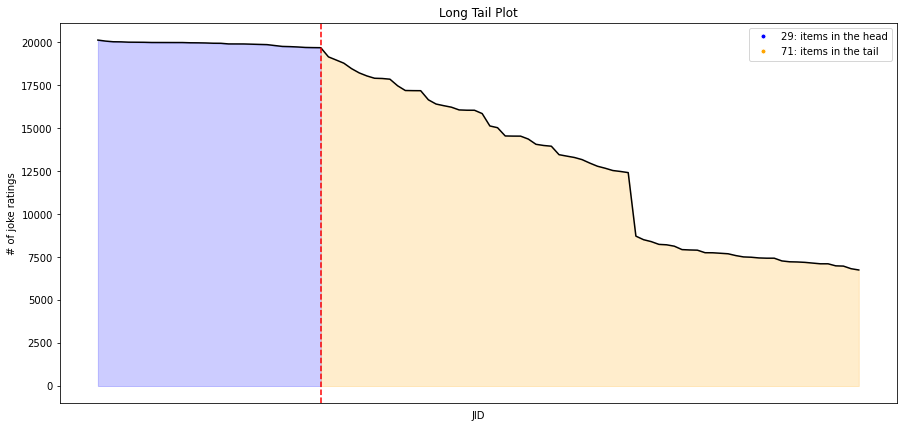

In [5]:
fig = plt.figure(figsize=(15, 7))
volume_df = long_tail_plot(df=df, 
             item_id_column="JID", 
             interaction_type="joke ratings", 
             percentage=0.4,
             x_labels=False)

volume_df['weight'] = volume_df['percent_of_total_volume'].apply(weight_by_volume)
joke_volume = {}
for row in volume_df.itertuples():
    joke_volume[int(row.JID)] = row.weight

In [6]:
df_top_joke = df[df['Rating'] > 5].groupby('JID').agg('count').rename(columns={'Rating':'count_plus'}) \
.sort_values('count_plus', ascending=False).drop(columns=['UID'])


df_bottom_joke = df[df['Rating'] < -5].groupby('JID').agg('count').rename(columns={'Rating':'count_minus'}) \
.sort_values('count_minus', ascending=False).drop(columns=['UID'])


df_counts = df_bottom_joke.merge(df_top_joke, left_index=True, right_index=True)


df_counts['diff'] = df_counts['count_plus'] - df_counts['count_minus']
df_counts = df_counts.sort_values('diff', ascending=False)


df_counts['weight'] = df_counts['diff'] / 10000

joke_quality = {}
for row in df_counts.itertuples():
    joke_quality[row.Index] = row.weight

In [7]:

from CatBoostWrapper import CatBoostWrapper
from LightFMWrapper import LightFMWrapper
from NNWrapper import NNWrapper
from SurpriseWrapper import SurpriseWrapper


In [39]:

wrappers ={
    'svd':SurpriseWrapper(model_name='svd05.surprise', folder_name='models', df_train=df_train), 
    #'lfm_cos':LightFMWrapper(model_name='', folder_name='models', df_train=df_train),           
    'catboost':CatBoostWrapper(model_name='catboost05', folder_name='models', df_train=df_train), 
    #'knn':SurpriseWrapper(model_name='knn05.surprise', folder_name='models', df_train=df_train), 
    'nn_bias':NNWrapper(model_name='nn05.ckpt', folder_name='models', df_train=df_train)
}


In [40]:

candidates = {model_name: wrapper.predict() for model_name, wrapper in wrappers.items()}
    

svd05.surprise time: 57.902
catboost05 time: 46.983
nn05.ckpt time: 58.04


In [14]:
candidates['lfm_cos']

,UID,JID,Rating_pred,Rating,_merge
0,0,52,1,NaN,left_only
1,0,18,2,NaN,left_only
2,0,20,3,NaN,left_only
3,0,41,4,NaN,left_only
4,0,45,5,NaN,left_only
...,...,...,...,...,...
249811,24982,68,6,NaN,left_only
249812,24982,53,7,NaN,left_only
249813,24982,55,8,NaN,left_only
249814,24982,16,9,NaN,left_only


In [15]:
predictions = {k:list(v.groupby('UID').agg({'JID':list})['JID'].values) for k, v in candidates.items()}

In [19]:
n_users = np.unique(df['UID']).size
n_items = np.unique(df['JID']).size
n_recommendations=10

In [20]:
def get_n_recommendations_for_user(df, user_id, n, sort_by):
    recommended_items = df[df['UID'] == user_id]
    recommended_items = recommended_items.sort_values(sort_by, ascending=False)  
    return recommended_items.iloc[:n]


frames = []
for user in tqdm(range(n_users)):
    frames.append(get_n_recommendations_for_user(df_test, user, n_recommendations, 'Rating'))
    
df_true = pd.concat(frames).reset_index()
df_true = df_true.drop(columns=['index'])
display(df_true)

actual = list(df_true.groupby('UID').agg({'JID':list})['JID'].values)

  0%|          | 0/24983 [00:00<?, ?it/s]

,UID,JID,Rating
0,0,1,8.79
1,0,13,8.45
2,0,26,7.82
3,0,7,4.17
4,0,61,3.59
...,...,...,...
249691,24982,20,7.28
249692,24982,24,6.94
249693,24982,48,6.84
249694,24982,54,6.36


In [21]:
users = df["UID"].unique()
n_users = users.size
n_users

24983

In [ ]:
# рекомендации по популярным 
#popularity_recs = df['JID'].value_counts().head(10).index.tolist()

#pop_recs = []
#for user in tqdm(range(n_users)):
#    pop_predictions = popularity_recs
#    pop_recs.append(pop_predictions)
    
    
#predictions['popular'] = pop_recs

In [22]:
pop = dict(df.JID.value_counts())

In [23]:
items = np.unique(df['JID'])
items

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int64)

In [24]:
def union_predicts(params):
    result = []

    for u in range(24983):
        res = {}
        for i, (key, value) in enumerate(predictions.items()):
            rank = {x: params[key] * (10-j) for j, x in enumerate(value[u])}

            for k, v in rank.items():
                if k in res:
                    res[k] += v
                else:
                    res[k] = v
                    
        for k in res:
            res[k] += joke_quality[k] * params['quality']
            res[k] += joke_volume[k] * params['volume']

        result.append([x[0] for x in sorted(res.items(), key=lambda item: item[1], reverse=True)][:10])
        
    return result

In [25]:
def main_metric(params):
    t1 = time.time()
    result = union_predicts(params)
    res_df = get_frame_from_prediction_list(users, result)


    cat_coverage = catalog_coverage(result, items, 100)
    pred_coverage = prediction_coverage(result, items)
    nov, mselfinfo_list = novelty(result, pop, len(users), 10)

    res_df = get_frame_from_prediction_list(users, result)
    serendip = calculate_serendipity_per_user(res_df, df_train, df_test)
    map1 = mapk(actual, result, k=1)
    map10 = mapk(actual, result, k=10)
    
    price = np.mean([sum([joke_volume[x] for x in xx]) for xx in result])
    
    sm = sum([cat_coverage / 100, pred_coverage / 100, nov, serendip, map1, map10, price / 3])
    print('time',round(time.time() - t1, 3), 
        'cat_cov',  round(cat_coverage, 3), 
         'cov', round(pred_coverage, 3),
         'nov', round(nov, 3),
         'ser', round(serendip, 3),
        'm1',  round(map1 , 3),
         'm10', round(map10, 3),
         'price', round(price, 3),
         'sum', round(sm, 3))
    return sm

In [31]:
main_metric({'svd': 0.1, 
              'lfm_cos': 0.1, 
              'nn_bias': 0.1, 
              'catboost': 0.1, 
              'knn': 0.1, 
              'quality': 0.1,
              'volume': 0.1
             })

time 2.646 cat_cov 79.0 cov 100.0 nov 0.602 ser 0.114 m1 0.555 m10 0.597 price 2.541 sum 4.505


4.505477350021328

In [30]:
result = union_predicts({'svd': 0.1, 
              'lfm_cos': 0.1, 
              'nn_bias': 0.1, 
              'catboost': 0.1, 
              'knn': 0.1, 
              'quality': 0.1,
              'volume': 0.1
             })

In [32]:
result

[[52, 26, 61, 88, 48, 30, 13, 65, 71, 1],
 [88, 26, 71, 86, 52, 90, 30, 82, 73, 36],
 [49, 88, 26, 34, 35, 48, 52, 6, 44, 68],
 [67, 31, 64, 26, 53, 48, 88, 41, 68, 65],
 [52, 26, 53, 61, 28, 0, 75, 60, 13, 99],
 [88, 34, 61, 28, 92, 52, 96, 85, 22, 93],
 [49, 64, 26, 30, 61, 14, 88, 71, 47, 80],
 [49, 35, 88, 90, 53, 28, 34, 80, 37, 7],
 [61, 31, 30, 35, 67, 64, 71, 88, 26, 68],
 [34, 49, 61, 26, 88, 48, 31, 40, 53, 68],
 [61, 30, 88, 34, 68, 53, 67, 11, 20, 41],
 [88, 49, 28, 31, 75, 90, 71, 79, 68, 66],
 [35, 49, 26, 52, 34, 60, 68, 61, 88, 55],
 [30, 35, 34, 53, 39, 31, 80, 48, 61, 64],
 [47, 88, 31, 92, 28, 48, 32, 52, 71, 93],
 [35, 28, 52, 34, 53, 31, 20, 67, 9, 82],
 [14, 61, 30, 26, 48, 88, 60, 71, 53, 25],
 [26, 49, 86, 90, 82, 35, 31, 61, 34, 70],
 [35, 26, 61, 28, 52, 34, 53, 10, 44, 88],
 [28, 34, 61, 48, 88, 60, 67, 68, 11, 71],
 [35, 26, 88, 49, 61, 34, 4, 68, 25, 90],
 [35, 20, 88, 6, 68, 65, 92, 64, 90, 1],
 [31, 28, 26, 34, 52, 61, 37, 88, 80, 16],
 [88, 35, 26, 61, 7

In [33]:
def objective(trial):    
    
    params = {'svd': trial.suggest_float(name='svd', low=-1, high=1, step=0.1), 
              'lfm_cos': trial.suggest_float(name='lfm_cos', low=-1, high=1, step=0.1), 
              'nn_bias': trial.suggest_float(name='nn_bias', low=-1, high=1, step=0.1), 
              'catboost': trial.suggest_float(name='catboost', low=-1, high=1, step=0.1), 
              'knn': trial.suggest_float(name='knn', low=-1, high=1, step=0.1), 
              'quality': trial.suggest_float(name='quality', low=-1, high=1, step=0.1),
              'volume': trial.suggest_float(name='volume', low=-1, high=1, step=0.1)
             }
    
    return main_metric(params)
    


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)


[I 2023-05-12 13:25:03,392] A new study created in memory with name: no-name-7d636ead-1041-44f5-8b76-ea4ffabde2a6
[I 2023-05-12 13:25:05,972] Trial 0 finished with value: 4.089381213634612 and parameters: {'svd': -0.9, 'lfm_cos': 0.7000000000000002, 'nn_bias': -0.29999999999999993, 'catboost': 0.8, 'knn': 0.8, 'quality': -0.29999999999999993, 'volume': 0.6000000000000001}. Best is trial 0 with value: 4.089381213634612.


time 2.577 cat_cov 84.0 cov 100.0 nov 0.545 ser 0.1 m1 0.309 m10 0.437 price 2.574 sum 4.089


[I 2023-05-12 13:25:08,546] Trial 1 finished with value: 4.342438564338059 and parameters: {'svd': -0.29999999999999993, 'lfm_cos': -0.5, 'nn_bias': -0.9, 'catboost': -0.3999999999999999, 'knn': -0.19999999999999996, 'quality': 0.8, 'volume': -0.19999999999999996}. Best is trial 1 with value: 4.342438564338059.


time 2.572 cat_cov 95.0 cov 100.0 nov 0.862 ser 0.165 m1 0.141 m10 0.314 price 2.732 sum 4.342


[I 2023-05-12 13:25:11,157] Trial 2 finished with value: 5.6660250986180225 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': 0.40000000000000013, 'quality': -0.8, 'volume': -0.7}. Best is trial 2 with value: 5.6660250986180225.


time 2.609 cat_cov 99.0 cov 100.0 nov 1.016 ser 0.204 m1 0.832 m10 0.807 price 2.452 sum 5.666


[I 2023-05-12 13:25:13,770] Trial 3 finished with value: 5.577564498906366 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.5, 'nn_bias': 0.6000000000000001, 'catboost': -0.29999999999999993, 'knn': -0.6, 'quality': 0.6000000000000001, 'volume': 0.30000000000000004}. Best is trial 2 with value: 5.6660250986180225.


time 2.611 cat_cov 99.0 cov 100.0 nov 0.943 ser 0.194 m1 0.822 m10 0.747 price 2.644 sum 5.578


[I 2023-05-12 13:25:16,351] Trial 4 finished with value: 3.7952598306184715 and parameters: {'svd': -0.19999999999999996, 'lfm_cos': -0.19999999999999996, 'nn_bias': -0.5, 'catboost': 0.8, 'knn': 0.9000000000000001, 'quality': -1.0, 'volume': 0.0}. Best is trial 2 with value: 5.6660250986180225.


time 2.578 cat_cov 47.0 cov 100.0 nov 0.657 ser 0.077 m1 0.331 m10 0.486 price 2.321 sum 3.795


[I 2023-05-12 13:25:18,938] Trial 5 finished with value: 4.740631828033135 and parameters: {'svd': 0.20000000000000018, 'lfm_cos': 0.7000000000000002, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.5, 'quality': -0.09999999999999998, 'volume': 0.5}. Best is trial 2 with value: 5.6660250986180225.


time 2.585 cat_cov 94.0 cov 100.0 nov 0.708 ser 0.18 m1 0.493 m10 0.51 price 2.73 sum 4.741


[I 2023-05-12 13:25:21,510] Trial 6 finished with value: 3.9781396546249024 and parameters: {'svd': -0.6, 'lfm_cos': 0.9000000000000001, 'nn_bias': -0.3999999999999999, 'catboost': 0.8, 'knn': -0.9, 'quality': 0.8, 'volume': 0.6000000000000001}. Best is trial 2 with value: 5.6660250986180225.


time 2.57 cat_cov 86.0 cov 100.0 nov 0.522 ser 0.145 m1 0.163 m10 0.322 price 2.9 sum 3.978


[I 2023-05-12 13:25:24,110] Trial 7 finished with value: 4.310227915791391 and parameters: {'svd': 0.0, 'lfm_cos': 0.40000000000000013, 'nn_bias': 0.0, 'catboost': 0.7000000000000002, 'knn': -0.29999999999999993, 'quality': -0.7, 'volume': 0.40000000000000013}. Best is trial 2 with value: 5.6660250986180225.


time 2.598 cat_cov 93.0 cov 100.0 nov 0.47 ser 0.117 m1 0.387 m10 0.488 price 2.753 sum 4.31


[I 2023-05-12 13:25:26,701] Trial 8 finished with value: 3.8721000803293673 and parameters: {'svd': -0.3999999999999999, 'lfm_cos': -0.09999999999999998, 'nn_bias': -1.0, 'catboost': 0.7000000000000002, 'knn': 0.8, 'quality': -0.9, 'volume': -0.5}. Best is trial 2 with value: 5.6660250986180225.


time 2.589 cat_cov 66.0 cov 100.0 nov 0.634 ser 0.08 m1 0.279 m10 0.444 price 2.324 sum 3.872


[I 2023-05-12 13:25:29,375] Trial 9 finished with value: 4.718620754646264 and parameters: {'svd': 0.8, 'lfm_cos': 0.6000000000000001, 'nn_bias': 1.0, 'catboost': 0.10000000000000009, 'knn': 0.8, 'quality': -0.29999999999999993, 'volume': -0.8}. Best is trial 2 with value: 5.6660250986180225.


time 2.672 cat_cov 88.0 cov 100.0 nov 0.751 ser 0.132 m1 0.545 m10 0.602 price 2.426 sum 4.719


[I 2023-05-12 13:25:32,010] Trial 10 finished with value: 5.26757540308404 and parameters: {'svd': 0.5, 'lfm_cos': -1.0, 'nn_bias': 0.40000000000000013, 'catboost': -1.0, 'knn': 0.20000000000000018, 'quality': 0.20000000000000018, 'volume': -1.0}. Best is trial 2 with value: 5.6660250986180225.


time 2.616 cat_cov 95.0 cov 100.0 nov 1.103 ser 0.186 m1 0.6 m10 0.627 price 2.405 sum 5.268


[I 2023-05-12 13:25:34,666] Trial 11 finished with value: 5.454176238622384 and parameters: {'svd': 1.0, 'lfm_cos': -0.6, 'nn_bias': 0.8, 'catboost': -0.09999999999999998, 'knn': -0.8, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 2 with value: 5.6660250986180225.


time 2.638 cat_cov 96.0 cov 100.0 nov 0.924 ser 0.19 m1 0.78 m10 0.715 price 2.658 sum 5.454


[I 2023-05-12 13:25:37,311] Trial 12 finished with value: 4.989625995916212 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.5, 'catboost': 0.20000000000000018, 'knn': 0.20000000000000018, 'quality': 0.40000000000000013, 'volume': -0.29999999999999993}. Best is trial 2 with value: 5.6660250986180225.


time 2.625 cat_cov 95.0 cov 100.0 nov 0.727 ser 0.15 m1 0.644 m10 0.671 price 2.543 sum 4.99


[I 2023-05-12 13:25:39,953] Trial 13 finished with value: 4.877582178919814 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': -0.5, 'nn_bias': 0.6000000000000001, 'catboost': -1.0, 'knn': -0.5, 'quality': 1.0, 'volume': 0.20000000000000018}. Best is trial 2 with value: 5.6660250986180225.


time 2.623 cat_cov 96.0 cov 100.0 nov 1.039 ser 0.193 m1 0.314 m10 0.497 price 2.623 sum 4.878


[I 2023-05-12 13:25:42,659] Trial 14 finished with value: 5.702975676445987 and parameters: {'svd': 1.0, 'lfm_cos': -0.9, 'nn_bias': 0.20000000000000018, 'catboost': -0.5, 'knn': -0.6, 'quality': -0.6, 'volume': -0.6}. Best is trial 14 with value: 5.702975676445987.


time 2.687 cat_cov 99.0 cov 100.0 nov 1.001 ser 0.201 m1 0.864 m10 0.782 price 2.597 sum 5.703


[I 2023-05-12 13:25:45,339] Trial 15 finished with value: 5.652091031169737 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -1.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.5, 'volume': -0.6}. Best is trial 14 with value: 5.702975676445987.


time 2.662 cat_cov 96.0 cov 100.0 nov 1.066 ser 0.194 m1 0.842 m10 0.768 price 2.465 sum 5.652


[I 2023-05-12 13:25:48,513] Trial 16 finished with value: 5.3910937991071135 and parameters: {'svd': 0.30000000000000004, 'lfm_cos': 0.10000000000000009, 'nn_bias': -0.09999999999999998, 'catboost': -0.7, 'knn': 0.40000000000000013, 'quality': -0.7, 'volume': -1.0}. Best is trial 14 with value: 5.702975676445987.


time 3.155 cat_cov 100.0 cov 100.0 nov 0.896 ser 0.212 m1 0.716 m10 0.742 price 2.477 sum 5.391


[I 2023-05-12 13:25:51,182] Trial 17 finished with value: 5.556002609425852 and parameters: {'svd': 1.0, 'lfm_cos': -0.8, 'nn_bias': -0.7, 'catboost': -0.5, 'knn': 0.5, 'quality': -0.5, 'volume': -0.6}. Best is trial 14 with value: 5.702975676445987.


time 2.65 cat_cov 100.0 cov 100.0 nov 0.881 ser 0.189 m1 0.85 m10 0.783 price 2.559 sum 5.556


[I 2023-05-12 13:25:53,872] Trial 18 finished with value: 4.569538337656671 and parameters: {'svd': 0.10000000000000009, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.30000000000000004, 'catboost': 0.40000000000000013, 'knn': -1.0, 'quality': -0.8, 'volume': -0.29999999999999993}. Best is trial 14 with value: 5.702975676445987.


time 2.669 cat_cov 98.0 cov 100.0 nov 0.921 ser 0.175 m1 0.204 m10 0.403 price 2.663 sum 4.57


[I 2023-05-12 13:25:56,597] Trial 19 finished with value: 5.582264853866348 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.40000000000000013, 'nn_bias': -0.19999999999999996, 'catboost': -0.19999999999999996, 'knn': -0.19999999999999996, 'quality': -0.09999999999999998, 'volume': -0.8}. Best is trial 14 with value: 5.702975676445987.


time 2.702 cat_cov 97.0 cov 100.0 nov 0.681 ser 0.217 m1 0.921 m10 0.832 price 2.884 sum 5.582


[I 2023-05-12 13:25:59,294] Trial 20 finished with value: 4.789765828143713 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': 1.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': -0.6, 'quality': -0.5, 'volume': 0.0}. Best is trial 14 with value: 5.702975676445987.


time 2.679 cat_cov 99.0 cov 100.0 nov 0.68 ser 0.216 m1 0.421 m10 0.494 price 2.968 sum 4.79


[I 2023-05-12 13:26:01,959] Trial 21 finished with value: 5.658685336491186 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -1.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.6, 'knn': 0.0, 'quality': -0.5, 'volume': -0.6}. Best is trial 14 with value: 5.702975676445987.


time 2.645 cat_cov 97.0 cov 100.0 nov 1.055 ser 0.193 m1 0.845 m10 0.775 price 2.465 sum 5.659


[I 2023-05-12 13:26:04,653] Trial 22 finished with value: 5.5816261993977365 and parameters: {'svd': 0.8, 'lfm_cos': -0.8, 'nn_bias': 0.30000000000000004, 'catboost': -0.5, 'knn': 0.10000000000000009, 'quality': -0.6, 'volume': -0.8}. Best is trial 14 with value: 5.702975676445987.


time 2.675 cat_cov 95.0 cov 100.0 nov 1.01 ser 0.191 m1 0.829 m10 0.78 price 2.469 sum 5.582


[I 2023-05-12 13:26:07,343] Trial 23 finished with value: 5.57753268848793 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.8, 'nn_bias': -0.09999999999999998, 'catboost': -0.9, 'knn': 0.40000000000000013, 'quality': -0.29999999999999993, 'volume': -0.5}. Best is trial 14 with value: 5.702975676445987.


time 2.671 cat_cov 98.0 cov 100.0 nov 1.045 ser 0.195 m1 0.795 m10 0.746 price 2.451 sum 5.578


[I 2023-05-12 13:26:10,043] Trial 24 finished with value: 5.576362288994394 and parameters: {'svd': 1.0, 'lfm_cos': -0.29999999999999993, 'nn_bias': 0.7000000000000002, 'catboost': -0.6, 'knn': -0.3999999999999999, 'quality': -1.0, 'volume': -0.19999999999999996}. Best is trial 14 with value: 5.702975676445987.


time 2.683 cat_cov 97.0 cov 100.0 nov 0.967 ser 0.198 m1 0.82 m10 0.754 price 2.599 sum 5.576


[I 2023-05-12 13:26:12,763] Trial 25 finished with value: 5.3592237637487745 and parameters: {'svd': 0.8, 'lfm_cos': -0.7, 'nn_bias': 0.40000000000000013, 'catboost': -0.9, 'knn': 0.6000000000000001, 'quality': -0.8, 'volume': -0.7}. Best is trial 14 with value: 5.702975676445987.


time 2.7 cat_cov 99.0 cov 100.0 nov 1.023 ser 0.186 m1 0.647 m10 0.71 price 2.408 sum 5.359


[I 2023-05-12 13:26:15,426] Trial 26 finished with value: 5.669425851491091 and parameters: {'svd': 0.5, 'lfm_cos': -1.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.29999999999999993, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': -0.3999999999999999}. Best is trial 14 with value: 5.702975676445987.


time 2.644 cat_cov 97.0 cov 100.0 nov 1.031 ser 0.189 m1 0.859 m10 0.788 price 2.497 sum 5.669


[I 2023-05-12 13:26:18,116] Trial 27 finished with value: 5.652277221905724 and parameters: {'svd': 0.5, 'lfm_cos': -0.3999999999999999, 'nn_bias': 0.0, 'catboost': -0.09999999999999998, 'knn': -0.7, 'quality': 0.10000000000000009, 'volume': -0.3999999999999999}. Best is trial 14 with value: 5.702975676445987.


time 2.672 cat_cov 94.0 cov 100.0 nov 0.97 ser 0.203 m1 0.86 m10 0.786 price 2.678 sum 5.652


[I 2023-05-12 13:26:20,769] Trial 28 finished with value: 4.289926427446163 and parameters: {'svd': 0.0, 'lfm_cos': 0.0, 'nn_bias': -0.5, 'catboost': 0.30000000000000004, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': -0.09999999999999998}. Best is trial 14 with value: 5.702975676445987.


time 2.634 cat_cov 95.0 cov 100.0 nov 0.627 ser 0.136 m1 0.322 m10 0.461 price 2.384 sum 4.29


[I 2023-05-12 13:26:23,325] Trial 29 finished with value: 4.102911336964795 and parameters: {'svd': -1.0, 'lfm_cos': 0.30000000000000004, 'nn_bias': -0.19999999999999996, 'catboost': -0.29999999999999993, 'knn': 0.20000000000000018, 'quality': -0.29999999999999993, 'volume': -0.9}. Best is trial 14 with value: 5.702975676445987.


time 2.537 cat_cov 93.0 cov 100.0 nov 0.793 ser 0.149 m1 0.121 m10 0.256 price 2.564 sum 4.103


[I 2023-05-12 13:26:25,949] Trial 30 finished with value: 4.271755316030363 and parameters: {'svd': 0.30000000000000004, 'lfm_cos': -0.9, 'nn_bias': 0.8, 'catboost': 0.0, 'knn': 1.0, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 14 with value: 5.702975676445987.


time 2.606 cat_cov 76.0 cov 100.0 nov 0.847 ser 0.101 m1 0.321 m10 0.488 price 2.263 sum 4.272


[I 2023-05-12 13:26:28,595] Trial 31 finished with value: 5.678542460621114 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.9, 'nn_bias': 0.20000000000000018, 'catboost': -0.5, 'knn': 0.0, 'quality': -0.6, 'volume': -0.6}. Best is trial 14 with value: 5.702975676445987.


time 2.627 cat_cov 99.0 cov 100.0 nov 1.039 ser 0.193 m1 0.85 m10 0.782 price 2.472 sum 5.679


[I 2023-05-12 13:26:31,272] Trial 32 finished with value: 5.684806254341109 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.7, 'nn_bias': 0.20000000000000018, 'catboost': -0.29999999999999993, 'knn': -0.29999999999999993, 'quality': -0.7, 'volume': -0.3999999999999999}. Best is trial 14 with value: 5.702975676445987.


time 2.659 cat_cov 97.0 cov 100.0 nov 0.969 ser 0.199 m1 0.88 m10 0.807 price 2.581 sum 5.685


[I 2023-05-12 13:26:33,935] Trial 33 finished with value: 5.637727103312815 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.7, 'nn_bias': 0.40000000000000013, 'catboost': -0.3999999999999999, 'knn': -0.29999999999999993, 'quality': -0.6, 'volume': -0.3999999999999999}. Best is trial 14 with value: 5.702975676445987.


time 2.644 cat_cov 97.0 cov 100.0 nov 0.981 ser 0.196 m1 0.856 m10 0.779 price 2.568 sum 5.638


[I 2023-05-12 13:26:36,585] Trial 34 finished with value: 5.700737026169836 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.9, 'nn_bias': 0.10000000000000009, 'catboost': -0.29999999999999993, 'knn': -0.19999999999999996, 'quality': 0.40000000000000013, 'volume': -0.19999999999999996}. Best is trial 14 with value: 5.702975676445987.


time 2.629 cat_cov 99.0 cov 100.0 nov 0.952 ser 0.194 m1 0.887 m10 0.815 price 2.589 sum 5.701


[I 2023-05-12 13:26:39,256] Trial 35 finished with value: 5.690576858514804 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.6, 'nn_bias': 0.30000000000000004, 'catboost': -0.3999999999999999, 'knn': -0.29999999999999993, 'quality': 0.5, 'volume': 0.10000000000000009}. Best is trial 14 with value: 5.702975676445987.


time 2.651 cat_cov 99.0 cov 100.0 nov 0.95 ser 0.197 m1 0.876 m10 0.804 price 2.62 sum 5.691


[I 2023-05-12 13:26:41,954] Trial 36 finished with value: 5.636670781915895 and parameters: {'svd': 1.0, 'lfm_cos': -0.6, 'nn_bias': 0.5, 'catboost': -0.09999999999999998, 'knn': -0.5, 'quality': 0.5, 'volume': 0.10000000000000009}. Best is trial 14 with value: 5.702975676445987.


time 2.678 cat_cov 100.0 cov 100.0 nov 0.907 ser 0.191 m1 0.865 m10 0.795 price 2.634 sum 5.637


[I 2023-05-12 13:26:44,622] Trial 37 finished with value: 5.624654357085617 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.6, 'nn_bias': -0.29999999999999993, 'catboost': -0.29999999999999993, 'knn': -0.3999999999999999, 'quality': 0.7000000000000002, 'volume': -0.09999999999999998}. Best is trial 14 with value: 5.702975676445987.


time 2.65 cat_cov 97.0 cov 100.0 nov 0.851 ser 0.201 m1 0.878 m10 0.804 price 2.763 sum 5.625


[I 2023-05-12 13:26:47,295] Trial 38 finished with value: 5.704694321356923 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.3999999999999999, 'nn_bias': 0.0, 'catboost': -0.3999999999999999, 'knn': -0.7, 'quality': 0.6000000000000001, 'volume': 0.20000000000000018}. Best is trial 38 with value: 5.704694321356923.


time 2.653 cat_cov 94.0 cov 100.0 nov 0.932 ser 0.208 m1 0.888 m10 0.82 price 2.754 sum 5.705


[I 2023-05-12 13:26:49,875] Trial 39 finished with value: 4.192534403712248 and parameters: {'svd': -0.6, 'lfm_cos': -0.29999999999999993, 'nn_bias': 0.0, 'catboost': -0.3999999999999999, 'knn': -0.7, 'quality': 0.6000000000000001, 'volume': 0.40000000000000013}. Best is trial 38 with value: 5.704694321356923.


time 2.562 cat_cov 90.0 cov 99.0 nov 0.936 ser 0.14 m1 0.11 m10 0.235 price 2.643 sum 4.193


[I 2023-05-12 13:26:52,561] Trial 40 finished with value: 5.66214468622125 and parameters: {'svd': 0.8, 'lfm_cos': -0.3999999999999999, 'nn_bias': -0.09999999999999998, 'catboost': -0.19999999999999996, 'knn': -0.9, 'quality': 0.9000000000000001, 'volume': 0.20000000000000018}. Best is trial 38 with value: 5.704694321356923.


time 2.667 cat_cov 95.0 cov 100.0 nov 0.864 ser 0.205 m1 0.88 m10 0.807 price 2.868 sum 5.662


[I 2023-05-12 13:26:55,227] Trial 41 finished with value: 5.672684216567383 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.7, 'nn_bias': 0.30000000000000004, 'catboost': -0.19999999999999996, 'knn': -0.29999999999999993, 'quality': 0.40000000000000013, 'volume': 0.10000000000000009}. Best is trial 38 with value: 5.704694321356923.


time 2.647 cat_cov 99.0 cov 100.0 nov 0.926 ser 0.193 m1 0.881 m10 0.809 price 2.618 sum 5.673


[I 2023-05-12 13:26:57,920] Trial 42 finished with value: 5.748573130570986 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.5, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -0.5, 'quality': 0.7000000000000002, 'volume': -0.19999999999999996}. Best is trial 42 with value: 5.748573130570986.


time 2.674 cat_cov 99.0 cov 100.0 nov 0.975 ser 0.206 m1 0.881 m10 0.81 price 2.658 sum 5.749


[I 2023-05-12 13:27:00,589] Trial 43 finished with value: 5.695341576600844 and parameters: {'svd': 1.0, 'lfm_cos': -0.5, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -0.6, 'quality': 0.7000000000000002, 'volume': 0.30000000000000004}. Best is trial 42 with value: 5.748573130570986.


time 2.649 cat_cov 93.0 cov 100.0 nov 0.958 ser 0.207 m1 0.886 m10 0.816 price 2.698 sum 5.695


[I 2023-05-12 13:27:03,264] Trial 44 finished with value: 5.742941617713641 and parameters: {'svd': 1.0, 'lfm_cos': -0.3999999999999999, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -0.7, 'quality': 0.8, 'volume': 0.7000000000000002}. Best is trial 42 with value: 5.748573130570986.


time 2.655 cat_cov 96.0 cov 100.0 nov 0.946 ser 0.208 m1 0.892 m10 0.822 price 2.745 sum 5.743


[I 2023-05-12 13:27:06,446] Trial 45 finished with value: 4.2999783739716015 and parameters: {'svd': -0.19999999999999996, 'lfm_cos': -0.09999999999999998, 'nn_bias': -0.19999999999999996, 'catboost': -0.8, 'knn': -0.8, 'quality': 0.8, 'volume': 0.7000000000000002}. Best is trial 42 with value: 5.748573130570986.


time 3.163 cat_cov 87.0 cov 98.0 nov 0.817 ser 0.176 m1 0.17 m10 0.308 price 2.94 sum 4.3


[I 2023-05-12 13:27:09,102] Trial 46 finished with value: 5.610236262841645 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.3999999999999999, 'nn_bias': -0.29999999999999993, 'catboost': -0.7, 'knn': -0.5, 'quality': 1.0, 'volume': 0.8}. Best is trial 42 with value: 5.748573130570986.


time 2.637 cat_cov 91.0 cov 100.0 nov 0.879 ser 0.211 m1 0.861 m10 0.787 price 2.884 sum 5.61


[I 2023-05-12 13:27:11,765] Trial 47 finished with value: 5.781378214734654 and parameters: {'svd': 0.8, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -0.5, 'knn': -0.7, 'quality': 0.6000000000000001, 'volume': 0.6000000000000001}. Best is trial 47 with value: 5.781378214734654.


time 2.644 cat_cov 97.0 cov 100.0 nov 0.914 ser 0.213 m1 0.901 m10 0.831 price 2.856 sum 5.781


[I 2023-05-12 13:27:14,444] Trial 48 finished with value: 5.7170073002575545 and parameters: {'svd': 0.8, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': -1.0, 'quality': 0.7000000000000002, 'volume': 0.6000000000000001}. Best is trial 47 with value: 5.781378214734654.


time 2.659 cat_cov 90.0 cov 100.0 nov 0.927 ser 0.215 m1 0.894 m10 0.826 price 2.867 sum 5.717


[I 2023-05-12 13:27:17,050] Trial 49 finished with value: 4.22858858822119 and parameters: {'svd': -0.7, 'lfm_cos': -0.09999999999999998, 'nn_bias': -0.5, 'catboost': -0.8, 'knn': -1.0, 'quality': 0.9000000000000001, 'volume': 0.6000000000000001}. Best is trial 47 with value: 5.781378214734654.


time 2.586 cat_cov 91.0 cov 99.0 nov 0.791 ser 0.163 m1 0.153 m10 0.282 price 2.818 sum 4.229


[I 2023-05-12 13:27:19,754] Trial 50 finished with value: 5.671838556615938 and parameters: {'svd': 0.8, 'lfm_cos': -0.19999999999999996, 'nn_bias': -0.3999999999999999, 'catboost': -0.9, 'knn': -0.8, 'quality': 0.7000000000000002, 'volume': 0.5}. Best is trial 47 with value: 5.781378214734654.


time 2.683 cat_cov 94.0 cov 100.0 nov 0.816 ser 0.22 m1 0.889 m10 0.814 price 2.977 sum 5.672


[I 2023-05-12 13:27:22,448] Trial 51 finished with value: 5.762467357875705 and parameters: {'svd': 1.0, 'lfm_cos': -0.29999999999999993, 'nn_bias': 0.0, 'catboost': -0.6, 'knn': -0.9, 'quality': 0.6000000000000001, 'volume': 0.7000000000000002}. Best is trial 47 with value: 5.781378214734654.


time 2.675 cat_cov 96.0 cov 100.0 nov 0.921 ser 0.212 m1 0.897 m10 0.828 price 2.835 sum 5.762


[I 2023-05-12 13:27:25,120] Trial 52 finished with value: 5.6541073529954975 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.29999999999999993, 'nn_bias': -0.09999999999999998, 'catboost': -0.6, 'knn': -0.9, 'quality': 0.6000000000000001, 'volume': 0.7000000000000002}. Best is trial 47 with value: 5.781378214734654.


time 2.653 cat_cov 91.0 cov 99.0 nov 0.901 ser 0.212 m1 0.873 m10 0.803 price 2.893 sum 5.654


[I 2023-05-12 13:27:27,770] Trial 53 finished with value: 5.741815178612817 and parameters: {'svd': 1.0, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': -0.7, 'quality': 0.8, 'volume': 0.5}. Best is trial 47 with value: 5.781378214734654.


time 2.63 cat_cov 97.0 cov 100.0 nov 0.756 ser 0.227 m1 0.92 m10 0.842 price 3.079 sum 5.742


[I 2023-05-12 13:27:30,488] Trial 54 finished with value: 5.336534893911978 and parameters: {'svd': 0.8, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.0, 'catboost': 1.0, 'knn': -1.0, 'quality': 0.8, 'volume': 1.0}. Best is trial 47 with value: 5.781378214734654.


time 2.699 cat_cov 100.0 cov 100.0 nov 0.575 ser 0.172 m1 0.825 m10 0.8 price 2.893 sum 5.337


[I 2023-05-12 13:27:33,203] Trial 55 finished with value: 5.708858993758646 and parameters: {'svd': 1.0, 'lfm_cos': 0.10000000000000009, 'nn_bias': -0.09999999999999998, 'catboost': -0.7, 'knn': -0.8, 'quality': 0.9000000000000001, 'volume': 0.5}. Best is trial 47 with value: 5.781378214734654.


time 2.696 cat_cov 95.0 cov 100.0 nov 0.747 ser 0.228 m1 0.917 m10 0.84 price 3.08 sum 5.709


[I 2023-05-12 13:27:35,917] Trial 56 finished with value: 5.6656388799745665 and parameters: {'svd': 0.8, 'lfm_cos': -0.19999999999999996, 'nn_bias': -0.19999999999999996, 'catboost': -1.0, 'knn': -0.9, 'quality': 0.5, 'volume': 0.8}. Best is trial 47 with value: 5.781378214734654.


time 2.694 cat_cov 91.0 cov 99.0 nov 0.845 ser 0.219 m1 0.892 m10 0.819 price 2.969 sum 5.666


[I 2023-05-12 13:27:38,636] Trial 57 finished with value: 5.727399558378622 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': -0.7, 'quality': 0.30000000000000004, 'volume': 0.7000000000000002}. Best is trial 47 with value: 5.781378214734654.


time 2.698 cat_cov 92.0 cov 100.0 nov 0.83 ser 0.224 m1 0.911 m10 0.84 price 3.005 sum 5.727


[I 2023-05-12 13:27:41,366] Trial 58 finished with value: 5.749316493561291 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.6, 'quality': 0.30000000000000004, 'volume': 0.7000000000000002}. Best is trial 47 with value: 5.781378214734654.


time 2.709 cat_cov 94.0 cov 100.0 nov 0.827 ser 0.224 m1 0.915 m10 0.843 price 3.003 sum 5.749


[I 2023-05-12 13:27:44,103] Trial 59 finished with value: 5.677461609703575 and parameters: {'svd': 1.0, 'lfm_cos': 0.5, 'nn_bias': 0.20000000000000018, 'catboost': -0.6, 'knn': -0.5, 'quality': 0.30000000000000004, 'volume': 0.9000000000000001}. Best is trial 47 with value: 5.781378214734654.


time 2.716 cat_cov 100.0 cov 100.0 nov 0.715 ser 0.222 m1 0.919 m10 0.834 price 2.963 sum 5.677


[I 2023-05-12 13:27:46,837] Trial 60 finished with value: 5.667645151013852 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.5, 'catboost': -0.7, 'knn': -0.6, 'quality': 0.8, 'volume': 0.40000000000000013}. Best is trial 47 with value: 5.781378214734654.


time 2.713 cat_cov 100.0 cov 100.0 nov 0.967 ser 0.205 m1 0.83 m10 0.756 price 2.727 sum 5.668


[I 2023-05-12 13:27:49,552] Trial 61 finished with value: 5.694178503705905 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.7, 'quality': 0.5, 'volume': 0.7000000000000002}. Best is trial 47 with value: 5.781378214734654.


time 2.694 cat_cov 88.0 cov 100.0 nov 0.834 ser 0.224 m1 0.91 m10 0.839 price 3.02 sum 5.694


[I 2023-05-12 13:27:52,280] Trial 62 finished with value: 5.741050356650857 and parameters: {'svd': 1.0, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.10000000000000009, 'catboost': -0.5, 'knn': -0.6, 'quality': 0.30000000000000004, 'volume': 0.8}. Best is trial 47 with value: 5.781378214734654.


time 2.707 cat_cov 100.0 cov 100.0 nov 0.745 ser 0.223 m1 0.928 m10 0.848 price 2.989 sum 5.741


[I 2023-05-12 13:27:54,961] Trial 63 finished with value: 5.696405269242284 and parameters: {'svd': 1.0, 'lfm_cos': 0.20000000000000018, 'nn_bias': -0.09999999999999998, 'catboost': -0.5, 'knn': -0.8, 'quality': 0.20000000000000018, 'volume': 0.8}. Best is trial 47 with value: 5.781378214734654.


time 2.661 cat_cov 98.0 cov 100.0 nov 0.722 ser 0.226 m1 0.92 m10 0.839 price 3.027 sum 5.696


[I 2023-05-12 13:27:57,691] Trial 64 finished with value: 5.756042799375427 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.5, 'knn': -0.3999999999999999, 'quality': 1.0, 'volume': 0.9000000000000001}. Best is trial 47 with value: 5.781378214734654.


time 2.709 cat_cov 96.0 cov 100.0 nov 0.884 ser 0.208 m1 0.926 m10 0.85 price 2.786 sum 5.756


[I 2023-05-12 13:28:00,404] Trial 65 finished with value: 5.715759435889627 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': -0.8, 'catboost': -0.6, 'knn': -0.3999999999999999, 'quality': 0.9000000000000001, 'volume': 0.9000000000000001}. Best is trial 47 with value: 5.781378214734654.


time 2.693 cat_cov 98.0 cov 100.0 nov 0.741 ser 0.223 m1 0.912 m10 0.829 price 3.092 sum 5.716


[I 2023-05-12 13:28:03,094] Trial 66 finished with value: 5.714317533339058 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': -0.5, 'quality': 1.0, 'volume': 1.0}. Best is trial 47 with value: 5.781378214734654.


time 2.67 cat_cov 89.0 cov 100.0 nov 0.8 ser 0.222 m1 0.904 m10 0.828 price 3.215 sum 5.714


[I 2023-05-12 13:28:05,823] Trial 67 finished with value: 5.445804915509072 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.29999999999999993, 'nn_bias': 0.30000000000000004, 'catboost': 0.5, 'knn': -0.8, 'quality': 1.0, 'volume': 0.6000000000000001}. Best is trial 47 with value: 5.781378214734654.


time 2.708 cat_cov 98.0 cov 100.0 nov 0.766 ser 0.177 m1 0.823 m10 0.78 price 2.762 sum 5.446


[I 2023-05-12 13:28:08,539] Trial 68 finished with value: 5.66915411380974 and parameters: {'svd': 0.8, 'lfm_cos': 0.30000000000000004, 'nn_bias': 0.40000000000000013, 'catboost': -0.6, 'knn': -0.9, 'quality': 0.7000000000000002, 'volume': 0.5}. Best is trial 47 with value: 5.781378214734654.


time 2.693 cat_cov 94.0 cov 100.0 nov 0.85 ser 0.217 m1 0.887 m10 0.816 price 2.876 sum 5.669


[I 2023-05-12 13:28:11,254] Trial 69 finished with value: 5.7066900034138826 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -0.5, 'knn': -0.6, 'quality': 0.9000000000000001, 'volume': 0.6000000000000001}. Best is trial 47 with value: 5.781378214734654.


time 2.694 cat_cov 92.0 cov 100.0 nov 0.949 ser 0.21 m1 0.881 m10 0.806 price 2.823 sum 5.707


[I 2023-05-12 13:28:13,991] Trial 70 finished with value: 5.740555614770532 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.5, 'nn_bias': -0.19999999999999996, 'catboost': -0.9, 'knn': -0.3999999999999999, 'quality': 0.6000000000000001, 'volume': 0.9000000000000001}. Best is trial 47 with value: 5.781378214734654.


time 2.716 cat_cov 99.0 cov 100.0 nov 0.917 ser 0.211 m1 0.88 m10 0.808 price 2.803 sum 5.741


[I 2023-05-12 13:28:16,671] Trial 71 finished with value: 5.731805567761082 and parameters: {'svd': 1.0, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.10000000000000009, 'catboost': -0.5, 'knn': -0.7, 'quality': 0.8, 'volume': 0.8}. Best is trial 47 with value: 5.781378214734654.


time 2.66 cat_cov 98.0 cov 100.0 nov 0.747 ser 0.224 m1 0.925 m10 0.845 price 3.033 sum 5.732


[I 2023-05-12 13:28:19,343] Trial 72 finished with value: 5.714352687229024 and parameters: {'svd': 1.0, 'lfm_cos': 0.30000000000000004, 'nn_bias': 0.10000000000000009, 'catboost': -0.5, 'knn': -0.6, 'quality': 0.40000000000000013, 'volume': 0.7000000000000002}. Best is trial 47 with value: 5.781378214734654.


time 2.652 cat_cov 100.0 cov 100.0 nov 0.722 ser 0.223 m1 0.929 m10 0.844 price 2.988 sum 5.714


[I 2023-05-12 13:28:22,041] Trial 73 finished with value: 5.663944638168056 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.40000000000000013, 'nn_bias': 0.0, 'catboost': -0.3999999999999999, 'knn': -0.6, 'quality': 0.20000000000000018, 'volume': 0.40000000000000013}. Best is trial 47 with value: 5.781378214734654.


time 2.676 cat_cov 100.0 cov 100.0 nov 0.697 ser 0.223 m1 0.919 m10 0.83 price 2.982 sum 5.664


[I 2023-05-12 13:28:24,731] Trial 74 finished with value: 5.532999810044873 and parameters: {'svd': 1.0, 'lfm_cos': 0.8, 'nn_bias': 0.20000000000000018, 'catboost': -0.6, 'knn': -0.5, 'quality': 0.7000000000000002, 'volume': 0.8}. Best is trial 47 with value: 5.781378214734654.


time 2.67 cat_cov 99.0 cov 100.0 nov 0.677 ser 0.219 m1 0.876 m10 0.778 price 2.979 sum 5.533


[I 2023-05-12 13:28:27,406] Trial 75 finished with value: 5.7938668960315765 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.30000000000000004, 'catboost': -0.7, 'knn': -0.7, 'quality': 0.8, 'volume': 0.9000000000000001}. Best is trial 75 with value: 5.7938668960315765.


time 2.653 cat_cov 97.0 cov 100.0 nov 0.899 ser 0.216 m1 0.911 m10 0.835 price 2.887 sum 5.794


[I 2023-05-12 13:28:30,069] Trial 76 finished with value: 5.692569965144402 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.40000000000000013, 'catboost': -0.8, 'knn': -0.8, 'quality': 0.8, 'volume': 1.0}. Best is trial 75 with value: 5.7938668960315765.


time 2.643 cat_cov 92.0 cov 100.0 nov 0.942 ser 0.212 m1 0.871 m10 0.796 price 2.854 sum 5.693


[I 2023-05-12 13:28:32,746] Trial 77 finished with value: 5.717564068627198 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -0.7, 'knn': -0.9, 'quality': 1.0, 'volume': 0.9000000000000001}. Best is trial 75 with value: 5.7938668960315765.


time 2.657 cat_cov 90.0 cov 100.0 nov 0.93 ser 0.214 m1 0.896 m10 0.822 price 2.868 sum 5.718


[I 2023-05-12 13:28:35,428] Trial 78 finished with value: 5.588521535057964 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.5, 'nn_bias': 0.6000000000000001, 'catboost': -0.7, 'knn': -0.7, 'quality': 0.6000000000000001, 'volume': 0.6000000000000001}. Best is trial 75 with value: 5.7938668960315765.


time 2.662 cat_cov 97.0 cov 100.0 nov 0.982 ser 0.2 m1 0.812 m10 0.734 price 2.669 sum 5.589


[I 2023-05-12 13:28:38,091] Trial 79 finished with value: 4.621448353133096 and parameters: {'svd': 0.10000000000000009, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.30000000000000004, 'catboost': -0.3999999999999999, 'knn': -0.5, 'quality': 0.9000000000000001, 'volume': -0.09999999999999998}. Best is trial 75 with value: 5.7938668960315765.


time 2.642 cat_cov 90.0 cov 100.0 nov 0.983 ser 0.193 m1 0.203 m10 0.421 price 2.765 sum 4.621


[I 2023-05-12 13:28:40,711] Trial 80 finished with value: 4.276351825096786 and parameters: {'svd': -0.3999999999999999, 'lfm_cos': -0.3999999999999999, 'nn_bias': -0.09999999999999998, 'catboost': -1.0, 'knn': -0.3999999999999999, 'quality': 0.8, 'volume': 0.7000000000000002}. Best is trial 75 with value: 5.7938668960315765.


time 2.6 cat_cov 85.0 cov 100.0 nov 1.012 ser 0.153 m1 0.134 m10 0.262 price 2.596 sum 4.276


[I 2023-05-12 13:28:44,053] Trial 81 finished with value: 5.770032147534512 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.20000000000000018, 'catboost': -0.5, 'knn': -0.6, 'quality': 0.5, 'volume': 0.9000000000000001}. Best is trial 75 with value: 5.7938668960315765.


time 3.321 cat_cov 99.0 cov 100.0 nov 0.807 ser 0.22 m1 0.923 m10 0.848 price 2.946 sum 5.77


[I 2023-05-12 13:28:46,754] Trial 82 finished with value: 5.817661670149362 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.6, 'knn': -0.7, 'quality': 0.5, 'volume': 0.9000000000000001}. Best is trial 82 with value: 5.817661670149362.


time 2.679 cat_cov 99.0 cov 100.0 nov 0.873 ser 0.219 m1 0.917 m10 0.843 price 2.928 sum 5.818


[I 2023-05-12 13:28:49,461] Trial 83 finished with value: 5.7981283419580585 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.6, 'knn': -0.6, 'quality': 0.5, 'volume': 1.0}. Best is trial 82 with value: 5.817661670149362.


time 2.686 cat_cov 97.0 cov 100.0 nov 0.869 ser 0.218 m1 0.92 m10 0.845 price 2.928 sum 5.798


[I 2023-05-12 13:28:52,216] Trial 84 finished with value: 5.8152172695105975 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.3999999999999999, 'knn': -0.6, 'quality': 0.5, 'volume': 1.0}. Best is trial 82 with value: 5.817661670149362.


time 2.733 cat_cov 100.0 cov 100.0 nov 0.857 ser 0.217 m1 0.92 m10 0.843 price 2.934 sum 5.815


[I 2023-05-12 13:28:55,040] Trial 85 finished with value: 5.805217269510598 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.3999999999999999, 'knn': -0.6, 'quality': 0.5, 'volume': 1.0}. Best is trial 82 with value: 5.817661670149362.


time 2.804 cat_cov 99.0 cov 100.0 nov 0.857 ser 0.217 m1 0.92 m10 0.843 price 2.934 sum 5.805


[I 2023-05-12 13:28:57,754] Trial 86 finished with value: 5.692161987389072 and parameters: {'svd': 0.8, 'lfm_cos': 0.30000000000000004, 'nn_bias': 0.40000000000000013, 'catboost': -0.19999999999999996, 'knn': -0.8, 'quality': 0.5, 'volume': 1.0}. Best is trial 82 with value: 5.817661670149362.


time 2.693 cat_cov 98.0 cov 100.0 nov 0.81 ser 0.213 m1 0.898 m10 0.825 price 2.897 sum 5.692


[I 2023-05-12 13:29:00,497] Trial 87 finished with value: 5.75039377183808 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.3999999999999999, 'knn': -0.9, 'quality': 0.5, 'volume': 1.0}. Best is trial 82 with value: 5.817661670149362.


time 2.72 cat_cov 92.0 cov 100.0 nov 0.916 ser 0.214 m1 0.899 m10 0.824 price 2.933 sum 5.75


[I 2023-05-12 13:29:03,239] Trial 88 finished with value: 5.678808637984463 and parameters: {'svd': 0.8, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.5, 'catboost': -0.29999999999999993, 'knn': -0.19999999999999996, 'quality': 0.40000000000000013, 'volume': 0.9000000000000001}. Best is trial 82 with value: 5.817661670149362.


time 2.72 cat_cov 100.0 cov 100.0 nov 0.855 ser 0.196 m1 0.89 m10 0.836 price 2.704 sum 5.679


[I 2023-05-12 13:29:05,945] Trial 89 finished with value: 5.696185572227778 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.40000000000000013, 'nn_bias': 0.30000000000000004, 'catboost': -0.5, 'knn': -0.6, 'quality': 0.6000000000000001, 'volume': 0.9000000000000001}. Best is trial 82 with value: 5.817661670149362.


time 2.683 cat_cov 98.0 cov 100.0 nov 0.769 ser 0.22 m1 0.914 m10 0.837 price 2.931 sum 5.696


[I 2023-05-12 13:29:08,642] Trial 90 finished with value: 5.635317732281537 and parameters: {'svd': 0.8, 'lfm_cos': 0.5, 'nn_bias': 0.20000000000000018, 'catboost': -0.3999999999999999, 'knn': -0.3999999999999999, 'quality': 0.40000000000000013, 'volume': 1.0}. Best is trial 82 with value: 5.817661670149362.


time 2.676 cat_cov 100.0 cov 100.0 nov 0.691 ser 0.219 m1 0.91 m10 0.821 price 2.981 sum 5.635


[I 2023-05-12 13:29:11,357] Trial 91 finished with value: 5.736530384031057 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.3999999999999999, 'knn': -1.0, 'quality': 0.5, 'volume': 1.0}. Best is trial 82 with value: 5.817661670149362.


time 2.693 cat_cov 90.0 cov 100.0 nov 0.914 ser 0.214 m1 0.903 m10 0.829 price 2.929 sum 5.737


[I 2023-05-12 13:29:14,082] Trial 92 finished with value: 5.731424857611261 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.5, 'knn': -0.9, 'quality': 0.5, 'volume': 0.9000000000000001}. Best is trial 82 with value: 5.817661670149362.


time 2.704 cat_cov 92.0 cov 100.0 nov 0.872 ser 0.218 m1 0.901 m10 0.828 price 2.977 sum 5.731


[I 2023-05-12 13:29:16,777] Trial 93 finished with value: 5.7628436114211 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.30000000000000004, 'catboost': -0.29999999999999993, 'knn': -0.7, 'quality': 0.6000000000000001, 'volume': 1.0}. Best is trial 82 with value: 5.817661670149362.


time 2.673 cat_cov 99.0 cov 100.0 nov 0.829 ser 0.214 m1 0.919 m10 0.844 price 2.901 sum 5.763


[I 2023-05-12 13:29:19,515] Trial 94 finished with value: 5.753646738691391 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.40000000000000013, 'catboost': -0.3999999999999999, 'knn': -0.7, 'quality': 0.6000000000000001, 'volume': 0.9000000000000001}. Best is trial 82 with value: 5.817661670149362.


time 2.716 cat_cov 99.0 cov 100.0 nov 0.86 ser 0.212 m1 0.908 m10 0.832 price 2.854 sum 5.754


[I 2023-05-12 13:29:22,258] Trial 95 finished with value: 5.697895816634634 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.30000000000000004, 'catboost': -0.19999999999999996, 'knn': -0.5, 'quality': 0.6000000000000001, 'volume': 0.8}. Best is trial 82 with value: 5.817661670149362.


time 2.719 cat_cov 96.0 cov 100.0 nov 0.886 ser 0.2 m1 0.908 m10 0.84 price 2.711 sum 5.698


[I 2023-05-12 13:29:24,984] Trial 96 finished with value: 5.6780998026129375 and parameters: {'svd': 0.8, 'lfm_cos': 0.30000000000000004, 'nn_bias': 0.5, 'catboost': -0.29999999999999993, 'knn': -0.7, 'quality': 0.40000000000000013, 'volume': 1.0}. Best is trial 82 with value: 5.817661670149362.


time 2.703 cat_cov 99.0 cov 100.0 nov 0.835 ser 0.21 m1 0.882 m10 0.811 price 2.851 sum 5.678


[I 2023-05-12 13:29:27,708] Trial 97 finished with value: 5.70941962554451 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.30000000000000004, 'catboost': 0.10000000000000009, 'knn': -0.8, 'quality': 0.7000000000000002, 'volume': 0.9000000000000001}. Best is trial 82 with value: 5.817661670149362.


time 2.703 cat_cov 98.0 cov 100.0 nov 0.816 ser 0.201 m1 0.921 m10 0.854 price 2.811 sum 5.709


[I 2023-05-12 13:29:30,411] Trial 98 finished with value: 5.737461607185068 and parameters: {'svd': 0.8, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.30000000000000004, 'catboost': -0.09999999999999998, 'knn': -0.6, 'quality': 0.6000000000000001, 'volume': 1.0}. Best is trial 82 with value: 5.817661670149362.


time 2.68 cat_cov 99.0 cov 100.0 nov 0.802 ser 0.209 m1 0.922 m10 0.853 price 2.887 sum 5.737


[I 2023-05-12 13:29:33,128] Trial 99 finished with value: 5.78450961780397 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.6, 'knn': -0.8, 'quality': 0.40000000000000013, 'volume': 0.8}. Best is trial 82 with value: 5.817661670149362.


time 2.696 cat_cov 96.0 cov 100.0 nov 0.878 ser 0.219 m1 0.914 m10 0.841 price 2.917 sum 5.785


[I 2023-05-12 13:29:35,903] Trial 100 finished with value: 5.323957264252563 and parameters: {'svd': 1.0, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.6000000000000001, 'catboost': -0.6, 'knn': 0.7000000000000002, 'quality': 0.20000000000000018, 'volume': 0.8}. Best is trial 82 with value: 5.817661670149362.


time 2.752 cat_cov 100.0 cov 100.0 nov 0.837 ser 0.176 m1 0.699 m10 0.753 price 2.574 sum 5.324


[I 2023-05-12 13:29:38,609] Trial 101 finished with value: 5.76223710555778 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.40000000000000013, 'catboost': -0.5, 'knn': -0.8, 'quality': 0.40000000000000013, 'volume': 0.9000000000000001}. Best is trial 82 with value: 5.817661670149362.


time 2.685 cat_cov 99.0 cov 100.0 nov 0.941 ser 0.208 m1 0.891 m10 0.811 price 2.765 sum 5.762


[I 2023-05-12 13:29:41,290] Trial 102 finished with value: 5.137880035346469 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 1.0, 'catboost': -0.5, 'knn': -0.8, 'quality': 0.40000000000000013, 'volume': 0.8}. Best is trial 82 with value: 5.817661670149362.


time 2.66 cat_cov 95.0 cov 100.0 nov 0.941 ser 0.193 m1 0.535 m10 0.629 price 2.668 sum 5.138


[I 2023-05-12 13:29:43,939] Trial 103 finished with value: 5.716897680521055 and parameters: {'svd': 0.8, 'lfm_cos': 0.30000000000000004, 'nn_bias': 0.40000000000000013, 'catboost': -0.6, 'knn': -0.7, 'quality': 0.5, 'volume': 1.0}. Best is trial 82 with value: 5.817661670149362.


time 2.628 cat_cov 98.0 cov 100.0 nov 0.84 ser 0.217 m1 0.894 m10 0.821 price 2.893 sum 5.717


[I 2023-05-12 13:29:46,598] Trial 104 finished with value: 5.783258977988328 and parameters: {'svd': 1.0, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.40000000000000013, 'catboost': -0.6, 'knn': -0.8, 'quality': 0.30000000000000004, 'volume': 0.9000000000000001}. Best is trial 82 with value: 5.817661670149362.


time 2.637 cat_cov 100.0 cov 100.0 nov 0.877 ser 0.216 m1 0.908 m10 0.833 price 2.847 sum 5.783


[I 2023-05-12 13:29:49,274] Trial 105 finished with value: 5.791934994481302 and parameters: {'svd': 1.0, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.30000000000000004, 'catboost': -0.6, 'knn': -1.0, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 82 with value: 5.817661670149362.


time 2.655 cat_cov 97.0 cov 100.0 nov 0.897 ser 0.217 m1 0.909 m10 0.836 price 2.891 sum 5.792


[I 2023-05-12 13:29:51,938] Trial 106 finished with value: 5.637466740932079 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.5, 'catboost': -0.8, 'knn': -1.0, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 82 with value: 5.817661670149362.


time 2.641 cat_cov 93.0 cov 100.0 nov 0.922 ser 0.213 m1 0.844 m10 0.772 price 2.87 sum 5.637


[I 2023-05-12 13:29:54,574] Trial 107 finished with value: 5.723536019786214 and parameters: {'svd': 1.0, 'lfm_cos': 0.40000000000000013, 'nn_bias': 0.30000000000000004, 'catboost': -0.6, 'knn': -0.7, 'quality': 0.0, 'volume': 1.0}. Best is trial 82 with value: 5.817661670149362.


time 2.614 cat_cov 100.0 cov 100.0 nov 0.778 ser 0.221 m1 0.916 m10 0.838 price 2.912 sum 5.724


[I 2023-05-12 13:29:57,242] Trial 108 finished with value: 5.740053770542109 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.20000000000000018, 'catboost': -0.7, 'knn': -0.6, 'quality': 0.30000000000000004, 'volume': 0.9000000000000001}. Best is trial 82 with value: 5.817661670149362.


time 2.647 cat_cov 96.0 cov 100.0 nov 0.827 ser 0.223 m1 0.91 m10 0.838 price 2.946 sum 5.74


[I 2023-05-12 13:29:59,865] Trial 109 finished with value: 4.2148524473015385 and parameters: {'svd': -0.09999999999999998, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.30000000000000004, 'catboost': -0.6, 'knn': -0.9, 'quality': 0.5, 'volume': 0.8}. Best is trial 82 with value: 5.817661670149362.


time 2.601 cat_cov 85.0 cov 99.0 nov 0.842 ser 0.167 m1 0.137 m10 0.293 price 2.808 sum 4.215


[I 2023-05-12 13:30:02,560] Trial 110 finished with value: 5.729594340935095 and parameters: {'svd': 1.0, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.40000000000000013, 'catboost': -0.29999999999999993, 'knn': -0.8, 'quality': 0.40000000000000013, 'volume': 1.0}. Best is trial 82 with value: 5.817661670149362.


time 2.674 cat_cov 96.0 cov 100.0 nov 0.883 ser 0.208 m1 0.911 m10 0.832 price 2.808 sum 5.73


[I 2023-05-12 13:30:05,207] Trial 111 finished with value: 5.691245628612077 and parameters: {'svd': 1.0, 'lfm_cos': 0.30000000000000004, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -1.0, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 82 with value: 5.817661670149362.


time 2.626 cat_cov 97.0 cov 100.0 nov 0.74 ser 0.226 m1 0.915 m10 0.836 price 3.013 sum 5.691


[I 2023-05-12 13:30:07,886] Trial 112 finished with value: 5.759510280365776 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.7, 'knn': -0.9, 'quality': 0.5, 'volume': 0.8}. Best is trial 82 with value: 5.817661670149362.


time 2.656 cat_cov 93.0 cov 100.0 nov 0.882 ser 0.22 m1 0.911 m10 0.839 price 2.932 sum 5.76


[I 2023-05-12 13:30:10,539] Trial 113 finished with value: 5.797163073426884 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.5, 'knn': -0.7, 'quality': 0.6000000000000001, 'volume': 0.9000000000000001}. Best is trial 82 with value: 5.817661670149362.


time 2.632 cat_cov 96.0 cov 100.0 nov 0.915 ser 0.214 m1 0.912 m10 0.836 price 2.878 sum 5.797


[I 2023-05-12 13:30:13,231] Trial 114 finished with value: 5.559370573084182 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -0.3999999999999999, 'knn': 0.30000000000000004, 'quality': 0.5, 'volume': 1.0}. Best is trial 82 with value: 5.817661670149362.


time 2.671 cat_cov 97.0 cov 100.0 nov 0.836 ser 0.188 m1 0.848 m10 0.836 price 2.644 sum 5.559


[I 2023-05-12 13:30:15,889] Trial 115 finished with value: 5.73623041402019 and parameters: {'svd': 0.8, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.20000000000000018, 'catboost': -0.5, 'knn': -0.7, 'quality': 0.7000000000000002, 'volume': 0.9000000000000001}. Best is trial 82 with value: 5.817661670149362.


time 2.636 cat_cov 95.0 cov 100.0 nov 0.814 ser 0.221 m1 0.916 m10 0.842 price 2.98 sum 5.736


[I 2023-05-12 13:30:18,541] Trial 116 finished with value: 5.794239579515998 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': -0.6, 'quality': 0.20000000000000018, 'volume': 0.9000000000000001}. Best is trial 82 with value: 5.817661670149362.


time 2.63 cat_cov 98.0 cov 100.0 nov 0.82 ser 0.224 m1 0.92 m10 0.847 price 3.009 sum 5.794


[I 2023-05-12 13:30:21,212] Trial 117 finished with value: 5.814301013198781 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': -0.6, 'quality': 0.20000000000000018, 'volume': 0.8}. Best is trial 82 with value: 5.817661670149362.


time 2.65 cat_cov 95.0 cov 100.0 nov 0.914 ser 0.219 m1 0.914 m10 0.844 price 2.923 sum 5.814


[I 2023-05-12 13:30:23,883] Trial 118 finished with value: 5.805174930249524 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': -0.5, 'quality': 0.20000000000000018, 'volume': 0.8}. Best is trial 82 with value: 5.817661670149362.


time 2.649 cat_cov 94.0 cov 100.0 nov 0.917 ser 0.219 m1 0.913 m10 0.842 price 2.922 sum 5.805


[I 2023-05-12 13:30:26,549] Trial 119 finished with value: 5.8077267079155055 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.5, 'quality': 0.20000000000000018, 'volume': 0.8}. Best is trial 82 with value: 5.817661670149362.


time 2.645 cat_cov 94.0 cov 100.0 nov 0.918 ser 0.219 m1 0.915 m10 0.845 price 2.913 sum 5.808


[I 2023-05-12 13:30:29,224] Trial 120 finished with value: 5.762799726913988 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.5, 'quality': 0.10000000000000009, 'volume': 0.8}. Best is trial 82 with value: 5.817661670149362.


time 2.652 cat_cov 90.0 cov 100.0 nov 0.922 ser 0.22 m1 0.908 m10 0.837 price 2.928 sum 5.763


[I 2023-05-12 13:30:31,899] Trial 121 finished with value: 5.751887319094962 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': -0.5, 'quality': 0.20000000000000018, 'volume': 0.8}. Best is trial 82 with value: 5.817661670149362.


time 2.653 cat_cov 94.0 cov 100.0 nov 0.826 ser 0.224 m1 0.916 m10 0.845 price 3.001 sum 5.752


[I 2023-05-12 13:30:34,579] Trial 122 finished with value: 5.796474657936595 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.6, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 82 with value: 5.817661670149362.


time 2.659 cat_cov 93.0 cov 100.0 nov 0.915 ser 0.219 m1 0.913 m10 0.843 price 2.929 sum 5.796


[I 2023-05-12 13:30:37,249] Trial 123 finished with value: 5.774409117126734 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': -0.5, 'quality': 0.10000000000000009, 'volume': 0.8}. Best is trial 82 with value: 5.817661670149362.


time 2.649 cat_cov 93.0 cov 100.0 nov 0.903 ser 0.218 m1 0.91 m10 0.842 price 2.913 sum 5.774


[I 2023-05-12 13:30:39,916] Trial 124 finished with value: 5.8031583782212905 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.6, 'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 82 with value: 5.817661670149362.


time 2.646 cat_cov 94.0 cov 100.0 nov 0.925 ser 0.22 m1 0.908 m10 0.838 price 2.913 sum 5.803


[I 2023-05-12 13:30:42,586] Trial 125 finished with value: 5.772125266760433 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.6, 'quality': 0.20000000000000018, 'volume': 0.7000000000000002}. Best is trial 82 with value: 5.817661670149362.


time 2.648 cat_cov 91.0 cov 100.0 nov 0.924 ser 0.22 m1 0.908 m10 0.837 price 2.918 sum 5.772


[I 2023-05-12 13:30:45,892] Trial 126 finished with value: 5.774630176313225 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.3999999999999999, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 82 with value: 5.817661670149362.


time 3.284 cat_cov 91.0 cov 100.0 nov 0.927 ser 0.22 m1 0.907 m10 0.835 price 2.931 sum 5.775


[I 2023-05-12 13:30:48,564] Trial 127 finished with value: 5.755176509113898 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': -0.6, 'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 82 with value: 5.817661670149362.


time 2.65 cat_cov 92.0 cov 100.0 nov 0.903 ser 0.218 m1 0.904 m10 0.836 price 2.92 sum 5.755


[I 2023-05-12 13:30:51,291] Trial 128 finished with value: 5.837018296844528 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': -0.6, 'quality': 0.0, 'volume': 1.0}. Best is trial 128 with value: 5.837018296844528.


time 2.705 cat_cov 97.0 cov 100.0 nov 0.914 ser 0.219 m1 0.914 m10 0.844 price 2.925 sum 5.837


[I 2023-05-12 13:30:54,004] Trial 129 finished with value: 5.712303567555987 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': -0.5, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 128 with value: 5.837018296844528.


time 2.69 cat_cov 90.0 cov 100.0 nov 0.762 ser 0.225 m1 0.91 m10 0.835 price 3.238 sum 5.712


[I 2023-05-12 13:30:56,706] Trial 130 finished with value: 5.774342280068146 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.6, 'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 128 with value: 5.837018296844528.


time 2.678 cat_cov 92.0 cov 100.0 nov 0.927 ser 0.219 m1 0.902 m10 0.83 price 2.929 sum 5.774


[I 2023-05-12 13:30:59,401] Trial 131 finished with value: 5.730623111160375 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': -0.6, 'quality': -0.09999999999999998, 'volume': 1.0}. Best is trial 128 with value: 5.837018296844528.


time 2.673 cat_cov 93.0 cov 100.0 nov 0.815 ser 0.224 m1 0.916 m10 0.846 price 2.998 sum 5.731


[I 2023-05-12 13:31:02,110] Trial 132 finished with value: 5.752398918872466 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': -0.5, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 128 with value: 5.837018296844528.


time 2.685 cat_cov 92.0 cov 100.0 nov 0.956 ser 0.214 m1 0.902 m10 0.828 price 2.798 sum 5.752


[I 2023-05-12 13:31:04,806] Trial 133 finished with value: 5.736440154788062 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.6, 'quality': -0.19999999999999996, 'volume': 1.0}. Best is trial 128 with value: 5.837018296844528.


time 2.673 cat_cov 94.0 cov 100.0 nov 0.819 ser 0.225 m1 0.914 m10 0.844 price 2.986 sum 5.736


[I 2023-05-12 13:31:07,502] Trial 134 finished with value: 5.773771749729326 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.7, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 128 with value: 5.837018296844528.


time 2.673 cat_cov 92.0 cov 100.0 nov 0.938 ser 0.218 m1 0.906 m10 0.834 price 2.872 sum 5.774


[I 2023-05-12 13:31:10,208] Trial 135 finished with value: 5.76416088334719 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': -0.5, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 128 with value: 5.837018296844528.


time 2.683 cat_cov 93.0 cov 100.0 nov 0.783 ser 0.225 m1 0.912 m10 0.837 price 3.232 sum 5.764


[I 2023-05-12 13:31:12,916] Trial 136 finished with value: 5.777700771941082 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.6, 'quality': 0.20000000000000018, 'volume': 0.8}. Best is trial 128 with value: 5.837018296844528.


time 2.685 cat_cov 92.0 cov 100.0 nov 0.936 ser 0.217 m1 0.913 m10 0.841 price 2.853 sum 5.778


[I 2023-05-12 13:31:15,613] Trial 137 finished with value: 5.812811304138549 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.3999999999999999, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 128 with value: 5.837018296844528.


time 2.674 cat_cov 97.0 cov 100.0 nov 0.94 ser 0.214 m1 0.915 m10 0.843 price 2.791 sum 5.813


[I 2023-05-12 13:31:18,312] Trial 138 finished with value: 5.745093337219266 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.19999999999999996, 'nn_bias': -0.09999999999999998, 'catboost': -0.8, 'knn': -0.29999999999999993, 'quality': 0.0, 'volume': 0.8}. Best is trial 128 with value: 5.837018296844528.


time 2.675 cat_cov 95.0 cov 100.0 nov 0.894 ser 0.216 m1 0.901 m10 0.831 price 2.861 sum 5.745


[I 2023-05-12 13:31:21,012] Trial 139 finished with value: 5.832071901096712 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.3999999999999999, 'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 128 with value: 5.837018296844528.


time 2.676 cat_cov 99.0 cov 100.0 nov 0.942 ser 0.214 m1 0.915 m10 0.843 price 2.782 sum 5.832


[I 2023-05-12 13:31:23,705] Trial 140 finished with value: 5.788756070051231 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': -0.3999999999999999, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 128 with value: 5.837018296844528.


time 2.669 cat_cov 95.0 cov 100.0 nov 0.896 ser 0.217 m1 0.914 m10 0.845 price 2.901 sum 5.789


[I 2023-05-12 13:31:26,404] Trial 141 finished with value: 5.80229015676777 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.5, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 128 with value: 5.837018296844528.


time 2.676 cat_cov 96.0 cov 100.0 nov 0.94 ser 0.215 m1 0.912 m10 0.841 price 2.805 sum 5.802


[I 2023-05-12 13:31:29,095] Trial 142 finished with value: 5.793344357330918 and parameters: {'svd': 0.8, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.5, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 128 with value: 5.837018296844528.


time 2.667 cat_cov 97.0 cov 100.0 nov 0.953 ser 0.213 m1 0.903 m10 0.833 price 2.764 sum 5.793


[I 2023-05-12 13:31:31,812] Trial 143 finished with value: 5.8029040063432475 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.3999999999999999, 'quality': 0.0, 'volume': 0.8}. Best is trial 128 with value: 5.837018296844528.


time 2.693 cat_cov 96.0 cov 100.0 nov 0.949 ser 0.215 m1 0.911 m10 0.84 price 2.787 sum 5.803


[I 2023-05-12 13:31:34,474] Trial 144 finished with value: 5.657535632815204 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': -1.0, 'catboost': -0.7, 'knn': -0.3999999999999999, 'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 128 with value: 5.837018296844528.


time 2.64 cat_cov 97.0 cov 100.0 nov 0.765 ser 0.219 m1 0.895 m10 0.814 price 2.982 sum 5.658


[I 2023-05-12 13:31:37,174] Trial 145 finished with value: 5.802222561970305 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': -0.29999999999999993, 'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 128 with value: 5.837018296844528.


time 2.676 cat_cov 98.0 cov 100.0 nov 0.948 ser 0.214 m1 0.896 m10 0.83 price 2.801 sum 5.802


[I 2023-05-12 13:31:39,853] Trial 146 finished with value: 5.811297107854848 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 128 with value: 5.837018296844528.


time 2.656 cat_cov 98.0 cov 100.0 nov 0.964 ser 0.212 m1 0.904 m10 0.836 price 2.746 sum 5.811


[I 2023-05-12 13:31:42,523] Trial 147 finished with value: 5.750307356346862 and parameters: {'svd': 0.5, 'lfm_cos': -0.19999999999999996, 'nn_bias': -0.09999999999999998, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 128 with value: 5.837018296844528.


time 2.647 cat_cov 96.0 cov 100.0 nov 0.932 ser 0.214 m1 0.895 m10 0.824 price 2.772 sum 5.75


[I 2023-05-12 13:31:45,199] Trial 148 finished with value: 5.759347316459621 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.29999999999999993, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': -0.19999999999999996, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 128 with value: 5.837018296844528.


time 2.652 cat_cov 95.0 cov 100.0 nov 0.986 ser 0.211 m1 0.885 m10 0.82 price 2.719 sum 5.759


[I 2023-05-12 13:31:47,916] Trial 149 finished with value: 5.768316065686292 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': -0.29999999999999993, 'quality': -0.3999999999999999, 'volume': 0.7000000000000002}. Best is trial 128 with value: 5.837018296844528.


time 2.694 cat_cov 95.0 cov 100.0 nov 0.955 ser 0.214 m1 0.895 m10 0.83 price 2.772 sum 5.768


[I 2023-05-12 13:31:50,633] Trial 150 finished with value: 5.68016166724124 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': -0.09999999999999998, 'nn_bias': -0.09999999999999998, 'catboost': -0.7, 'knn': -0.29999999999999993, 'quality': -0.29999999999999993, 'volume': 0.7000000000000002}. Best is trial 128 with value: 5.837018296844528.


time 2.694 cat_cov 92.0 cov 100.0 nov 0.849 ser 0.22 m1 0.893 m10 0.822 price 2.929 sum 5.68


[I 2023-05-12 13:31:53,332] Trial 151 finished with value: 5.780193647054808 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.3999999999999999, 'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 128 with value: 5.837018296844528.


time 2.674 cat_cov 94.0 cov 100.0 nov 0.949 ser 0.215 m1 0.91 m10 0.84 price 2.78 sum 5.78


[I 2023-05-12 13:31:56,047] Trial 152 finished with value: 5.795722278546661 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': -0.19999999999999996, 'quality': 0.0, 'volume': 0.8}. Best is trial 128 with value: 5.837018296844528.


time 2.691 cat_cov 99.0 cov 100.0 nov 0.999 ser 0.21 m1 0.888 m10 0.816 price 2.679 sum 5.796


[I 2023-05-12 13:31:58,774] Trial 153 finished with value: 5.781225895467601 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': 0.10000000000000009, 'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 128 with value: 5.837018296844528.


time 2.702 cat_cov 98.0 cov 100.0 nov 0.916 ser 0.208 m1 0.923 m10 0.844 price 2.729 sum 5.781


[I 2023-05-12 13:32:01,491] Trial 154 finished with value: 5.77853133577201 and parameters: {'svd': 0.8, 'lfm_cos': -0.29999999999999993, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': -0.3999999999999999, 'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 128 with value: 5.837018296844528.


time 2.693 cat_cov 97.0 cov 100.0 nov 0.98 ser 0.211 m1 0.893 m10 0.825 price 2.698 sum 5.779


[I 2023-05-12 13:32:04,206] Trial 155 finished with value: 5.84050489650839 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.692 cat_cov 100.0 cov 100.0 nov 0.958 ser 0.211 m1 0.921 m10 0.846 price 2.714 sum 5.841


[I 2023-05-12 13:32:06,925] Trial 156 finished with value: 5.758059265067478 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': -0.29999999999999993, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 155 with value: 5.84050489650839.


time 2.694 cat_cov 92.0 cov 100.0 nov 0.919 ser 0.216 m1 0.909 m10 0.842 price 2.854 sum 5.758


[I 2023-05-12 13:32:09,632] Trial 157 finished with value: 5.795953023729767 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': 0.0, 'quality': 0.0, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.683 cat_cov 96.0 cov 100.0 nov 1.0 ser 0.21 m1 0.906 m10 0.837 price 2.651 sum 5.796


[I 2023-05-12 13:32:12,366] Trial 158 finished with value: 5.777670607205092 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 155 with value: 5.84050489650839.


time 2.71 cat_cov 95.0 cov 100.0 nov 0.996 ser 0.211 m1 0.902 m10 0.83 price 2.667 sum 5.778


[I 2023-05-12 13:32:15,078] Trial 159 finished with value: 5.793578189837552 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.688 cat_cov 97.0 cov 100.0 nov 0.974 ser 0.21 m1 0.91 m10 0.837 price 2.681 sum 5.794


[I 2023-05-12 13:32:17,779] Trial 160 finished with value: 5.749840886916963 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.29999999999999993, 'nn_bias': -0.09999999999999998, 'catboost': -0.8, 'knn': -0.19999999999999996, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 155 with value: 5.84050489650839.


time 2.676 cat_cov 96.0 cov 100.0 nov 0.923 ser 0.213 m1 0.893 m10 0.823 price 2.814 sum 5.75


[I 2023-05-12 13:32:20,469] Trial 161 finished with value: 5.518972589690195 and parameters: {'svd': 0.20000000000000018, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.6, 'knn': 0.0, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 155 with value: 5.84050489650839.


time 2.665 cat_cov 99.0 cov 100.0 nov 0.988 ser 0.209 m1 0.708 m10 0.695 price 2.788 sum 5.519


[I 2023-05-12 13:32:23,179] Trial 162 finished with value: 5.80185722981753 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.7, 'knn': -0.5, 'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.686 cat_cov 95.0 cov 100.0 nov 0.935 ser 0.216 m1 0.913 m10 0.841 price 2.84 sum 5.802


[I 2023-05-12 13:32:25,890] Trial 163 finished with value: 5.767732664115903 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.5, 'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.686 cat_cov 93.0 cov 100.0 nov 0.942 ser 0.215 m1 0.912 m10 0.841 price 2.785 sum 5.768


[I 2023-05-12 13:32:28,605] Trial 164 finished with value: 5.8332979964558955 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.5, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.691 cat_cov 97.0 cov 100.0 nov 0.915 ser 0.219 m1 0.917 m10 0.848 price 2.895 sum 5.833


[I 2023-05-12 13:32:31,271] Trial 165 finished with value: 5.731364160389562 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': -0.3999999999999999, 'quality': -0.3999999999999999, 'volume': 0.7000000000000002}. Best is trial 155 with value: 5.84050489650839.


time 2.641 cat_cov 97.0 cov 100.0 nov 0.759 ser 0.221 m1 0.916 m10 0.844 price 3.063 sum 5.731


[I 2023-05-12 13:32:33,940] Trial 166 finished with value: 5.80534292011497 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.5, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.646 cat_cov 97.0 cov 100.0 nov 0.944 ser 0.215 m1 0.911 m10 0.841 price 2.773 sum 5.805


[I 2023-05-12 13:32:36,539] Trial 167 finished with value: 4.1500151448510785 and parameters: {'svd': -0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': -0.29999999999999993, 'quality': -0.29999999999999993, 'volume': 0.6000000000000001}. Best is trial 155 with value: 5.84050489650839.


time 2.575 cat_cov 87.0 cov 100.0 nov 0.94 ser 0.149 m1 0.106 m10 0.221 price 2.592 sum 4.15


[I 2023-05-12 13:32:39,159] Trial 168 finished with value: 4.129939964326654 and parameters: {'svd': -0.3999999999999999, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': 0.0, 'knn': -0.3999999999999999, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.594 cat_cov 90.0 cov 100.0 nov 0.866 ser 0.134 m1 0.091 m10 0.229 price 2.728 sum 4.13


[I 2023-05-12 13:32:41,881] Trial 169 finished with value: 5.805113814341031 and parameters: {'svd': 0.8, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.5, 'quality': -0.3999999999999999, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.696 cat_cov 98.0 cov 100.0 nov 0.967 ser 0.214 m1 0.9 m10 0.832 price 2.738 sum 5.805


[I 2023-05-12 13:32:44,582] Trial 170 finished with value: 5.741524129991907 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.5, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.676 cat_cov 90.0 cov 100.0 nov 0.953 ser 0.216 m1 0.908 m10 0.84 price 2.772 sum 5.742


[I 2023-05-12 13:32:47,948] Trial 171 finished with value: 5.741923923084311 and parameters: {'svd': 0.8, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': -0.5, 'quality': -0.3999999999999999, 'volume': 0.7000000000000002}. Best is trial 155 with value: 5.84050489650839.


time 3.342 cat_cov 92.0 cov 100.0 nov 0.942 ser 0.215 m1 0.899 m10 0.834 price 2.793 sum 5.742


[I 2023-05-12 13:32:50,653] Trial 172 finished with value: 5.719067276975777 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': -0.5, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 155 with value: 5.84050489650839.


time 2.679 cat_cov 91.0 cov 100.0 nov 0.97 ser 0.214 m1 0.888 m10 0.819 price 2.757 sum 5.719


[I 2023-05-12 13:32:53,342] Trial 173 finished with value: 5.0175439584637465 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.29999999999999993, 'nn_bias': 0.9000000000000001, 'catboost': -0.9, 'knn': -0.3999999999999999, 'quality': -0.3999999999999999, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.664 cat_cov 99.0 cov 100.0 nov 1.0 ser 0.195 m1 0.402 m10 0.558 price 2.618 sum 5.018


[I 2023-05-12 13:32:56,031] Trial 174 finished with value: 5.789873434213396 and parameters: {'svd': 0.8, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.5, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 155 with value: 5.84050489650839.


time 2.663 cat_cov 97.0 cov 100.0 nov 0.96 ser 0.213 m1 0.902 m10 0.832 price 2.737 sum 5.79


[I 2023-05-12 13:32:58,654] Trial 175 finished with value: 5.757153959916705 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': -0.3999999999999999, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 155 with value: 5.84050489650839.


time 2.598 cat_cov 92.0 cov 100.0 nov 0.779 ser 0.224 m1 0.916 m10 0.841 price 3.228 sum 5.757


[I 2023-05-12 13:33:01,289] Trial 176 finished with value: 5.808884909461392 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.29999999999999993, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.611 cat_cov 96.0 cov 100.0 nov 0.957 ser 0.215 m1 0.916 m10 0.845 price 2.747 sum 5.809


[I 2023-05-12 13:33:03,925] Trial 177 finished with value: 5.821250401040642 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.3999999999999999, 'quality': -0.5, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.614 cat_cov 98.0 cov 100.0 nov 0.953 ser 0.215 m1 0.912 m10 0.843 price 2.754 sum 5.821


[I 2023-05-12 13:33:06,571] Trial 178 finished with value: 5.805998138831695 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.3999999999999999, 'quality': -0.5, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.622 cat_cov 97.0 cov 100.0 nov 0.942 ser 0.215 m1 0.916 m10 0.846 price 2.75 sum 5.806


[I 2023-05-12 13:33:09,211] Trial 179 finished with value: 5.819454190677289 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.29999999999999993, 'quality': -0.5, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.616 cat_cov 98.0 cov 100.0 nov 0.945 ser 0.215 m1 0.919 m10 0.848 price 2.736 sum 5.819


[I 2023-05-12 13:33:11,849] Trial 180 finished with value: 5.790708519337124 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.29999999999999993, 'quality': -0.5, 'volume': 0.30000000000000004}. Best is trial 155 with value: 5.84050489650839.


time 2.615 cat_cov 97.0 cov 100.0 nov 0.954 ser 0.213 m1 0.918 m10 0.847 price 2.663 sum 5.791


[I 2023-05-12 13:33:14,495] Trial 181 finished with value: 5.829798358615395 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': -0.5, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.622 cat_cov 99.0 cov 100.0 nov 0.949 ser 0.214 m1 0.922 m10 0.849 price 2.718 sum 5.83


[I 2023-05-12 13:33:17,143] Trial 182 finished with value: 5.793503304157567 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': -0.5, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.624 cat_cov 96.0 cov 100.0 nov 0.943 ser 0.213 m1 0.924 m10 0.849 price 2.714 sum 5.794


[I 2023-05-12 13:33:19,773] Trial 183 finished with value: 5.818699467858533 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.6, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.607 cat_cov 100.0 cov 100.0 nov 0.901 ser 0.217 m1 0.928 m10 0.854 price 2.755 sum 5.819


[I 2023-05-12 13:33:22,418] Trial 184 finished with value: 5.800327813841564 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.6, 'volume': 0.9000000000000001}. Best is trial 155 with value: 5.84050489650839.


time 2.621 cat_cov 98.0 cov 100.0 nov 0.898 ser 0.217 m1 0.928 m10 0.854 price 2.77 sum 5.8


[I 2023-05-12 13:33:25,083] Trial 185 finished with value: 5.803603278839823 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': -0.7, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.641 cat_cov 99.0 cov 100.0 nov 0.896 ser 0.218 m1 0.925 m10 0.853 price 2.767 sum 5.804


[I 2023-05-12 13:33:27,738] Trial 186 finished with value: 5.778699467858532 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.6, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.632 cat_cov 96.0 cov 100.0 nov 0.901 ser 0.217 m1 0.928 m10 0.854 price 2.755 sum 5.779


[I 2023-05-12 13:33:30,405] Trial 187 finished with value: 5.808072689155196 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': -0.5, 'volume': 0.9000000000000001}. Best is trial 155 with value: 5.84050489650839.


time 2.643 cat_cov 98.0 cov 100.0 nov 0.962 ser 0.212 m1 0.915 m10 0.84 price 2.698 sum 5.808


[I 2023-05-12 13:33:33,063] Trial 188 finished with value: 5.768022834946153 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.5, 'volume': 0.9000000000000001}. Best is trial 155 with value: 5.84050489650839.


time 2.634 cat_cov 96.0 cov 100.0 nov 0.963 ser 0.209 m1 0.912 m10 0.838 price 2.656 sum 5.768


[I 2023-05-12 13:33:35,710] Trial 189 finished with value: 5.805914107421466 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.30000000000000004, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': -0.5, 'volume': 0.9000000000000001}. Best is trial 155 with value: 5.84050489650839.


time 2.622 cat_cov 99.0 cov 100.0 nov 0.972 ser 0.209 m1 0.91 m10 0.834 price 2.673 sum 5.806


[I 2023-05-12 13:33:38,391] Trial 190 finished with value: 5.777084717880937 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.30000000000000004, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.6, 'volume': 0.9000000000000001}. Best is trial 155 with value: 5.84050489650839.


time 2.656 cat_cov 97.0 cov 100.0 nov 0.971 ser 0.208 m1 0.909 m10 0.834 price 2.652 sum 5.777


[I 2023-05-12 13:33:41,017] Trial 191 finished with value: 5.809806660287655 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.30000000000000004, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': -0.5, 'volume': 0.9000000000000001}. Best is trial 155 with value: 5.84050489650839.


time 2.603 cat_cov 99.0 cov 100.0 nov 0.986 ser 0.211 m1 0.902 m10 0.829 price 2.678 sum 5.81


[I 2023-05-12 13:33:43,673] Trial 192 finished with value: 5.803331552281062 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.30000000000000004, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': -0.5, 'volume': 0.9000000000000001}. Best is trial 155 with value: 5.84050489650839.


time 2.631 cat_cov 98.0 cov 100.0 nov 0.979 ser 0.21 m1 0.909 m10 0.834 price 2.675 sum 5.803


[I 2023-05-12 13:33:46,326] Trial 193 finished with value: 5.76830432332984 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.30000000000000004, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': -0.5, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.63 cat_cov 95.0 cov 100.0 nov 0.988 ser 0.211 m1 0.901 m10 0.828 price 2.671 sum 5.768


[I 2023-05-12 13:33:49,009] Trial 194 finished with value: 5.799060110608713 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.29999999999999993, 'quality': -0.7, 'volume': 0.9000000000000001}. Best is trial 155 with value: 5.84050489650839.


time 2.658 cat_cov 97.0 cov 100.0 nov 0.938 ser 0.214 m1 0.92 m10 0.849 price 2.724 sum 5.799


[I 2023-05-12 13:33:51,685] Trial 195 finished with value: 5.795847451589849 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.30000000000000004, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': -0.8, 'volume': 0.9000000000000001}. Best is trial 155 with value: 5.84050489650839.


time 2.653 cat_cov 98.0 cov 100.0 nov 0.986 ser 0.211 m1 0.901 m10 0.829 price 2.666 sum 5.796


[I 2023-05-12 13:33:54,354] Trial 196 finished with value: 5.805075307694972 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.3999999999999999, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.645 cat_cov 98.0 cov 100.0 nov 0.935 ser 0.21 m1 0.929 m10 0.851 price 2.696 sum 5.805


[I 2023-05-12 13:33:57,016] Trial 197 finished with value: 5.829454190677289 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.29999999999999993, 'quality': -0.5, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.639 cat_cov 99.0 cov 100.0 nov 0.945 ser 0.215 m1 0.919 m10 0.848 price 2.736 sum 5.829


[I 2023-05-12 13:33:59,700] Trial 198 finished with value: 5.831482473474727 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.29999999999999993, 'quality': -0.5, 'volume': 0.9000000000000001}. Best is trial 155 with value: 5.84050489650839.


time 2.659 cat_cov 99.0 cov 100.0 nov 0.939 ser 0.214 m1 0.923 m10 0.85 price 2.745 sum 5.831


[I 2023-05-12 13:34:02,387] Trial 199 finished with value: 5.771596333317075 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.29999999999999993, 'quality': -0.5, 'volume': -0.9}. Best is trial 155 with value: 5.84050489650839.


time 2.663 cat_cov 97.0 cov 100.0 nov 0.967 ser 0.212 m1 0.919 m10 0.847 price 2.569 sum 5.772


[I 2023-05-12 13:34:05,074] Trial 200 finished with value: 5.759566957658143 and parameters: {'svd': 1.0, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.29999999999999993, 'quality': -0.6, 'volume': 1.0}. Best is trial 155 with value: 5.84050489650839.


time 2.663 cat_cov 94.0 cov 100.0 nov 0.887 ser 0.218 m1 0.925 m10 0.853 price 2.807 sum 5.76


[I 2023-05-12 13:34:07,761] Trial 201 finished with value: 5.806112722416701 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': -0.6, 'volume': 0.0}. Best is trial 155 with value: 5.84050489650839.


time 2.661 cat_cov 100.0 cov 100.0 nov 0.973 ser 0.21 m1 0.913 m10 0.839 price 2.614 sum 5.806


[I 2023-05-12 13:34:10,466] Trial 202 finished with value: 5.8150137930770835 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': -0.6, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.681 cat_cov 98.0 cov 100.0 nov 0.948 ser 0.214 m1 0.922 m10 0.85 price 2.707 sum 5.815


[I 2023-05-12 13:34:13,171] Trial 203 finished with value: 5.814175509539375 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': -0.6, 'volume': 0.9000000000000001}. Best is trial 155 with value: 5.84050489650839.


time 2.678 cat_cov 99.0 cov 100.0 nov 0.962 ser 0.212 m1 0.915 m10 0.841 price 2.686 sum 5.814


[I 2023-05-12 13:34:15,846] Trial 204 finished with value: 5.797749480043076 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': -0.6, 'volume': 0.9000000000000001}. Best is trial 155 with value: 5.84050489650839.


time 2.649 cat_cov 96.0 cov 100.0 nov 0.946 ser 0.214 m1 0.922 m10 0.85 price 2.719 sum 5.798


[I 2023-05-12 13:34:18,534] Trial 205 finished with value: 5.3427121335982015 and parameters: {'svd': 1.0, 'lfm_cos': 1.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.6, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.664 cat_cov 99.0 cov 100.0 nov 0.678 ser 0.218 m1 0.765 m10 0.71 price 2.945 sum 5.343


[I 2023-05-12 13:34:21,232] Trial 206 finished with value: 5.759681311438889 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.40000000000000013, 'catboost': -1.0, 'knn': -0.29999999999999993, 'quality': -0.5, 'volume': 0.9000000000000001}. Best is trial 155 with value: 5.84050489650839.


time 2.672 cat_cov 97.0 cov 100.0 nov 0.94 ser 0.214 m1 0.896 m10 0.826 price 2.74 sum 5.76


[I 2023-05-12 13:34:23,930] Trial 207 finished with value: 5.792241949830281 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.30000000000000004, 'catboost': -0.9, 'knn': -0.29999999999999993, 'quality': -0.7, 'volume': 1.0}. Best is trial 155 with value: 5.84050489650839.


time 2.673 cat_cov 98.0 cov 100.0 nov 0.914 ser 0.216 m1 0.918 m10 0.845 price 2.759 sum 5.792


[I 2023-05-12 13:34:26,625] Trial 208 finished with value: 5.81179941352683 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': -0.3999999999999999, 'volume': 0.9000000000000001}. Best is trial 155 with value: 5.84050489650839.


time 2.671 cat_cov 95.0 cov 100.0 nov 0.923 ser 0.218 m1 0.923 m10 0.853 price 2.833 sum 5.812


[I 2023-05-12 13:34:29,326] Trial 209 finished with value: 5.783126455396593 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.3999999999999999, 'volume': 0.9000000000000001}. Best is trial 155 with value: 5.84050489650839.


time 2.676 cat_cov 96.0 cov 100.0 nov 0.955 ser 0.21 m1 0.92 m10 0.843 price 2.684 sum 5.783


[I 2023-05-12 13:34:32,027] Trial 210 finished with value: 5.75336504875011 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': -0.5, 'volume': -0.29999999999999993}. Best is trial 155 with value: 5.84050489650839.


time 2.676 cat_cov 98.0 cov 100.0 nov 0.876 ser 0.22 m1 0.925 m10 0.853 price 2.696 sum 5.753


[I 2023-05-12 13:34:34,719] Trial 211 finished with value: 5.80051561399371 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.29999999999999993, 'quality': -0.5, 'volume': 0.8}. Best is trial 155 with value: 5.84050489650839.


time 2.668 cat_cov 96.0 cov 100.0 nov 0.922 ser 0.217 m1 0.919 m10 0.852 price 2.791 sum 5.801


[I 2023-05-12 13:34:37,426] Trial 212 finished with value: 5.800686914370141 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': -0.6, 'volume': 0.9000000000000001}. Best is trial 155 with value: 5.84050489650839.


time 2.682 cat_cov 97.0 cov 100.0 nov 0.91 ser 0.215 m1 0.927 m10 0.855 price 2.77 sum 5.801


[I 2023-05-12 13:34:40,125] Trial 213 finished with value: 5.8419842404326685 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.3999999999999999, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.674 cat_cov 99.0 cov 100.0 nov 0.952 ser 0.213 m1 0.923 m10 0.848 price 2.746 sum 5.842


[I 2023-05-12 13:34:42,835] Trial 214 finished with value: 5.826011363283868 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.3999999999999999, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.685 cat_cov 98.0 cov 100.0 nov 0.983 ser 0.212 m1 0.914 m10 0.841 price 2.689 sum 5.826


[I 2023-05-12 13:34:45,523] Trial 215 finished with value: 5.808995709196292 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.3999999999999999, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.663 cat_cov 97.0 cov 100.0 nov 0.989 ser 0.21 m1 0.912 m10 0.841 price 2.66 sum 5.809


[I 2023-05-12 13:34:48,917] Trial 216 finished with value: 5.802949441453493 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': 0.10000000000000009, 'quality': -0.3999999999999999, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 3.369 cat_cov 98.0 cov 100.0 nov 0.993 ser 0.209 m1 0.906 m10 0.838 price 2.631 sum 5.803


[I 2023-05-12 13:34:51,597] Trial 217 finished with value: 5.826011363283868 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.3999999999999999, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.654 cat_cov 98.0 cov 100.0 nov 0.983 ser 0.212 m1 0.914 m10 0.841 price 2.689 sum 5.826


[I 2023-05-12 13:34:54,309] Trial 218 finished with value: 5.7898857865036355 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.3999999999999999, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.688 cat_cov 97.0 cov 100.0 nov 0.902 ser 0.215 m1 0.927 m10 0.852 price 2.77 sum 5.79


[I 2023-05-12 13:34:56,980] Trial 219 finished with value: 5.830527963907136 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.7, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.645 cat_cov 99.0 cov 100.0 nov 0.955 ser 0.214 m1 0.921 m10 0.848 price 2.705 sum 5.831


[I 2023-05-12 13:34:59,667] Trial 220 finished with value: 5.820831437549683 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.6, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.662 cat_cov 99.0 cov 100.0 nov 0.942 ser 0.212 m1 0.926 m10 0.849 price 2.703 sum 5.821


[I 2023-05-12 13:35:02,354] Trial 221 finished with value: 5.437258049577936 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': 0.40000000000000013, 'knn': -0.09999999999999998, 'quality': -0.6, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.663 cat_cov 97.0 cov 100.0 nov 0.672 ser 0.176 m1 0.87 m10 0.838 price 2.734 sum 5.437


[I 2023-05-12 13:35:05,067] Trial 222 finished with value: 5.825138574770574 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.7, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.687 cat_cov 99.0 cov 100.0 nov 0.95 ser 0.213 m1 0.923 m10 0.848 price 2.702 sum 5.825


[I 2023-05-12 13:35:07,765] Trial 223 finished with value: 5.821842880830091 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.8, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.673 cat_cov 99.0 cov 100.0 nov 0.949 ser 0.213 m1 0.923 m10 0.849 price 2.695 sum 5.822


[I 2023-05-12 13:35:10,467] Trial 224 finished with value: 5.782746065756309 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.8, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.676 cat_cov 97.0 cov 100.0 nov 0.893 ser 0.217 m1 0.927 m10 0.853 price 2.767 sum 5.783


[I 2023-05-12 13:35:13,200] Trial 225 finished with value: 5.812382954419682 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': 0.0, 'quality': -0.9, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.702 cat_cov 100.0 cov 100.0 nov 0.941 ser 0.21 m1 0.925 m10 0.849 price 2.663 sum 5.812


[I 2023-05-12 13:35:15,939] Trial 226 finished with value: 5.825138574770574 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.7, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.714 cat_cov 99.0 cov 100.0 nov 0.95 ser 0.213 m1 0.923 m10 0.848 price 2.702 sum 5.825


[I 2023-05-12 13:35:18,686] Trial 227 finished with value: 5.799502534754041 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.7, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.722 cat_cov 98.0 cov 100.0 nov 0.931 ser 0.211 m1 0.929 m10 0.851 price 2.691 sum 5.8


[I 2023-05-12 13:35:21,383] Trial 228 finished with value: 5.783876823242138 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.9, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.669 cat_cov 98.0 cov 100.0 nov 0.886 ser 0.216 m1 0.93 m10 0.854 price 2.753 sum 5.784


[I 2023-05-12 13:35:24,074] Trial 229 finished with value: 5.803622710598925 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': 0.0, 'quality': -0.7, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.665 cat_cov 98.0 cov 100.0 nov 0.953 ser 0.211 m1 0.921 m10 0.846 price 2.677 sum 5.804


[I 2023-05-12 13:35:26,784] Trial 230 finished with value: 5.798132556278984 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.8, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.684 cat_cov 99.0 cov 100.0 nov 0.888 ser 0.216 m1 0.93 m10 0.854 price 2.76 sum 5.798


[I 2023-05-12 13:35:29,475] Trial 231 finished with value: 5.820527963907137 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.7, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.667 cat_cov 98.0 cov 100.0 nov 0.955 ser 0.214 m1 0.921 m10 0.848 price 2.705 sum 5.821


[I 2023-05-12 13:35:32,152] Trial 232 finished with value: 5.758220617265755 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.7, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.65 cat_cov 94.0 cov 100.0 nov 0.97 ser 0.211 m1 0.909 m10 0.837 price 2.675 sum 5.758


[I 2023-05-12 13:35:34,841] Trial 233 finished with value: 5.797106156426146 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.8, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.664 cat_cov 96.0 cov 100.0 nov 0.954 ser 0.213 m1 0.921 m10 0.849 price 2.698 sum 5.797


[I 2023-05-12 13:35:37,538] Trial 234 finished with value: 5.805626947621106 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.7, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.67 cat_cov 98.0 cov 100.0 nov 0.951 ser 0.211 m1 0.923 m10 0.848 price 2.677 sum 5.806


[I 2023-05-12 13:35:40,266] Trial 235 finished with value: 5.7969086233687985 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.7, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.696 cat_cov 98.0 cov 100.0 nov 0.894 ser 0.217 m1 0.928 m10 0.853 price 2.777 sum 5.797


[I 2023-05-12 13:35:42,952] Trial 236 finished with value: 5.798139746436148 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.6, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.661 cat_cov 99.0 cov 100.0 nov 0.962 ser 0.209 m1 0.913 m10 0.839 price 2.657 sum 5.798


[I 2023-05-12 13:35:45,638] Trial 237 finished with value: 5.795138574770574 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.7, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.659 cat_cov 96.0 cov 100.0 nov 0.95 ser 0.213 m1 0.923 m10 0.848 price 2.702 sum 5.795


[I 2023-05-12 13:35:48,324] Trial 238 finished with value: 5.824298253559745 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.6, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.66 cat_cov 98.0 cov 100.0 nov 0.956 ser 0.214 m1 0.922 m10 0.848 price 2.713 sum 5.824


[I 2023-05-12 13:35:50,996] Trial 239 finished with value: 5.822815331881541 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.7, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.645 cat_cov 98.0 cov 100.0 nov 0.983 ser 0.212 m1 0.914 m10 0.842 price 2.678 sum 5.823


[I 2023-05-12 13:35:53,684] Trial 240 finished with value: 4.918084448546382 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': 0.9000000000000001, 'knn': 0.0, 'quality': -0.7, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.662 cat_cov 97.0 cov 100.0 nov 0.596 ser 0.144 m1 0.653 m10 0.665 price 2.669 sum 4.918


[I 2023-05-12 13:35:56,367] Trial 241 finished with value: 5.811197727407389 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.8, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.657 cat_cov 97.0 cov 100.0 nov 0.983 ser 0.212 m1 0.914 m10 0.842 price 2.673 sum 5.811


[I 2023-05-12 13:35:59,030] Trial 242 finished with value: 5.768963066613324 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.6, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.637 cat_cov 98.0 cov 100.0 nov 0.815 ser 0.221 m1 0.931 m10 0.853 price 2.905 sum 5.769


[I 2023-05-12 13:36:01,743] Trial 243 finished with value: 5.792633810020465 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.9, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.688 cat_cov 96.0 cov 100.0 nov 0.957 ser 0.214 m1 0.917 m10 0.845 price 2.697 sum 5.793


[I 2023-05-12 13:36:04,464] Trial 244 finished with value: 5.817436057490366 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': 0.0, 'quality': -0.7, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.696 cat_cov 99.0 cov 100.0 nov 0.979 ser 0.21 m1 0.914 m10 0.841 price 2.652 sum 5.817


[I 2023-05-12 13:36:07,146] Trial 245 finished with value: 5.806559999991682 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': 0.0, 'quality': -0.8, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.656 cat_cov 98.0 cov 100.0 nov 0.98 ser 0.21 m1 0.914 m10 0.841 price 2.648 sum 5.807


[I 2023-05-12 13:36:09,836] Trial 246 finished with value: 5.816878304762762 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.7, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.664 cat_cov 98.0 cov 100.0 nov 0.989 ser 0.211 m1 0.913 m10 0.841 price 2.652 sum 5.817


[I 2023-05-12 13:36:12,583] Trial 247 finished with value: 5.728959121821882 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.30000000000000004, 'catboost': -0.9, 'knn': 0.10000000000000009, 'quality': -0.7, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.72 cat_cov 96.0 cov 100.0 nov 0.999 ser 0.206 m1 0.878 m10 0.816 price 2.61 sum 5.729


[I 2023-05-12 13:36:15,272] Trial 248 finished with value: 5.816878304762762 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.7, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.663 cat_cov 98.0 cov 100.0 nov 0.989 ser 0.211 m1 0.913 m10 0.841 price 2.652 sum 5.817


[I 2023-05-12 13:36:17,968] Trial 249 finished with value: 5.653493301325236 and parameters: {'svd': 0.30000000000000004, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.7, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.667 cat_cov 94.0 cov 100.0 nov 1.031 ser 0.21 m1 0.824 m10 0.768 price 2.639 sum 5.653


[I 2023-05-12 13:36:20,668] Trial 250 finished with value: 5.796878304762762 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.7, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.666 cat_cov 96.0 cov 100.0 nov 0.989 ser 0.211 m1 0.913 m10 0.841 price 2.652 sum 5.797


[I 2023-05-12 13:36:23,325] Trial 251 finished with value: 5.811647598986548 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.7, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.629 cat_cov 97.0 cov 100.0 nov 0.991 ser 0.212 m1 0.909 m10 0.837 price 2.677 sum 5.812


[I 2023-05-12 13:36:26,016] Trial 252 finished with value: 5.765912316806189 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.30000000000000004, 'catboost': -0.9, 'knn': 0.10000000000000009, 'quality': -0.8, 'volume': 1.0}. Best is trial 213 with value: 5.8419842404326685.


time 2.663 cat_cov 99.0 cov 100.0 nov 0.983 ser 0.206 m1 0.891 m10 0.826 price 2.611 sum 5.766


[I 2023-05-12 13:36:28,694] Trial 253 finished with value: 5.848950915942575 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.7, 'volume': 1.0}. Best is trial 253 with value: 5.848950915942575.


time 2.649 cat_cov 99.0 cov 100.0 nov 0.988 ser 0.213 m1 0.917 m10 0.847 price 2.681 sum 5.849


[I 2023-05-12 13:36:31,375] Trial 254 finished with value: 5.800225514220173 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': 0.10000000000000009, 'quality': -0.6, 'volume': 1.0}. Best is trial 253 with value: 5.848950915942575.


time 2.656 cat_cov 96.0 cov 100.0 nov 0.99 ser 0.211 m1 0.912 m10 0.844 price 2.65 sum 5.8


[I 2023-05-12 13:36:34,073] Trial 255 finished with value: 5.794866738854062 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.8, 'volume': 1.0}. Best is trial 253 with value: 5.848950915942575.


time 2.67 cat_cov 96.0 cov 100.0 nov 0.919 ser 0.216 m1 0.924 m10 0.853 price 2.768 sum 5.795


[I 2023-05-12 13:36:36,786] Trial 256 finished with value: 5.8155673290505545 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': 0.0, 'quality': -0.7, 'volume': 1.0}. Best is trial 253 with value: 5.848950915942575.


time 2.687 cat_cov 97.0 cov 100.0 nov 0.967 ser 0.212 m1 0.923 m10 0.849 price 2.684 sum 5.816


[I 2023-05-12 13:36:39,462] Trial 257 finished with value: 5.82399891425035 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.6, 'volume': 0.9000000000000001}. Best is trial 253 with value: 5.848950915942575.


time 2.649 cat_cov 99.0 cov 100.0 nov 0.917 ser 0.215 m1 0.928 m10 0.855 price 2.758 sum 5.824


[I 2023-05-12 13:36:42,140] Trial 258 finished with value: 5.82399891425035 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.6, 'volume': 0.9000000000000001}. Best is trial 253 with value: 5.848950915942575.


time 2.652 cat_cov 99.0 cov 100.0 nov 0.917 ser 0.215 m1 0.928 m10 0.855 price 2.758 sum 5.824


[I 2023-05-12 13:36:44,861] Trial 259 finished with value: 5.80546217459097 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.6, 'volume': 0.9000000000000001}. Best is trial 253 with value: 5.848950915942575.


time 2.695 cat_cov 98.0 cov 100.0 nov 0.91 ser 0.214 m1 0.931 m10 0.855 price 2.749 sum 5.805


[I 2023-05-12 13:36:47,562] Trial 260 finished with value: 5.822888969172244 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.5, 'volume': 0.9000000000000001}. Best is trial 253 with value: 5.848950915942575.


time 2.674 cat_cov 98.0 cov 100.0 nov 0.919 ser 0.215 m1 0.928 m10 0.855 price 2.776 sum 5.823


[I 2023-05-12 13:36:50,195] Trial 261 finished with value: 3.931107885755025 and parameters: {'svd': -0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': 0.6000000000000001, 'knn': -0.09999999999999998, 'quality': -0.5, 'volume': 0.9000000000000001}. Best is trial 253 with value: 5.848950915942575.


time 2.607 cat_cov 71.0 cov 100.0 nov 0.628 ser 0.081 m1 0.252 m10 0.403 price 2.573 sum 3.931


[I 2023-05-12 13:36:53,569] Trial 262 finished with value: 5.832888969172243 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.5, 'volume': 0.9000000000000001}. Best is trial 253 with value: 5.848950915942575.


time 3.348 cat_cov 99.0 cov 100.0 nov 0.919 ser 0.215 m1 0.928 m10 0.855 price 2.776 sum 5.833


[I 2023-05-12 13:36:56,177] Trial 263 finished with value: 4.1613805167685625 and parameters: {'svd': -0.19999999999999996, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.5, 'volume': 0.9000000000000001}. Best is trial 253 with value: 5.848950915942575.


time 2.582 cat_cov 89.0 cov 100.0 nov 0.935 ser 0.156 m1 0.083 m10 0.212 price 2.657 sum 4.161


[I 2023-05-12 13:36:58,871] Trial 264 finished with value: 5.812888969172244 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.5, 'volume': 0.9000000000000001}. Best is trial 253 with value: 5.848950915942575.


time 2.667 cat_cov 97.0 cov 100.0 nov 0.919 ser 0.215 m1 0.928 m10 0.855 price 2.776 sum 5.813


[I 2023-05-12 13:37:01,605] Trial 265 finished with value: 5.818910481763652 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': -0.5, 'volume': 0.9000000000000001}. Best is trial 253 with value: 5.848950915942575.


time 2.707 cat_cov 98.0 cov 100.0 nov 0.911 ser 0.215 m1 0.929 m10 0.855 price 2.785 sum 5.819


[I 2023-05-12 13:37:04,285] Trial 266 finished with value: 5.822888969172244 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.5, 'volume': 0.9000000000000001}. Best is trial 253 with value: 5.848950915942575.


time 2.654 cat_cov 98.0 cov 100.0 nov 0.919 ser 0.215 m1 0.928 m10 0.855 price 2.776 sum 5.823


[I 2023-05-12 13:37:06,984] Trial 267 finished with value: 5.654006398236038 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': 0.10000000000000009, 'knn': -0.09999999999999998, 'quality': -0.3999999999999999, 'volume': 0.9000000000000001}. Best is trial 253 with value: 5.848950915942575.


time 2.673 cat_cov 94.0 cov 100.0 nov 0.749 ser 0.194 m1 0.959 m10 0.888 price 2.775 sum 5.654


[I 2023-05-12 13:37:09,677] Trial 268 finished with value: 5.796754647839615 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.6, 'volume': 0.9000000000000001}. Best is trial 253 with value: 5.848950915942575.


time 2.666 cat_cov 97.0 cov 100.0 nov 0.911 ser 0.214 m1 0.93 m10 0.855 price 2.752 sum 5.797


[I 2023-05-12 13:37:12,347] Trial 269 finished with value: 5.734738920025593 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.6, 'volume': 0.9000000000000001}. Best is trial 253 with value: 5.848950915942575.


time 2.643 cat_cov 98.0 cov 100.0 nov 0.772 ser 0.218 m1 0.931 m10 0.851 price 2.95 sum 5.735


[I 2023-05-12 13:37:15,019] Trial 270 finished with value: 5.671175164566958 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': 0.20000000000000018, 'knn': -0.19999999999999996, 'quality': -0.5, 'volume': 1.0}. Best is trial 253 with value: 5.848950915942575.


time 2.645 cat_cov 98.0 cov 100.0 nov 0.727 ser 0.192 m1 0.956 m10 0.886 price 2.791 sum 5.671


[I 2023-05-12 13:37:17,709] Trial 271 finished with value: 5.822521327816429 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.3999999999999999, 'volume': 1.0}. Best is trial 253 with value: 5.848950915942575.


time 2.663 cat_cov 97.0 cov 100.0 nov 0.958 ser 0.213 m1 0.924 m10 0.85 price 2.724 sum 5.823


[I 2023-05-12 13:37:20,392] Trial 272 finished with value: 5.818765256630398 and parameters: {'svd': 1.0, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': -0.3999999999999999, 'volume': 0.9000000000000001}. Best is trial 253 with value: 5.848950915942575.


time 2.657 cat_cov 99.0 cov 100.0 nov 0.956 ser 0.211 m1 0.918 m10 0.844 price 2.699 sum 5.819


[I 2023-05-12 13:37:23,120] Trial 273 finished with value: 5.4128999446298565 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': 0.9000000000000001, 'quality': -0.3999999999999999, 'volume': -0.7}. Best is trial 253 with value: 5.848950915942575.


time 2.701 cat_cov 99.0 cov 100.0 nov 0.895 ser 0.191 m1 0.722 m10 0.776 price 2.517 sum 5.413


[I 2023-05-12 13:37:25,827] Trial 274 finished with value: 5.793514011878342 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 253 with value: 5.848950915942575.


time 2.679 cat_cov 95.0 cov 100.0 nov 0.95 ser 0.212 m1 0.925 m10 0.85 price 2.719 sum 5.794


[I 2023-05-12 13:37:28,435] Trial 275 finished with value: 4.144354436160635 and parameters: {'svd': -1.0, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': 0.0, 'quality': -0.5, 'volume': 1.0}. Best is trial 253 with value: 5.848950915942575.


time 2.581 cat_cov 85.0 cov 100.0 nov 1.004 ser 0.141 m1 0.106 m10 0.216 price 2.482 sum 4.144


[I 2023-05-12 13:37:31,136] Trial 276 finished with value: 5.707806288025728 and parameters: {'svd': 1.0, 'lfm_cos': -0.09999999999999998, 'nn_bias': -0.7, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': -0.5, 'volume': 1.0}. Best is trial 253 with value: 5.848950915942575.


time 2.674 cat_cov 98.0 cov 100.0 nov 0.789 ser 0.221 m1 0.912 m10 0.831 price 2.927 sum 5.708


[I 2023-05-12 13:37:33,853] Trial 277 finished with value: 5.811451337831761 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.3999999999999999, 'volume': 0.9000000000000001}. Best is trial 253 with value: 5.848950915942575.


time 2.69 cat_cov 96.0 cov 100.0 nov 0.961 ser 0.213 m1 0.923 m10 0.85 price 2.714 sum 5.811


[I 2023-05-12 13:37:36,534] Trial 278 finished with value: 5.328604818093752 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.9000000000000001, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.6, 'volume': 1.0}. Best is trial 253 with value: 5.848950915942575.


time 2.652 cat_cov 99.0 cov 100.0 nov 0.678 ser 0.22 m1 0.75 m10 0.703 price 2.962 sum 5.329


[I 2023-05-12 13:37:39,209] Trial 279 finished with value: 4.669849165534231 and parameters: {'svd': 0.0, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': -0.09999999999999998, 'quality': -0.3999999999999999, 'volume': 0.9000000000000001}. Best is trial 253 with value: 5.848950915942575.


time 2.647 cat_cov 90.0 cov 98.0 nov 0.703 ser 0.2 m1 0.309 m10 0.478 price 3.299 sum 4.67


[I 2023-05-12 13:37:41,897] Trial 280 finished with value: 5.851772395811654 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 280 with value: 5.851772395811654.


time 2.661 cat_cov 98.0 cov 100.0 nov 0.945 ser 0.216 m1 0.924 m10 0.852 price 2.804 sum 5.852


[I 2023-05-12 13:37:44,587] Trial 281 finished with value: 5.824526378217202 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 280 with value: 5.851772395811654.


time 2.662 cat_cov 96.0 cov 100.0 nov 0.992 ser 0.213 m1 0.917 m10 0.847 price 2.687 sum 5.825


[I 2023-05-12 13:37:47,251] Trial 282 finished with value: 5.858544337336634 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.636 cat_cov 98.0 cov 100.0 nov 0.945 ser 0.217 m1 0.924 m10 0.851 price 2.824 sum 5.859


[I 2023-05-12 13:37:49,942] Trial 283 finished with value: 5.831205707491612 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.664 cat_cov 97.0 cov 100.0 nov 0.934 ser 0.215 m1 0.921 m10 0.849 price 2.829 sum 5.831


[I 2023-05-12 13:37:52,624] Trial 284 finished with value: 5.761895216088996 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.655 cat_cov 100.0 cov 100.0 nov 0.768 ser 0.226 m1 0.929 m10 0.846 price 2.977 sum 5.762


[I 2023-05-12 13:37:55,300] Trial 285 finished with value: 5.7798225657136015 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': 0.20000000000000018, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.65 cat_cov 97.0 cov 100.0 nov 0.985 ser 0.209 m1 0.897 m10 0.831 price 2.663 sum 5.78


[I 2023-05-12 13:37:57,981] Trial 286 finished with value: 5.849498188011472 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.10000000000000009, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.653 cat_cov 99.0 cov 100.0 nov 0.962 ser 0.214 m1 0.918 m10 0.849 price 2.749 sum 5.849


[I 2023-05-12 13:38:00,644] Trial 287 finished with value: 5.750631113559619 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': 0.20000000000000018, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.636 cat_cov 99.0 cov 100.0 nov 0.815 ser 0.221 m1 0.921 m10 0.845 price 2.875 sum 5.751


[I 2023-05-12 13:38:03,326] Trial 288 finished with value: 5.833555089567096 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.654 cat_cov 98.0 cov 100.0 nov 0.85 ser 0.221 m1 0.922 m10 0.846 price 3.046 sum 5.834


[I 2023-05-12 13:38:06,003] Trial 289 finished with value: 5.826576981274545 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': 0.10000000000000009, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.649 cat_cov 99.0 cov 100.0 nov 0.846 ser 0.22 m1 0.922 m10 0.846 price 3.009 sum 5.827


[I 2023-05-12 13:38:08,667] Trial 290 finished with value: 5.816576981274546 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': 0.10000000000000009, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.637 cat_cov 98.0 cov 100.0 nov 0.846 ser 0.22 m1 0.922 m10 0.846 price 3.009 sum 5.817


[I 2023-05-12 13:38:11,327] Trial 291 finished with value: 5.750801120931893 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': -0.09999999999999998, 'catboost': -1.0, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.63 cat_cov 99.0 cov 100.0 nov 0.78 ser 0.226 m1 0.926 m10 0.845 price 2.952 sum 5.751


[I 2023-05-12 13:38:14,023] Trial 292 finished with value: 5.787350925728264 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': 0.20000000000000018, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.669 cat_cov 97.0 cov 100.0 nov 0.878 ser 0.216 m1 0.917 m10 0.843 price 2.892 sum 5.787


[I 2023-05-12 13:38:16,696] Trial 293 finished with value: 5.767836179432348 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': -0.09999999999999998, 'catboost': -1.0, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.645 cat_cov 94.0 cov 100.0 nov 0.836 ser 0.224 m1 0.922 m10 0.845 price 3.001 sum 5.768


[I 2023-05-12 13:38:19,382] Trial 294 finished with value: 5.822823251311814 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.656 cat_cov 97.0 cov 100.0 nov 0.957 ser 0.213 m1 0.919 m10 0.846 price 2.754 sum 5.823


[I 2023-05-12 13:38:22,027] Trial 295 finished with value: 5.7536364382519345 and parameters: {'svd': 0.5, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': 0.10000000000000009, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.618 cat_cov 99.0 cov 100.0 nov 0.788 ser 0.226 m1 0.923 m10 0.843 price 2.951 sum 5.754


[I 2023-05-12 13:38:24,708] Trial 296 finished with value: 5.81197119134007 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.10000000000000009, 'quality': -0.29999999999999993, 'volume': -0.5}. Best is trial 282 with value: 5.858544337336634.


time 2.654 cat_cov 99.0 cov 100.0 nov 1.02 ser 0.211 m1 0.913 m10 0.848 price 2.487 sum 5.812


[I 2023-05-12 13:38:27,374] Trial 297 finished with value: 5.824446339926174 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.638 cat_cov 99.0 cov 100.0 nov 0.782 ser 0.223 m1 0.926 m10 0.846 price 3.171 sum 5.824


[I 2023-05-12 13:38:30,041] Trial 298 finished with value: 5.779540752639212 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': -0.09999999999999998, 'catboost': -0.9, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.64 cat_cov 96.0 cov 100.0 nov 0.889 ser 0.217 m1 0.918 m10 0.842 price 2.86 sum 5.78


[I 2023-05-12 13:38:32,692] Trial 299 finished with value: 5.7864718019227235 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.623 cat_cov 97.0 cov 100.0 nov 0.781 ser 0.222 m1 0.926 m10 0.847 price 3.124 sum 5.786


[I 2023-05-12 13:38:35,358] Trial 300 finished with value: 5.743915746607128 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': -0.19999999999999996, 'catboost': -1.0, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 282 with value: 5.858544337336634.


time 2.638 cat_cov 99.0 cov 100.0 nov 0.778 ser 0.225 m1 0.926 m10 0.845 price 2.939 sum 5.744


[I 2023-05-12 13:38:38,042] Trial 301 finished with value: 5.749546172127563 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': -0.09999999999999998, 'catboost': -0.9, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.655 cat_cov 93.0 cov 100.0 nov 0.884 ser 0.217 m1 0.921 m10 0.843 price 2.864 sum 5.75


[I 2023-05-12 13:38:40,692] Trial 302 finished with value: 5.7882311070439085 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.623 cat_cov 95.0 cov 100.0 nov 0.786 ser 0.224 m1 0.924 m10 0.846 price 3.177 sum 5.788


[I 2023-05-12 13:38:43,384] Trial 303 finished with value: 5.75470508422994 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.29999999999999993, 'volume': 1.0}. Best is trial 282 with value: 5.858544337336634.


time 2.664 cat_cov 99.0 cov 100.0 nov 0.767 ser 0.226 m1 0.929 m10 0.847 price 2.986 sum 5.755


[I 2023-05-12 13:38:46,084] Trial 304 finished with value: 5.801863679379357 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.20000000000000018, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 282 with value: 5.858544337336634.


time 2.672 cat_cov 98.0 cov 100.0 nov 1.005 ser 0.209 m1 0.9 m10 0.838 price 2.609 sum 5.802


[I 2023-05-12 13:38:48,800] Trial 305 finished with value: 5.752924610625592 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': 0.30000000000000004, 'quality': -0.19999999999999996, 'volume': 1.0}. Best is trial 282 with value: 5.858544337336634.


time 2.687 cat_cov 98.0 cov 100.0 nov 0.948 ser 0.207 m1 0.894 m10 0.835 price 2.666 sum 5.753


[I 2023-05-12 13:38:51,451] Trial 306 finished with value: 5.825763139052266 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.624 cat_cov 99.0 cov 100.0 nov 0.781 ser 0.222 m1 0.928 m10 0.846 price 3.179 sum 5.826


[I 2023-05-12 13:38:54,788] Trial 307 finished with value: 5.804511481791638 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': -0.09999999999999998, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': -0.09999999999999998, 'volume': 1.0}. Best is trial 282 with value: 5.858544337336634.


time 3.308 cat_cov 99.0 cov 100.0 nov 0.904 ser 0.215 m1 0.918 m10 0.839 price 2.813 sum 5.805


[I 2023-05-12 13:38:57,459] Trial 308 finished with value: 5.727820804285621 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': 0.0, 'quality': -0.29999999999999993, 'volume': 0.10000000000000009}. Best is trial 282 with value: 5.858544337336634.


time 2.643 cat_cov 99.0 cov 100.0 nov 0.776 ser 0.224 m1 0.93 m10 0.847 price 2.884 sum 5.728


[I 2023-05-12 13:39:00,147] Trial 309 finished with value: 5.669506859557506 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.19999999999999996, 'nn_bias': -0.9, 'catboost': -0.8, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.66 cat_cov 97.0 cov 100.0 nov 0.846 ser 0.213 m1 0.889 m10 0.805 price 2.842 sum 5.67


[I 2023-05-12 13:39:02,851] Trial 310 finished with value: 5.811951208002688 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 1.0}. Best is trial 282 with value: 5.858544337336634.


time 2.676 cat_cov 97.0 cov 100.0 nov 0.839 ser 0.219 m1 0.927 m10 0.847 price 3.033 sum 5.812


[I 2023-05-12 13:39:05,523] Trial 311 finished with value: 5.774722725362607 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': -0.09999999999999998, 'catboost': -0.9, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 282 with value: 5.858544337336634.


time 2.644 cat_cov 96.0 cov 100.0 nov 0.888 ser 0.217 m1 0.921 m10 0.843 price 2.839 sum 5.775


[I 2023-05-12 13:39:08,227] Trial 312 finished with value: 5.827058833595669 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': 0.10000000000000009, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.675 cat_cov 99.0 cov 100.0 nov 0.847 ser 0.22 m1 0.92 m10 0.845 price 3.014 sum 5.827


[I 2023-05-12 13:39:10,909] Trial 313 finished with value: 5.837414979850982 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.654 cat_cov 99.0 cov 100.0 nov 0.968 ser 0.213 m1 0.911 m10 0.841 price 2.745 sum 5.837


[I 2023-05-12 13:39:13,594] Trial 314 finished with value: 5.826141772104018 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 282 with value: 5.858544337336634.


time 2.658 cat_cov 98.0 cov 100.0 nov 0.989 ser 0.213 m1 0.902 m10 0.836 price 2.716 sum 5.826


[I 2023-05-12 13:39:16,254] Trial 315 finished with value: 5.7362518840995085 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': 0.20000000000000018, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 282 with value: 5.858544337336634.


time 2.631 cat_cov 97.0 cov 100.0 nov 1.02 ser 0.209 m1 0.858 m10 0.803 price 2.632 sum 5.736


[I 2023-05-12 13:39:18,934] Trial 316 finished with value: 5.7565520926037 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': -0.09999999999999998, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 282 with value: 5.858544337336634.


time 2.653 cat_cov 95.0 cov 100.0 nov 0.92 ser 0.215 m1 0.912 m10 0.836 price 2.769 sum 5.757


[I 2023-05-12 13:39:21,632] Trial 317 finished with value: 5.758262794197957 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': -0.19999999999999996, 'nn_bias': -0.09999999999999998, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': -0.3999999999999999, 'volume': 0.8}. Best is trial 282 with value: 5.858544337336634.


time 2.669 cat_cov 98.0 cov 100.0 nov 0.972 ser 0.213 m1 0.883 m10 0.812 price 2.696 sum 5.758


[I 2023-05-12 13:39:24,353] Trial 318 finished with value: 5.816141772104018 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 282 with value: 5.858544337336634.


time 2.695 cat_cov 97.0 cov 100.0 nov 0.989 ser 0.213 m1 0.902 m10 0.836 price 2.716 sum 5.816


[I 2023-05-12 13:39:27,072] Trial 319 finished with value: 5.814627339465838 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': 0.20000000000000018, 'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.688 cat_cov 99.0 cov 100.0 nov 0.886 ser 0.216 m1 0.908 m10 0.837 price 2.933 sum 5.815


[I 2023-05-12 13:39:29,764] Trial 320 finished with value: 5.829552410040886 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': 0.10000000000000009, 'quality': -0.3999999999999999, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.664 cat_cov 98.0 cov 100.0 nov 0.974 ser 0.214 m1 0.909 m10 0.841 price 2.734 sum 5.83


[I 2023-05-12 13:39:32,451] Trial 321 finished with value: 5.792275316924201 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': -0.3999999999999999, 'volume': 0.8}. Best is trial 282 with value: 5.858544337336634.


time 2.659 cat_cov 95.0 cov 100.0 nov 0.988 ser 0.213 m1 0.902 m10 0.836 price 2.709 sum 5.792


[I 2023-05-12 13:39:35,166] Trial 322 finished with value: 4.923419453668606 and parameters: {'svd': 0.5, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.7000000000000002, 'catboost': -0.9, 'knn': 0.20000000000000018, 'quality': -0.3999999999999999, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.687 cat_cov 98.0 cov 100.0 nov 1.004 ser 0.187 m1 0.365 m10 0.536 price 2.553 sum 4.923


[I 2023-05-12 13:39:37,823] Trial 323 finished with value: 5.80277772933588 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': 0.10000000000000009, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 282 with value: 5.858544337336634.


time 2.628 cat_cov 95.0 cov 100.0 nov 0.983 ser 0.213 m1 0.909 m10 0.841 price 2.72 sum 5.803


[I 2023-05-12 13:39:40,499] Trial 324 finished with value: 5.708659572919277 and parameters: {'svd': 0.30000000000000004, 'lfm_cos': -0.09999999999999998, 'nn_bias': -0.09999999999999998, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': -0.3999999999999999, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.648 cat_cov 92.0 cov 100.0 nov 0.926 ser 0.217 m1 0.894 m10 0.822 price 2.788 sum 5.709


[I 2023-05-12 13:39:43,208] Trial 325 finished with value: 5.730604801471521 and parameters: {'svd': 0.5, 'lfm_cos': -0.19999999999999996, 'nn_bias': -0.19999999999999996, 'catboost': -0.9, 'knn': 0.10000000000000009, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.681 cat_cov 96.0 cov 100.0 nov 0.931 ser 0.215 m1 0.892 m10 0.816 price 2.75 sum 5.731


[I 2023-05-12 13:39:45,864] Trial 326 finished with value: 5.787093692413813 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': 0.20000000000000018, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 282 with value: 5.858544337336634.


time 2.627 cat_cov 97.0 cov 100.0 nov 0.986 ser 0.212 m1 0.892 m10 0.831 price 2.689 sum 5.787


[I 2023-05-12 13:39:48,505] Trial 327 finished with value: 5.820832420125889 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.613 cat_cov 98.0 cov 100.0 nov 0.95 ser 0.212 m1 0.917 m10 0.844 price 2.754 sum 5.821


[I 2023-05-12 13:39:51,174] Trial 328 finished with value: 5.761643537042181 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': 0.20000000000000018, 'quality': -0.3999999999999999, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.64 cat_cov 96.0 cov 100.0 nov 0.878 ser 0.216 m1 0.914 m10 0.842 price 2.855 sum 5.762


[I 2023-05-12 13:39:53,852] Trial 329 finished with value: 5.688097187273466 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': -0.09999999999999998, 'catboost': -0.9, 'knn': 0.10000000000000009, 'quality': -1.0, 'volume': -0.19999999999999996}. Best is trial 282 with value: 5.858544337336634.


time 2.649 cat_cov 96.0 cov 100.0 nov 0.871 ser 0.218 m1 0.919 m10 0.846 price 2.625 sum 5.688


[I 2023-05-12 13:39:56,531] Trial 330 finished with value: 5.759828106597546 and parameters: {'svd': 0.5, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.652 cat_cov 95.0 cov 100.0 nov 0.842 ser 0.223 m1 0.922 m10 0.849 price 2.921 sum 5.76


[I 2023-05-12 13:39:59,193] Trial 331 finished with value: 5.772275316924201 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': -0.3999999999999999, 'volume': 0.8}. Best is trial 282 with value: 5.858544337336634.


time 2.633 cat_cov 93.0 cov 100.0 nov 0.988 ser 0.213 m1 0.902 m10 0.836 price 2.709 sum 5.772


[I 2023-05-12 13:40:01,913] Trial 332 finished with value: 5.74907794109267 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': -0.3999999999999999, 'catboost': -0.9, 'knn': 0.30000000000000004, 'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.691 cat_cov 98.0 cov 100.0 nov 0.854 ser 0.221 m1 0.896 m10 0.822 price 2.926 sum 5.749


[I 2023-05-12 13:40:04,574] Trial 333 finished with value: 5.662524778497974 and parameters: {'svd': 0.20000000000000018, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.29999999999999993, 'volume': 0.7000000000000002}. Best is trial 282 with value: 5.858544337336634.


time 2.632 cat_cov 90.0 cov 100.0 nov 1.044 ser 0.211 m1 0.845 m10 0.784 price 2.639 sum 5.663


[I 2023-05-12 13:40:07,263] Trial 334 finished with value: 5.167972158131542 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.7000000000000002, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': 0.0, 'quality': -0.29999999999999993, 'volume': 1.0}. Best is trial 282 with value: 5.858544337336634.


time 2.66 cat_cov 100.0 cov 100.0 nov 0.679 ser 0.221 m1 0.635 m10 0.643 price 2.973 sum 5.168


[I 2023-05-12 13:40:09,934] Trial 335 finished with value: 5.793852332601832 and parameters: {'svd': 0.5, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.642 cat_cov 98.0 cov 100.0 nov 1.036 ser 0.21 m1 0.879 m10 0.818 price 2.614 sum 5.794


[I 2023-05-12 13:40:12,607] Trial 336 finished with value: 5.818418555470145 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': 0.0, 'quality': -0.3999999999999999, 'volume': 0.8}. Best is trial 282 with value: 5.858544337336634.


time 2.644 cat_cov 96.0 cov 100.0 nov 0.951 ser 0.216 m1 0.922 m10 0.851 price 2.756 sum 5.818


[I 2023-05-12 13:40:15,297] Trial 337 finished with value: 5.819855159770461 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': 0.20000000000000018, 'quality': -0.29999999999999993, 'volume': 1.0}. Best is trial 282 with value: 5.858544337336634.


time 2.662 cat_cov 100.0 cov 100.0 nov 0.96 ser 0.211 m1 0.905 m10 0.836 price 2.724 sum 5.82


[I 2023-05-12 13:40:17,942] Trial 338 finished with value: 5.7308011209318925 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': -0.09999999999999998, 'catboost': -1.0, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.616 cat_cov 97.0 cov 100.0 nov 0.78 ser 0.226 m1 0.926 m10 0.845 price 2.952 sum 5.731


[I 2023-05-12 13:40:20,608] Trial 339 finished with value: 5.837774869572083 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 282 with value: 5.858544337336634.


time 2.637 cat_cov 95.0 cov 100.0 nov 0.961 ser 0.218 m1 0.918 m10 0.847 price 2.833 sum 5.838


[I 2023-05-12 13:40:23,296] Trial 340 finished with value: 5.441667036537096 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.6000000000000001, 'quality': -0.09999999999999998, 'volume': 0.20000000000000018}. Best is trial 282 with value: 5.858544337336634.


time 2.66 cat_cov 100.0 cov 100.0 nov 0.993 ser 0.2 m1 0.666 m10 0.746 price 2.509 sum 5.442


[I 2023-05-12 13:40:25,988] Trial 341 finished with value: 5.7837918901084375 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': 0.10000000000000009, 'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 282 with value: 5.858544337336634.


time 2.662 cat_cov 93.0 cov 100.0 nov 0.993 ser 0.214 m1 0.901 m10 0.835 price 2.734 sum 5.784


[I 2023-05-12 13:40:28,668] Trial 342 finished with value: 5.8358558550573925 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.40000000000000013}. Best is trial 282 with value: 5.858544337336634.


time 2.652 cat_cov 95.0 cov 100.0 nov 0.984 ser 0.217 m1 0.917 m10 0.848 price 2.763 sum 5.836


[I 2023-05-12 13:40:31,336] Trial 343 finished with value: 5.744754080421239 and parameters: {'svd': 0.5, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.3999999999999999, 'volume': 0.5}. Best is trial 282 with value: 5.858544337336634.


time 2.639 cat_cov 95.0 cov 100.0 nov 0.865 ser 0.222 m1 0.921 m10 0.848 price 2.817 sum 5.745


[I 2023-05-12 13:40:34,034] Trial 344 finished with value: 5.764165121435921 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 282 with value: 5.858544337336634.


time 2.67 cat_cov 92.0 cov 100.0 nov 1.032 ser 0.211 m1 0.895 m10 0.833 price 2.616 sum 5.764


[I 2023-05-12 13:40:36,722] Trial 345 finished with value: 5.777118611224564 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.20000000000000018, 'quality': -0.29999999999999993, 'volume': 0.5}. Best is trial 282 with value: 5.858544337336634.


time 2.658 cat_cov 96.0 cov 100.0 nov 1.019 ser 0.212 m1 0.887 m10 0.834 price 2.594 sum 5.777


[I 2023-05-12 13:40:39,403] Trial 346 finished with value: 5.722313195107301 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.40000000000000013}. Best is trial 282 with value: 5.858544337336634.


time 2.651 cat_cov 92.0 cov 100.0 nov 1.052 ser 0.21 m1 0.87 m10 0.807 price 2.589 sum 5.722


[I 2023-05-12 13:40:42,075] Trial 347 finished with value: 5.835505838041623 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.10000000000000009, 'quality': -0.3999999999999999, 'volume': 0.8}. Best is trial 282 with value: 5.858544337336634.


time 2.641 cat_cov 99.0 cov 100.0 nov 1.029 ser 0.212 m1 0.896 m10 0.834 price 2.623 sum 5.836


[I 2023-05-12 13:40:44,762] Trial 348 finished with value: 5.662117016383761 and parameters: {'svd': 0.5, 'lfm_cos': -0.8, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.10000000000000009, 'quality': -0.29999999999999993, 'volume': 0.7000000000000002}. Best is trial 282 with value: 5.858544337336634.


time 2.658 cat_cov 95.0 cov 100.0 nov 1.082 ser 0.199 m1 0.832 m10 0.76 price 2.518 sum 5.662


[I 2023-05-12 13:40:47,482] Trial 349 finished with value: 4.688895408293352 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': 0.7000000000000002, 'knn': 0.10000000000000009, 'quality': 0.0, 'volume': 0.8}. Best is trial 282 with value: 5.858544337336634.


time 2.691 cat_cov 88.0 cov 100.0 nov 0.571 ser 0.131 m1 0.614 m10 0.609 price 2.65 sum 4.689


[I 2023-05-12 13:40:50,139] Trial 350 finished with value: 5.679530045933939 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': 0.10000000000000009, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 282 with value: 5.858544337336634.


time 2.627 cat_cov 92.0 cov 100.0 nov 0.797 ser 0.226 m1 0.917 m10 0.84 price 2.939 sum 5.68


[I 2023-05-12 13:40:52,841] Trial 351 finished with value: 5.8273518663367865 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 282 with value: 5.858544337336634.


time 2.671 cat_cov 94.0 cov 100.0 nov 0.964 ser 0.218 m1 0.918 m10 0.848 price 2.821 sum 5.827


[I 2023-05-12 13:40:56,192] Trial 352 finished with value: 5.80528989703946 and parameters: {'svd': 0.30000000000000004, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 282 with value: 5.858544337336634.


time 3.321 cat_cov 93.0 cov 100.0 nov 0.972 ser 0.218 m1 0.903 m10 0.837 price 2.834 sum 5.805


[I 2023-05-12 13:40:58,869] Trial 353 finished with value: 5.78068618803338 and parameters: {'svd': 0.5, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 282 with value: 5.858544337336634.


time 2.648 cat_cov 97.0 cov 100.0 nov 0.853 ser 0.223 m1 0.921 m10 0.848 price 2.898 sum 5.781


[I 2023-05-12 13:41:01,534] Trial 354 finished with value: 5.755061484083562 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.30000000000000004}. Best is trial 282 with value: 5.858544337336634.


time 2.637 cat_cov 96.0 cov 100.0 nov 0.89 ser 0.218 m1 0.911 m10 0.843 price 2.8 sum 5.755


[I 2023-05-12 13:41:04,204] Trial 355 finished with value: 5.750571911061149 and parameters: {'svd': 0.5, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 282 with value: 5.858544337336634.


time 2.64 cat_cov 94.0 cov 100.0 nov 0.858 ser 0.223 m1 0.921 m10 0.848 price 2.882 sum 5.751


[I 2023-05-12 13:41:06,896] Trial 356 finished with value: 5.632725251403625 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.09999999999999998, 'knn': 0.20000000000000018, 'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 282 with value: 5.858544337336634.


time 2.662 cat_cov 100.0 cov 100.0 nov 0.775 ser 0.187 m1 0.912 m10 0.862 price 2.69 sum 5.633


[I 2023-05-12 13:41:09,595] Trial 357 finished with value: 5.827423567427045 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.10000000000000009, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 282 with value: 5.858544337336634.


time 2.669 cat_cov 98.0 cov 100.0 nov 0.983 ser 0.214 m1 0.902 m10 0.84 price 2.726 sum 5.827


[I 2023-05-12 13:41:12,274] Trial 358 finished with value: 5.832946007418213 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 282 with value: 5.858544337336634.


time 2.649 cat_cov 98.0 cov 100.0 nov 0.949 ser 0.213 m1 0.926 m10 0.851 price 2.744 sum 5.833


[I 2023-05-12 13:41:14,918] Trial 359 finished with value: 5.7764656182074585 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.40000000000000013}. Best is trial 282 with value: 5.858544337336634.


time 2.615 cat_cov 99.0 cov 100.0 nov 0.847 ser 0.219 m1 0.93 m10 0.854 price 2.81 sum 5.776


[I 2023-05-12 13:41:17,608] Trial 360 finished with value: 5.86264772102292 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.662 cat_cov 99.0 cov 100.0 nov 0.958 ser 0.215 m1 0.922 m10 0.849 price 2.786 sum 5.863


[I 2023-05-12 13:41:20,306] Trial 361 finished with value: 5.758787259186976 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': 0.0, 'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.669 cat_cov 97.0 cov 100.0 nov 0.818 ser 0.218 m1 0.934 m10 0.855 price 2.891 sum 5.759


[I 2023-05-12 13:41:23,008] Trial 362 finished with value: 5.83264772102292 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.673 cat_cov 96.0 cov 100.0 nov 0.958 ser 0.215 m1 0.922 m10 0.849 price 2.786 sum 5.833


[I 2023-05-12 13:41:25,687] Trial 363 finished with value: 5.836590507347468 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.649 cat_cov 96.0 cov 100.0 nov 0.967 ser 0.216 m1 0.915 m10 0.845 price 2.8 sum 5.837


[I 2023-05-12 13:41:28,402] Trial 364 finished with value: 5.827454981906706 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.685 cat_cov 97.0 cov 100.0 nov 0.948 ser 0.213 m1 0.926 m10 0.85 price 2.759 sum 5.827


[I 2023-05-12 13:41:31,082] Trial 365 finished with value: 5.783216147978464 and parameters: {'svd': 0.5, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.65 cat_cov 98.0 cov 100.0 nov 0.847 ser 0.221 m1 0.926 m10 0.851 price 2.877 sum 5.783


[I 2023-05-12 13:41:33,807] Trial 366 finished with value: 5.805871292390696 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.694 cat_cov 97.0 cov 100.0 nov 0.933 ser 0.211 m1 0.928 m10 0.85 price 2.74 sum 5.806


[I 2023-05-12 13:41:36,515] Trial 367 finished with value: 5.847454981906706 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.679 cat_cov 99.0 cov 100.0 nov 0.948 ser 0.213 m1 0.926 m10 0.85 price 2.759 sum 5.847


[I 2023-05-12 13:41:39,202] Trial 368 finished with value: 5.837454981906706 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.656 cat_cov 98.0 cov 100.0 nov 0.948 ser 0.213 m1 0.926 m10 0.85 price 2.759 sum 5.837


[I 2023-05-12 13:41:41,875] Trial 369 finished with value: 5.785530256741637 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.643 cat_cov 99.0 cov 100.0 nov 0.838 ser 0.22 m1 0.931 m10 0.853 price 2.861 sum 5.786


[I 2023-05-12 13:41:44,554] Trial 370 finished with value: 5.834934688595651 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.649 cat_cov 98.0 cov 100.0 nov 0.946 ser 0.213 m1 0.926 m10 0.85 price 2.761 sum 5.835


[I 2023-05-12 13:41:47,246] Trial 371 finished with value: 5.8138944835456 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': 0.0, 'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.662 cat_cov 98.0 cov 100.0 nov 0.93 ser 0.211 m1 0.929 m10 0.851 price 2.741 sum 5.814


[I 2023-05-12 13:41:49,942] Trial 372 finished with value: 5.813894880623129 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': 0.0, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.666 cat_cov 96.0 cov 100.0 nov 0.954 ser 0.213 m1 0.926 m10 0.85 price 2.733 sum 5.814


[I 2023-05-12 13:41:52,614] Trial 373 finished with value: 5.531969566812198 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.5, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.642 cat_cov 99.0 cov 100.0 nov 0.693 ser 0.219 m1 0.876 m10 0.774 price 2.939 sum 5.532


[I 2023-05-12 13:41:55,261] Trial 374 finished with value: 5.788199030107863 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.616 cat_cov 99.0 cov 100.0 nov 0.837 ser 0.22 m1 0.931 m10 0.853 price 2.872 sum 5.788


[I 2023-05-12 13:41:57,936] Trial 375 finished with value: 5.726046614356296 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.645 cat_cov 100.0 cov 100.0 nov 0.762 ser 0.221 m1 0.931 m10 0.849 price 2.889 sum 5.726


[I 2023-05-12 13:42:00,626] Trial 376 finished with value: 5.796928901190475 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.66 cat_cov 96.0 cov 100.0 nov 0.931 ser 0.212 m1 0.929 m10 0.851 price 2.743 sum 5.797


[I 2023-05-12 13:42:03,315] Trial 377 finished with value: 5.82548432803435 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': 0.0, 'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.659 cat_cov 97.0 cov 100.0 nov 0.943 ser 0.213 m1 0.924 m10 0.849 price 2.779 sum 5.825


[I 2023-05-12 13:42:06,009] Trial 378 finished with value: 5.752326157243639 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.665 cat_cov 96.0 cov 100.0 nov 0.844 ser 0.219 m1 0.93 m10 0.853 price 2.836 sum 5.752


[I 2023-05-12 13:42:08,726] Trial 379 finished with value: 5.8369289011904755 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.686 cat_cov 100.0 cov 100.0 nov 0.931 ser 0.212 m1 0.929 m10 0.851 price 2.743 sum 5.837


[I 2023-05-12 13:42:11,426] Trial 380 finished with value: 5.825603796446687 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.669 cat_cov 100.0 cov 100.0 nov 0.964 ser 0.209 m1 0.92 m10 0.846 price 2.66 sum 5.826


[I 2023-05-12 13:42:14,144] Trial 381 finished with value: 5.844934688595653 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.687 cat_cov 99.0 cov 100.0 nov 0.946 ser 0.213 m1 0.926 m10 0.85 price 2.761 sum 5.845


[I 2023-05-12 13:42:16,844] Trial 382 finished with value: 5.834934688595651 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.669 cat_cov 98.0 cov 100.0 nov 0.946 ser 0.213 m1 0.926 m10 0.85 price 2.761 sum 5.835


[I 2023-05-12 13:42:19,509] Trial 383 finished with value: 5.768199030107864 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.636 cat_cov 97.0 cov 100.0 nov 0.837 ser 0.22 m1 0.931 m10 0.853 price 2.872 sum 5.768


[I 2023-05-12 13:42:22,094] Trial 384 finished with value: 4.142128958281784 and parameters: {'svd': -0.9, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': 0.0, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.554 cat_cov 89.0 cov 100.0 nov 0.947 ser 0.146 m1 0.081 m10 0.208 price 2.607 sum 4.142


[I 2023-05-12 13:42:24,701] Trial 385 finished with value: 4.2063204531708696 and parameters: {'svd': -0.09999999999999998, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.577 cat_cov 88.0 cov 100.0 nov 0.957 ser 0.155 m1 0.087 m10 0.228 price 2.699 sum 4.206


[I 2023-05-12 13:42:27,393] Trial 386 finished with value: 5.743890564789337 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': 0.10000000000000009, 'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.661 cat_cov 98.0 cov 100.0 nov 0.827 ser 0.214 m1 0.926 m10 0.854 price 2.828 sum 5.744


[I 2023-05-12 13:42:30,122] Trial 387 finished with value: 5.845821496868173 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.698 cat_cov 99.0 cov 100.0 nov 0.954 ser 0.213 m1 0.926 m10 0.85 price 2.739 sum 5.846


[I 2023-05-12 13:42:32,827] Trial 388 finished with value: 5.825821496868173 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.674 cat_cov 97.0 cov 100.0 nov 0.954 ser 0.213 m1 0.926 m10 0.85 price 2.739 sum 5.826


[I 2023-05-12 13:42:35,542] Trial 389 finished with value: 5.528377357573136 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.5, 'quality': -0.09999999999999998, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.684 cat_cov 96.0 cov 100.0 nov 0.863 ser 0.198 m1 0.816 m10 0.813 price 2.634 sum 5.528


[I 2023-05-12 13:42:38,245] Trial 390 finished with value: 5.815871292390697 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.673 cat_cov 98.0 cov 100.0 nov 0.933 ser 0.211 m1 0.928 m10 0.85 price 2.74 sum 5.816


[I 2023-05-12 13:42:40,949] Trial 391 finished with value: 5.796638211759344 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.10000000000000009, 'quality': 0.10000000000000009, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.673 cat_cov 96.0 cov 100.0 nov 0.974 ser 0.211 m1 0.91 m10 0.843 price 2.697 sum 5.797


[I 2023-05-12 13:42:43,622] Trial 392 finished with value: 5.780683954918601 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.643 cat_cov 98.0 cov 100.0 nov 0.831 ser 0.22 m1 0.931 m10 0.853 price 2.895 sum 5.781


[I 2023-05-12 13:42:46,289] Trial 393 finished with value: 5.8147933813097366 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.6, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.636 cat_cov 99.0 cov 100.0 nov 0.777 ser 0.221 m1 0.928 m10 0.846 price 3.155 sum 5.815


[I 2023-05-12 13:42:48,987] Trial 394 finished with value: 5.819751849898845 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.10000000000000009, 'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.668 cat_cov 98.0 cov 100.0 nov 0.969 ser 0.211 m1 0.911 m10 0.844 price 2.715 sum 5.82


[I 2023-05-12 13:42:51,658] Trial 395 finished with value: 5.827454981906706 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.639 cat_cov 97.0 cov 100.0 nov 0.948 ser 0.213 m1 0.926 m10 0.85 price 2.759 sum 5.827


[I 2023-05-12 13:42:54,324] Trial 396 finished with value: 5.7291895230411605 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.0, 'catboost': -0.6, 'knn': 0.10000000000000009, 'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.636 cat_cov 99.0 cov 100.0 nov 0.771 ser 0.219 m1 0.934 m10 0.852 price 2.891 sum 5.729


[I 2023-05-12 13:42:57,701] Trial 397 finished with value: 5.829235133569403 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 3.343 cat_cov 96.0 cov 100.0 nov 0.955 ser 0.215 m1 0.923 m10 0.851 price 2.775 sum 5.829


[I 2023-05-12 13:43:00,419] Trial 398 finished with value: 5.801639257100401 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': 0.10000000000000009, 'quality': 0.0, 'volume': 0.40000000000000013}. Best is trial 360 with value: 5.86264772102292.


time 2.688 cat_cov 96.0 cov 100.0 nov 0.881 ser 0.217 m1 0.923 m10 0.844 price 2.93 sum 5.802


[I 2023-05-12 13:43:03,102] Trial 399 finished with value: 5.781109662049113 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': 0.10000000000000009, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.652 cat_cov 99.0 cov 100.0 nov 0.831 ser 0.218 m1 0.934 m10 0.854 price 2.863 sum 5.781


[I 2023-05-12 13:43:05,784] Trial 400 finished with value: 5.793191872461247 and parameters: {'svd': 0.5, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.7, 'knn': 0.0, 'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.651 cat_cov 99.0 cov 100.0 nov 0.915 ser 0.215 m1 0.908 m10 0.838 price 2.782 sum 5.793


[I 2023-05-12 13:43:08,392] Trial 401 finished with value: 4.225687000682105 and parameters: {'svd': -0.29999999999999993, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.578 cat_cov 91.0 cov 100.0 nov 0.895 ser 0.159 m1 0.13 m10 0.257 price 2.623 sum 4.226


[I 2023-05-12 13:43:11,090] Trial 402 finished with value: 5.80386666991477 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': -0.09999999999999998, 'volume': -0.09999999999999998}. Best is trial 360 with value: 5.86264772102292.


time 2.667 cat_cov 99.0 cov 100.0 nov 0.982 ser 0.209 m1 0.919 m10 0.848 price 2.567 sum 5.804


[I 2023-05-12 13:43:13,804] Trial 403 finished with value: 5.707824495640802 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': 0.30000000000000004, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.682 cat_cov 99.0 cov 100.0 nov 0.922 ser 0.203 m1 0.883 m10 0.825 price 2.651 sum 5.708


[I 2023-05-12 13:43:16,478] Trial 404 finished with value: 5.460494571868148 and parameters: {'svd': 0.10000000000000009, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.645 cat_cov 90.0 cov 100.0 nov 0.979 ser 0.213 m1 0.717 m10 0.704 price 2.845 sum 5.46


[I 2023-05-12 13:43:19,209] Trial 405 finished with value: 5.76869683579805 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.6, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.699 cat_cov 100.0 cov 100.0 nov 0.929 ser 0.204 m1 0.911 m10 0.85 price 2.626 sum 5.769


[I 2023-05-12 13:43:21,931] Trial 406 finished with value: 5.8277551054517645 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': 0.0, 'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.689 cat_cov 98.0 cov 100.0 nov 0.926 ser 0.212 m1 0.922 m10 0.847 price 2.821 sum 5.828


[I 2023-05-12 13:43:24,639] Trial 407 finished with value: 5.852647721022921 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.676 cat_cov 98.0 cov 100.0 nov 0.958 ser 0.215 m1 0.922 m10 0.849 price 2.786 sum 5.853


[I 2023-05-12 13:43:27,346] Trial 408 finished with value: 5.823982607117594 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.676 cat_cov 97.0 cov 100.0 nov 0.99 ser 0.213 m1 0.909 m10 0.844 price 2.693 sum 5.824


[I 2023-05-12 13:43:30,034] Trial 409 finished with value: 5.6921523508493035 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.657 cat_cov 94.0 cov 100.0 nov 0.756 ser 0.228 m1 0.925 m10 0.843 price 3.001 sum 5.692


[I 2023-05-12 13:43:32,780] Trial 410 finished with value: 5.7807519648309125 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -0.6, 'knn': 0.0, 'quality': 0.10000000000000009, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.716 cat_cov 100.0 cov 100.0 nov 0.967 ser 0.205 m1 0.9 m10 0.831 price 2.632 sum 5.781


[I 2023-05-12 13:43:35,475] Trial 411 finished with value: 5.807148683548103 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.664 cat_cov 98.0 cov 100.0 nov 0.945 ser 0.21 m1 0.922 m10 0.848 price 2.709 sum 5.807


[I 2023-05-12 13:43:38,199] Trial 412 finished with value: 5.806245765581367 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.692 cat_cov 98.0 cov 100.0 nov 0.965 ser 0.209 m1 0.92 m10 0.846 price 2.659 sum 5.806


[I 2023-05-12 13:43:40,906] Trial 413 finished with value: 5.75155210226858 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': 0.20000000000000018, 'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.675 cat_cov 100.0 cov 100.0 nov 1.004 ser 0.207 m1 0.859 m10 0.813 price 2.607 sum 5.752


[I 2023-05-12 13:43:43,545] Trial 414 finished with value: 5.684645014207673 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': -0.6, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.606 cat_cov 98.0 cov 100.0 nov 0.749 ser 0.223 m1 0.918 m10 0.831 price 2.95 sum 5.685


[I 2023-05-12 13:43:46,255] Trial 415 finished with value: 5.7806491559962 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.6, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.68 cat_cov 99.0 cov 100.0 nov 0.838 ser 0.211 m1 0.933 m10 0.853 price 2.87 sum 5.781


[I 2023-05-12 13:43:48,950] Trial 416 finished with value: 5.837876964204344 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.664 cat_cov 99.0 cov 100.0 nov 0.977 ser 0.212 m1 0.915 m10 0.844 price 2.699 sum 5.838


[I 2023-05-12 13:43:51,675] Trial 417 finished with value: 4.95262254330924 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 1.0, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.694 cat_cov 93.0 cov 100.0 nov 0.821 ser 0.17 m1 0.514 m10 0.669 price 2.544 sum 4.953


[I 2023-05-12 13:43:54,389] Trial 418 finished with value: 4.867435764184694 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.9000000000000001, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.681 cat_cov 96.0 cov 100.0 nov 0.947 ser 0.182 m1 0.379 m10 0.537 price 2.587 sum 4.867


[I 2023-05-12 13:43:57,100] Trial 419 finished with value: 5.753977983864175 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.40000000000000013}. Best is trial 360 with value: 5.86264772102292.


time 2.673 cat_cov 96.0 cov 100.0 nov 1.015 ser 0.207 m1 0.884 m10 0.818 price 2.608 sum 5.754


[I 2023-05-12 13:43:59,821] Trial 420 finished with value: 5.801772974589122 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.689 cat_cov 98.0 cov 100.0 nov 0.945 ser 0.209 m1 0.92 m10 0.844 price 2.709 sum 5.802


[I 2023-05-12 13:44:02,519] Trial 421 finished with value: 5.817674796135141 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.667 cat_cov 100.0 cov 100.0 nov 0.989 ser 0.209 m1 0.903 m10 0.83 price 2.659 sum 5.818


[I 2023-05-12 13:44:05,202] Trial 422 finished with value: 5.791885027676003 and parameters: {'svd': 0.5, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.647 cat_cov 100.0 cov 100.0 nov 0.861 ser 0.22 m1 0.916 m10 0.846 price 2.848 sum 5.792


[I 2023-05-12 13:44:07,921] Trial 423 finished with value: 5.659305749723382 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': 0.40000000000000013, 'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.688 cat_cov 99.0 cov 100.0 nov 0.886 ser 0.201 m1 0.867 m10 0.826 price 2.666 sum 5.659


[I 2023-05-12 13:44:10,603] Trial 424 finished with value: 5.698436027743569 and parameters: {'svd': 0.30000000000000004, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.6, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.651 cat_cov 96.0 cov 100.0 nov 1.002 ser 0.21 m1 0.845 m10 0.787 price 2.684 sum 5.698


[I 2023-05-12 13:44:13,289] Trial 425 finished with value: 5.801453711859961 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.655 cat_cov 96.0 cov 100.0 nov 0.983 ser 0.21 m1 0.916 m10 0.844 price 2.665 sum 5.801


[I 2023-05-12 13:44:15,951] Trial 426 finished with value: 5.791831728880075 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.63 cat_cov 92.0 cov 100.0 nov 0.957 ser 0.218 m1 0.913 m10 0.845 price 2.817 sum 5.792


[I 2023-05-12 13:44:18,615] Trial 427 finished with value: 5.781877145604928 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.6, 'knn': 0.0, 'quality': 0.10000000000000009, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.632 cat_cov 98.0 cov 100.0 nov 0.775 ser 0.214 m1 0.935 m10 0.847 price 3.09 sum 5.782


[I 2023-05-12 13:44:21,312] Trial 428 finished with value: 5.764630674182639 and parameters: {'svd': 0.5, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.10000000000000009, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.664 cat_cov 98.0 cov 100.0 nov 0.852 ser 0.219 m1 0.918 m10 0.847 price 2.846 sum 5.765


[I 2023-05-12 13:44:24,001] Trial 429 finished with value: 5.831357539494875 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': 0.0, 'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.659 cat_cov 99.0 cov 100.0 nov 0.98 ser 0.21 m1 0.918 m10 0.846 price 2.659 sum 5.831


[I 2023-05-12 13:44:26,681] Trial 430 finished with value: 5.750557288795677 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': 0.20000000000000018, 'quality': -0.09999999999999998, 'volume': 0.0}. Best is trial 360 with value: 5.86264772102292.


time 2.646 cat_cov 100.0 cov 100.0 nov 0.994 ser 0.205 m1 0.884 m10 0.822 price 2.533 sum 5.751


[I 2023-05-12 13:44:29,387] Trial 431 finished with value: 5.824201871797023 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.676 cat_cov 100.0 cov 100.0 nov 0.953 ser 0.21 m1 0.916 m10 0.84 price 2.716 sum 5.824


[I 2023-05-12 13:44:32,050] Trial 432 finished with value: 5.829253768582805 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.629 cat_cov 98.0 cov 100.0 nov 1.004 ser 0.211 m1 0.909 m10 0.84 price 2.657 sum 5.829


[I 2023-05-12 13:44:34,768] Trial 433 finished with value: 5.767071893034905 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.688 cat_cov 98.0 cov 100.0 nov 1.014 ser 0.21 m1 0.864 m10 0.81 price 2.669 sum 5.767


[I 2023-05-12 13:44:37,496] Trial 434 finished with value: 5.7921389216451775 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.695 cat_cov 99.0 cov 100.0 nov 0.847 ser 0.221 m1 0.928 m10 0.852 price 2.864 sum 5.792


[I 2023-05-12 13:44:40,153] Trial 435 finished with value: 5.815426436745636 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.624 cat_cov 99.0 cov 100.0 nov 0.771 ser 0.221 m1 0.93 m10 0.847 price 3.167 sum 5.815


[I 2023-05-12 13:44:42,862] Trial 436 finished with value: 4.535211627049825 and parameters: {'svd': 0.5, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.10000000000000009, 'catboost': 1.0, 'knn': 0.10000000000000009, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.677 cat_cov 84.0 cov 100.0 nov 0.541 ser 0.119 m1 0.574 m10 0.579 price 2.643 sum 4.535


[I 2023-05-12 13:44:45,547] Trial 437 finished with value: 5.8068086487153705 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.6, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.654 cat_cov 100.0 cov 100.0 nov 0.893 ser 0.209 m1 0.927 m10 0.847 price 2.79 sum 5.807


[I 2023-05-12 13:44:48,243] Trial 438 finished with value: 5.829771645103773 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.661 cat_cov 96.0 cov 100.0 nov 0.939 ser 0.216 m1 0.925 m10 0.852 price 2.813 sum 5.83


[I 2023-05-12 13:44:50,925] Trial 439 finished with value: 5.7661826078947795 and parameters: {'svd': 0.5, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.7, 'knn': 0.10000000000000009, 'quality': 0.0, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.65 cat_cov 100.0 cov 100.0 nov 0.928 ser 0.212 m1 0.893 m10 0.832 price 2.704 sum 5.766


[I 2023-05-12 13:44:53,590] Trial 440 finished with value: 5.774999071829218 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': 0.0, 'quality': 0.10000000000000009, 'volume': -1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.633 cat_cov 95.0 cov 100.0 nov 1.037 ser 0.21 m1 0.905 m10 0.839 price 2.503 sum 5.775


[I 2023-05-12 13:44:56,284] Trial 441 finished with value: 5.289357441621982 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': 0.40000000000000013, 'knn': 0.0, 'quality': -1.0, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.661 cat_cov 92.0 cov 100.0 nov 0.656 ser 0.17 m1 0.832 m10 0.814 price 2.696 sum 5.289


[I 2023-05-12 13:44:59,651] Trial 442 finished with value: 5.308351589427245 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': 0.0, 'knn': 0.20000000000000018, 'quality': -0.19999999999999996, 'volume': 0.40000000000000013}. Best is trial 360 with value: 5.86264772102292.


time 3.334 cat_cov 96.0 cov 100.0 nov 0.77 ser 0.172 m1 0.76 m10 0.776 price 2.612 sum 5.308


[I 2023-05-12 13:45:02,368] Trial 443 finished with value: 4.910623770253248 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': 0.8, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': 0.10000000000000009, 'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.685 cat_cov 100.0 cov 100.0 nov 0.652 ser 0.213 m1 0.515 m10 0.544 price 2.962 sum 4.911


[I 2023-05-12 13:45:05,078] Trial 444 finished with value: 5.837748303868562 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.677 cat_cov 98.0 cov 100.0 nov 0.93 ser 0.214 m1 0.928 m10 0.852 price 2.801 sum 5.838


[I 2023-05-12 13:45:07,783] Trial 445 finished with value: 5.82207210392571 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 0.30000000000000004}. Best is trial 360 with value: 5.86264772102292.


time 2.674 cat_cov 99.0 cov 100.0 nov 0.929 ser 0.211 m1 0.93 m10 0.852 price 2.73 sum 5.822


[I 2023-05-12 13:45:10,450] Trial 446 finished with value: 5.8040342316358995 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.634 cat_cov 98.0 cov 100.0 nov 0.912 ser 0.218 m1 0.919 m10 0.846 price 2.791 sum 5.804


[I 2023-05-12 13:45:13,147] Trial 447 finished with value: 5.795024854344686 and parameters: {'svd': 0.5, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.66 cat_cov 97.0 cov 100.0 nov 0.97 ser 0.212 m1 0.898 m10 0.83 price 2.745 sum 5.795


[I 2023-05-12 13:45:15,874] Trial 448 finished with value: 5.299335002190127 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': 0.8, 'quality': -0.09999999999999998, 'volume': -0.6}. Best is trial 360 with value: 5.86264772102292.


time 2.69 cat_cov 97.0 cov 100.0 nov 0.862 ser 0.187 m1 0.677 m10 0.761 price 2.531 sum 5.299


[I 2023-05-12 13:45:18,574] Trial 449 finished with value: 5.4285044015284285 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': 0.30000000000000004, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.668 cat_cov 94.0 cov 100.0 nov 0.66 ser 0.175 m1 0.891 m10 0.846 price 2.749 sum 5.429


[I 2023-05-12 13:45:21,228] Trial 450 finished with value: 5.707459841262949 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.9, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.622 cat_cov 98.0 cov 100.0 nov 1.055 ser 0.196 m1 0.853 m10 0.777 price 2.536 sum 5.707


[I 2023-05-12 13:45:23,937] Trial 451 finished with value: 5.8075429027119565 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.676 cat_cov 95.0 cov 100.0 nov 0.927 ser 0.214 m1 0.929 m10 0.853 price 2.805 sum 5.808


[I 2023-05-12 13:45:26,624] Trial 452 finished with value: 5.72656438956623 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.5, 'knn': 0.10000000000000009, 'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.653 cat_cov 100.0 cov 100.0 nov 0.959 ser 0.203 m1 0.866 m10 0.814 price 2.653 sum 5.727


[I 2023-05-12 13:45:29,325] Trial 453 finished with value: 5.83752782550898 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.6, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.669 cat_cov 99.0 cov 100.0 nov 0.938 ser 0.213 m1 0.919 m10 0.846 price 2.798 sum 5.838


[I 2023-05-12 13:45:32,028] Trial 454 finished with value: 5.771132553166245 and parameters: {'svd': 0.5, 'lfm_cos': -0.19999999999999996, 'nn_bias': -0.09999999999999998, 'catboost': -0.5, 'knn': 0.0, 'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.667 cat_cov 100.0 cov 100.0 nov 0.914 ser 0.21 m1 0.903 m10 0.826 price 2.755 sum 5.771


[I 2023-05-12 13:45:34,715] Trial 455 finished with value: 5.837485028417536 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.6, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.654 cat_cov 99.0 cov 100.0 nov 0.943 ser 0.213 m1 0.919 m10 0.846 price 2.782 sum 5.837


[I 2023-05-12 13:45:37,415] Trial 456 finished with value: 5.802226950109297 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -0.5, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.668 cat_cov 99.0 cov 100.0 nov 0.979 ser 0.211 m1 0.889 m10 0.821 price 2.737 sum 5.802


[I 2023-05-12 13:45:40,128] Trial 457 finished with value: 5.824729245627209 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.6, 'knn': 0.0, 'quality': 0.10000000000000009, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.681 cat_cov 98.0 cov 100.0 nov 0.935 ser 0.212 m1 0.919 m10 0.845 price 2.801 sum 5.825


[I 2023-05-12 13:45:42,819] Trial 458 finished with value: 5.782366294417585 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -0.6, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.659 cat_cov 96.0 cov 100.0 nov 1.001 ser 0.211 m1 0.888 m10 0.822 price 2.702 sum 5.782


[I 2023-05-12 13:45:45,524] Trial 459 finished with value: 5.3685747837628 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': -0.09999999999999998, 'catboost': -0.6, 'knn': 0.6000000000000001, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.673 cat_cov 98.0 cov 100.0 nov 0.875 ser 0.189 m1 0.702 m10 0.763 price 2.579 sum 5.369


[I 2023-05-12 13:45:48,245] Trial 460 finished with value: 5.7385704506014195 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -0.5, 'knn': 0.0, 'quality': 0.0, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.686 cat_cov 98.0 cov 100.0 nov 0.97 ser 0.203 m1 0.888 m10 0.822 price 2.626 sum 5.739


[I 2023-05-12 13:45:50,979] Trial 461 finished with value: 5.7191124400383115 and parameters: {'svd': 0.5, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -0.19999999999999996, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.701 cat_cov 97.0 cov 100.0 nov 0.906 ser 0.202 m1 0.908 m10 0.84 price 2.683 sum 5.719


[I 2023-05-12 13:45:53,656] Trial 462 finished with value: 5.8265815974545205 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.6, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.645 cat_cov 97.0 cov 100.0 nov 0.963 ser 0.213 m1 0.911 m10 0.842 price 2.782 sum 5.827


[I 2023-05-12 13:45:56,343] Trial 463 finished with value: 5.739910309166616 and parameters: {'svd': 0.5, 'lfm_cos': -0.29999999999999993, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.649 cat_cov 96.0 cov 100.0 nov 1.021 ser 0.206 m1 0.878 m10 0.807 price 2.603 sum 5.74


[I 2023-05-12 13:45:58,936] Trial 464 finished with value: 4.142732114427583 and parameters: {'svd': -0.6, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.561 cat_cov 88.0 cov 100.0 nov 0.984 ser 0.142 m1 0.08 m10 0.207 price 2.547 sum 4.143


[I 2023-05-12 13:46:01,607] Trial 465 finished with value: 5.765207280196589 and parameters: {'svd': 0.30000000000000004, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.637 cat_cov 91.0 cov 100.0 nov 0.995 ser 0.214 m1 0.899 m10 0.835 price 2.739 sum 5.765


[I 2023-05-12 13:46:04,276] Trial 466 finished with value: 5.690158719611862 and parameters: {'svd': 0.5, 'lfm_cos': -0.6, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.29999999999999993, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.636 cat_cov 95.0 cov 100.0 nov 1.061 ser 0.2 m1 0.854 m10 0.776 price 2.547 sum 5.69


[I 2023-05-12 13:46:06,977] Trial 467 finished with value: 5.798528304034291 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.5, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 0.40000000000000013}. Best is trial 360 with value: 5.86264772102292.


time 2.667 cat_cov 98.0 cov 100.0 nov 0.91 ser 0.211 m1 0.922 m10 0.846 price 2.785 sum 5.799


[I 2023-05-12 13:46:09,623] Trial 468 finished with value: 5.806621468524021 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.613 cat_cov 95.0 cov 100.0 nov 1.012 ser 0.212 m1 0.908 m10 0.84 price 2.656 sum 5.807


[I 2023-05-12 13:46:12,280] Trial 469 finished with value: 5.796247866820093 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': -0.09999999999999998, 'catboost': -0.7, 'knn': 0.0, 'quality': 0.0, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.623 cat_cov 99.0 cov 100.0 nov 0.894 ser 0.215 m1 0.921 m10 0.841 price 2.806 sum 5.796


[I 2023-05-12 13:46:14,978] Trial 470 finished with value: 5.7838267416974105 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.661 cat_cov 98.0 cov 100.0 nov 1.013 ser 0.209 m1 0.888 m10 0.817 price 2.632 sum 5.784


[I 2023-05-12 13:46:17,675] Trial 471 finished with value: 5.740186173941083 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.6, 'knn': 0.10000000000000009, 'quality': -0.29999999999999993, 'volume': -0.29999999999999993}. Best is trial 360 with value: 5.86264772102292.


time 2.663 cat_cov 100.0 cov 100.0 nov 0.994 ser 0.205 m1 0.875 m10 0.821 price 2.537 sum 5.74


[I 2023-05-12 13:46:20,384] Trial 472 finished with value: 5.787263300765242 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.677 cat_cov 98.0 cov 100.0 nov 0.937 ser 0.207 m1 0.923 m10 0.848 price 2.675 sum 5.787


[I 2023-05-12 13:46:23,075] Trial 473 finished with value: 5.819892536182987 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.657 cat_cov 97.0 cov 100.0 nov 0.79 ser 0.223 m1 0.925 m10 0.845 price 3.201 sum 5.82


[I 2023-05-12 13:46:25,758] Trial 474 finished with value: 5.762566764479056 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.649 cat_cov 98.0 cov 100.0 nov 1.017 ser 0.21 m1 0.863 m10 0.809 price 2.652 sum 5.763


[I 2023-05-12 13:46:28,447] Trial 475 finished with value: 5.800287453719025 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.655 cat_cov 96.0 cov 100.0 nov 0.98 ser 0.21 m1 0.916 m10 0.844 price 2.672 sum 5.8


[I 2023-05-12 13:46:31,188] Trial 476 finished with value: 5.804903919655967 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.708 cat_cov 99.0 cov 100.0 nov 0.918 ser 0.209 m1 0.931 m10 0.854 price 2.71 sum 5.805


[I 2023-05-12 13:46:33,870] Trial 477 finished with value: 5.7975489779453895 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.5, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.649 cat_cov 99.0 cov 100.0 nov 0.767 ser 0.221 m1 0.929 m10 0.849 price 3.127 sum 5.798


[I 2023-05-12 13:46:36,536] Trial 478 finished with value: 4.523745394640287 and parameters: {'svd': 0.0, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.10000000000000009, 'quality': -0.29999999999999993, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.632 cat_cov 90.0 cov 100.0 nov 1.092 ser 0.183 m1 0.153 m10 0.342 price 2.56 sum 4.524


[I 2023-05-12 13:46:39,237] Trial 479 finished with value: 5.784642468520006 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': 0.0, 'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.667 cat_cov 98.0 cov 100.0 nov 0.846 ser 0.221 m1 0.928 m10 0.852 price 2.874 sum 5.785


[I 2023-05-12 13:46:41,950] Trial 480 finished with value: 5.786733217942324 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.678 cat_cov 97.0 cov 100.0 nov 0.857 ser 0.216 m1 0.926 m10 0.847 price 2.911 sum 5.787


[I 2023-05-12 13:46:44,607] Trial 481 finished with value: 5.725914881287486 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.625 cat_cov 92.0 cov 100.0 nov 1.038 ser 0.209 m1 0.876 m10 0.809 price 2.621 sum 5.726


[I 2023-05-12 13:46:47,297] Trial 482 finished with value: 5.7944195312982405 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.657 cat_cov 99.0 cov 100.0 nov 0.985 ser 0.209 m1 0.894 m10 0.822 price 2.685 sum 5.794


[I 2023-05-12 13:46:49,973] Trial 483 finished with value: 5.7844815750395835 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.19999999999999996, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.643 cat_cov 99.0 cov 100.0 nov 0.819 ser 0.222 m1 0.929 m10 0.853 price 2.914 sum 5.784


[I 2023-05-12 13:46:52,670] Trial 484 finished with value: 5.794752255995376 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': 0.0, 'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.664 cat_cov 96.0 cov 100.0 nov 0.975 ser 0.211 m1 0.908 m10 0.837 price 2.708 sum 5.795


[I 2023-05-12 13:46:55,342] Trial 485 finished with value: 5.778219535884517 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': -0.09999999999999998, 'catboost': -0.7, 'knn': 0.10000000000000009, 'quality': -0.09999999999999998, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.638 cat_cov 98.0 cov 100.0 nov 0.926 ser 0.214 m1 0.914 m10 0.835 price 2.727 sum 5.778


[I 2023-05-12 13:46:58,003] Trial 486 finished with value: 5.770264534597262 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.627 cat_cov 96.0 cov 100.0 nov 0.772 ser 0.219 m1 0.932 m10 0.849 price 3.115 sum 5.77


[I 2023-05-12 13:47:00,694] Trial 487 finished with value: 5.824244050554354 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.657 cat_cov 97.0 cov 100.0 nov 0.923 ser 0.214 m1 0.928 m10 0.851 price 2.816 sum 5.824


[I 2023-05-12 13:47:04,059] Trial 488 finished with value: 5.741163977706687 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 3.332 cat_cov 99.0 cov 100.0 nov 0.757 ser 0.222 m1 0.936 m10 0.851 price 2.958 sum 5.741


[I 2023-05-12 13:47:06,741] Trial 489 finished with value: 5.794371483233499 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.648 cat_cov 94.0 cov 100.0 nov 0.997 ser 0.213 m1 0.908 m10 0.838 price 2.693 sum 5.794


[I 2023-05-12 13:47:09,432] Trial 490 finished with value: 5.361436866839078 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.6000000000000001, 'nn_bias': 0.20000000000000018, 'catboost': -0.6, 'knn': 0.10000000000000009, 'quality': -0.9, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.657 cat_cov 99.0 cov 100.0 nov 0.702 ser 0.215 m1 0.779 m10 0.715 price 2.881 sum 5.361


[I 2023-05-12 13:47:12,105] Trial 491 finished with value: 5.710322567908454 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': -0.7, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': 0.0, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.639 cat_cov 99.0 cov 100.0 nov 1.078 ser 0.198 m1 0.837 m10 0.759 price 2.541 sum 5.71


[I 2023-05-12 13:47:14,847] Trial 492 finished with value: 5.706386069848017 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -0.6, 'knn': 0.20000000000000018, 'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.708 cat_cov 97.0 cov 100.0 nov 0.923 ser 0.203 m1 0.894 m10 0.828 price 2.666 sum 5.706


[I 2023-05-12 13:47:17,539] Trial 493 finished with value: 5.734133325185764 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.09999999999999998, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.659 cat_cov 99.0 cov 100.0 nov 0.798 ser 0.196 m1 0.956 m10 0.889 price 2.718 sum 5.734


[I 2023-05-12 13:47:20,250] Trial 494 finished with value: 5.153809629906529 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -0.7, 'knn': 0.7000000000000002, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.677 cat_cov 98.0 cov 100.0 nov 0.902 ser 0.181 m1 0.548 m10 0.701 price 2.525 sum 5.154


[I 2023-05-12 13:47:22,937] Trial 495 finished with value: 5.650402020711912 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': -0.9, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.653 cat_cov 96.0 cov 100.0 nov 0.744 ser 0.222 m1 0.912 m10 0.824 price 2.965 sum 5.65


[I 2023-05-12 13:47:25,615] Trial 496 finished with value: 5.786519698121184 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': -0.29999999999999993, 'catboost': -0.5, 'knn': 0.10000000000000009, 'quality': 0.0, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.646 cat_cov 99.0 cov 100.0 nov 0.813 ser 0.22 m1 0.923 m10 0.842 price 2.995 sum 5.787


[I 2023-05-12 13:47:28,282] Trial 497 finished with value: 5.737704366006419 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': 0.0, 'quality': -0.29999999999999993, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.633 cat_cov 98.0 cov 100.0 nov 0.776 ser 0.217 m1 0.928 m10 0.849 price 2.961 sum 5.738


[I 2023-05-12 13:47:30,942] Trial 498 finished with value: 5.353248315751308 and parameters: {'svd': 0.10000000000000009, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.627 cat_cov 91.0 cov 100.0 nov 1.057 ser 0.205 m1 0.654 m10 0.649 price 2.637 sum 5.353


[I 2023-05-12 13:47:33,620] Trial 499 finished with value: 5.779617246831739 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': -0.9}. Best is trial 360 with value: 5.86264772102292.


time 2.645 cat_cov 98.0 cov 100.0 nov 1.013 ser 0.213 m1 0.907 m10 0.84 price 2.484 sum 5.78


[I 2023-05-12 13:47:36,329] Trial 500 finished with value: 5.047421461690734 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': 0.6000000000000001, 'knn': -0.19999999999999996, 'quality': 0.10000000000000009, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.674 cat_cov 92.0 cov 100.0 nov 0.601 ser 0.153 m1 0.736 m10 0.731 price 2.721 sum 5.047


[I 2023-05-12 13:47:39,023] Trial 501 finished with value: 5.8304597772360545 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.66 cat_cov 99.0 cov 100.0 nov 0.979 ser 0.212 m1 0.91 m10 0.844 price 2.684 sum 5.83


[I 2023-05-12 13:47:41,695] Trial 502 finished with value: 5.736753545798289 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': 0.0, 'quality': 0.0, 'volume': 0.40000000000000013}. Best is trial 360 with value: 5.86264772102292.


time 2.638 cat_cov 99.0 cov 100.0 nov 0.765 ser 0.223 m1 0.932 m10 0.849 price 2.933 sum 5.737


[I 2023-05-12 13:47:44,376] Trial 503 finished with value: 5.756946214057508 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.10000000000000009, 'quality': -0.09999999999999998, 'volume': -0.3999999999999999}. Best is trial 360 with value: 5.86264772102292.


time 2.647 cat_cov 98.0 cov 100.0 nov 1.024 ser 0.206 m1 0.885 m10 0.825 price 2.515 sum 5.757


[I 2023-05-12 13:47:47,106] Trial 504 finished with value: 5.10869348882798 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': 0.9000000000000001, 'quality': -0.29999999999999993, 'volume': 0.10000000000000009}. Best is trial 360 with value: 5.86264772102292.


time 2.695 cat_cov 98.0 cov 100.0 nov 0.871 ser 0.179 m1 0.544 m10 0.697 price 2.515 sum 5.109


[I 2023-05-12 13:47:49,807] Trial 505 finished with value: 5.80772143065512 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 0.20000000000000018}. Best is trial 360 with value: 5.86264772102292.


time 2.668 cat_cov 96.0 cov 100.0 nov 0.965 ser 0.213 m1 0.915 m10 0.846 price 2.725 sum 5.808


[I 2023-05-12 13:47:52,524] Trial 506 finished with value: 5.827855896315072 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': 0.0, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.682 cat_cov 99.0 cov 100.0 nov 0.917 ser 0.211 m1 0.93 m10 0.851 price 2.782 sum 5.828


[I 2023-05-12 13:47:55,211] Trial 507 finished with value: 5.713388743400918 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': -0.09999999999999998, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.652 cat_cov 97.0 cov 100.0 nov 0.759 ser 0.225 m1 0.932 m10 0.848 price 2.942 sum 5.713


[I 2023-05-12 13:47:57,884] Trial 508 finished with value: 5.6308256210106595 and parameters: {'svd': 0.5, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': 0.30000000000000004, 'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.638 cat_cov 99.0 cov 100.0 nov 0.777 ser 0.211 m1 0.88 m10 0.835 price 2.816 sum 5.631


[I 2023-05-12 13:48:00,580] Trial 509 finished with value: 5.76449343937522 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': -0.29999999999999993, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.662 cat_cov 97.0 cov 100.0 nov 0.986 ser 0.206 m1 0.899 m10 0.834 price 2.609 sum 5.764


[I 2023-05-12 13:48:03,262] Trial 510 finished with value: 5.72694672713539 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.646 cat_cov 91.0 cov 100.0 nov 0.78 ser 0.224 m1 0.92 m10 0.845 price 3.144 sum 5.727


[I 2023-05-12 13:48:05,973] Trial 511 finished with value: 5.82007165822802 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.676 cat_cov 97.0 cov 100.0 nov 1.003 ser 0.211 m1 0.913 m10 0.843 price 2.638 sum 5.82


[I 2023-05-12 13:48:08,692] Trial 512 finished with value: 5.783502176931626 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.6, 'knn': 0.0, 'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.683 cat_cov 98.0 cov 100.0 nov 0.961 ser 0.209 m1 0.901 m10 0.83 price 2.705 sum 5.784


[I 2023-05-12 13:48:11,410] Trial 513 finished with value: 5.783613701531174 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.683 cat_cov 99.0 cov 100.0 nov 0.954 ser 0.207 m1 0.909 m10 0.837 price 2.661 sum 5.784


[I 2023-05-12 13:48:14,088] Trial 514 finished with value: 5.774655672865989 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.0, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.643 cat_cov 96.0 cov 100.0 nov 0.829 ser 0.224 m1 0.926 m10 0.851 price 2.955 sum 5.775


[I 2023-05-12 13:48:16,771] Trial 515 finished with value: 5.7722370831606975 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': -0.19999999999999996, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.649 cat_cov 98.0 cov 100.0 nov 0.768 ser 0.226 m1 0.923 m10 0.843 price 3.098 sum 5.772


[I 2023-05-12 13:48:19,472] Trial 516 finished with value: 5.770557735081227 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': 0.20000000000000018, 'quality': -0.29999999999999993, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.665 cat_cov 98.0 cov 100.0 nov 1.021 ser 0.208 m1 0.876 m10 0.824 price 2.585 sum 5.771


[I 2023-05-12 13:48:22,163] Trial 517 finished with value: 5.710207092598453 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.29999999999999993, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.657 cat_cov 96.0 cov 100.0 nov 0.782 ser 0.208 m1 0.946 m10 0.877 price 2.813 sum 5.71


[I 2023-05-12 13:48:24,859] Trial 518 finished with value: 5.8041574197385986 and parameters: {'svd': 0.30000000000000004, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.661 cat_cov 96.0 cov 100.0 nov 0.875 ser 0.222 m1 0.908 m10 0.838 price 3.006 sum 5.804


[I 2023-05-12 13:48:27,568] Trial 519 finished with value: 5.802942090582098 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.5, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.30000000000000004}. Best is trial 360 with value: 5.86264772102292.


time 2.674 cat_cov 99.0 cov 100.0 nov 0.98 ser 0.207 m1 0.912 m10 0.84 price 2.621 sum 5.803


[I 2023-05-12 13:48:30,271] Trial 520 finished with value: 5.527164516128321 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': 0.20000000000000018, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.668 cat_cov 98.0 cov 100.0 nov 0.735 ser 0.182 m1 0.88 m10 0.847 price 2.712 sum 5.527


[I 2023-05-12 13:48:32,956] Trial 521 finished with value: 5.783119458917168 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.6, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.649 cat_cov 100.0 cov 100.0 nov 0.768 ser 0.216 m1 0.935 m10 0.849 price 3.048 sum 5.783


[I 2023-05-12 13:48:35,693] Trial 522 finished with value: 5.797209296573225 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.10000000000000009, 'quality': 0.0, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.699 cat_cov 98.0 cov 100.0 nov 1.017 ser 0.209 m1 0.885 m10 0.825 price 2.641 sum 5.797


[I 2023-05-12 13:48:38,425] Trial 523 finished with value: 5.774940340716903 and parameters: {'svd': 0.5, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.40000000000000013}. Best is trial 360 with value: 5.86264772102292.


time 2.697 cat_cov 98.0 cov 100.0 nov 0.927 ser 0.215 m1 0.907 m10 0.838 price 2.724 sum 5.775


[I 2023-05-12 13:48:41,065] Trial 524 finished with value: 4.270765595442717 and parameters: {'svd': -0.09999999999999998, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.605 cat_cov 91.0 cov 99.0 nov 0.869 ser 0.165 m1 0.134 m10 0.27 price 2.8 sum 4.271


[I 2023-05-12 13:48:43,764] Trial 525 finished with value: 5.822599608767289 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.664 cat_cov 97.0 cov 100.0 nov 0.998 ser 0.211 m1 0.914 m10 0.844 price 2.659 sum 5.823


[I 2023-05-12 13:48:46,470] Trial 526 finished with value: 5.751132542597665 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.7, 'knn': 0.10000000000000009, 'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.67 cat_cov 97.0 cov 100.0 nov 0.942 ser 0.205 m1 0.909 m10 0.844 price 2.642 sum 5.751


[I 2023-05-12 13:48:49,171] Trial 527 finished with value: 5.809013783491871 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.5, 'knn': 0.0, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.666 cat_cov 99.0 cov 100.0 nov 0.965 ser 0.208 m1 0.914 m10 0.84 price 2.676 sum 5.809


[I 2023-05-12 13:48:51,853] Trial 528 finished with value: 5.750354640944109 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': 0.20000000000000018, 'quality': 0.0, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.646 cat_cov 96.0 cov 100.0 nov 0.999 ser 0.208 m1 0.886 m10 0.823 price 2.624 sum 5.75


[I 2023-05-12 13:48:54,548] Trial 529 finished with value: 5.801831728880075 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.661 cat_cov 93.0 cov 100.0 nov 0.957 ser 0.218 m1 0.913 m10 0.845 price 2.817 sum 5.802


[I 2023-05-12 13:48:57,234] Trial 530 finished with value: 5.740300444210032 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': -0.09999999999999998, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.65 cat_cov 99.0 cov 100.0 nov 0.757 ser 0.225 m1 0.932 m10 0.848 price 2.963 sum 5.74


[I 2023-05-12 13:48:59,943] Trial 531 finished with value: 5.762521859121449 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': 0.10000000000000009, 'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.675 cat_cov 98.0 cov 100.0 nov 0.922 ser 0.205 m1 0.918 m10 0.849 price 2.667 sum 5.763


[I 2023-05-12 13:49:02,616] Trial 532 finished with value: 5.749367410646876 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.638 cat_cov 93.0 cov 100.0 nov 0.783 ser 0.224 m1 0.921 m10 0.846 price 3.137 sum 5.749


[I 2023-05-12 13:49:06,020] Trial 533 finished with value: 5.523280764313366 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.7, 'knn': 0.5, 'quality': -0.29999999999999993, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 3.368 cat_cov 95.0 cov 100.0 nov 0.903 ser 0.194 m1 0.805 m10 0.813 price 2.573 sum 5.523


[I 2023-05-12 13:49:08,710] Trial 534 finished with value: 5.822394784525984 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': 0.0, 'quality': 0.0, 'volume': -0.09999999999999998}. Best is trial 360 with value: 5.86264772102292.


time 2.655 cat_cov 98.0 cov 100.0 nov 1.019 ser 0.21 m1 0.911 m10 0.842 price 2.582 sum 5.822


[I 2023-05-12 13:49:11,410] Trial 535 finished with value: 5.777405611102347 and parameters: {'svd': 0.5, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.665 cat_cov 98.0 cov 100.0 nov 0.925 ser 0.215 m1 0.908 m10 0.838 price 2.735 sum 5.777


[I 2023-05-12 13:49:14,116] Trial 536 finished with value: 5.837661652024774 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -0.19999999999999996, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.672 cat_cov 97.0 cov 100.0 nov 0.923 ser 0.217 m1 0.923 m10 0.851 price 2.86 sum 5.838


[I 2023-05-12 13:49:16,793] Trial 537 finished with value: 5.796016761883951 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.5, 'knn': -0.19999999999999996, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.641 cat_cov 99.0 cov 100.0 nov 0.758 ser 0.22 m1 0.93 m10 0.849 price 3.151 sum 5.796


[I 2023-05-12 13:49:19,503] Trial 538 finished with value: 5.7321292997504205 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -0.19999999999999996, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.674 cat_cov 90.0 cov 100.0 nov 0.976 ser 0.214 m1 0.898 m10 0.827 price 2.754 sum 5.732


[I 2023-05-12 13:49:22,194] Trial 539 finished with value: 5.784996585737428 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -0.3999999999999999, 'knn': -0.19999999999999996, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.657 cat_cov 99.0 cov 100.0 nov 0.912 ser 0.21 m1 0.906 m10 0.834 price 2.8 sum 5.785


[I 2023-05-12 13:49:24,892] Trial 540 finished with value: 5.854041389952862 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.662 cat_cov 100.0 cov 100.0 nov 0.924 ser 0.215 m1 0.928 m10 0.852 price 2.806 sum 5.854


[I 2023-05-12 13:49:27,611] Trial 541 finished with value: 5.766231798881999 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -0.6, 'knn': -0.19999999999999996, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.685 cat_cov 96.0 cov 100.0 nov 0.982 ser 0.211 m1 0.892 m10 0.819 price 2.706 sum 5.766


[I 2023-05-12 13:49:30,328] Trial 542 finished with value: 4.973499749012827 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': 0.8, 'knn': -0.09999999999999998, 'quality': -0.3999999999999999, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.681 cat_cov 96.0 cov 100.0 nov 0.579 ser 0.148 m1 0.693 m10 0.695 price 2.698 sum 4.973


[I 2023-05-12 13:49:32,997] Trial 543 finished with value: 5.781013564436931 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.632 cat_cov 97.0 cov 100.0 nov 0.771 ser 0.223 m1 0.926 m10 0.848 price 3.131 sum 5.781


[I 2023-05-12 13:49:35,686] Trial 544 finished with value: 5.835151110318911 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.5, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.654 cat_cov 98.0 cov 100.0 nov 0.926 ser 0.215 m1 0.926 m10 0.851 price 2.812 sum 5.835


[I 2023-05-12 13:49:38,370] Trial 545 finished with value: 5.68152431914509 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': -0.8, 'catboost': -0.6, 'knn': -0.19999999999999996, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.646 cat_cov 98.0 cov 100.0 nov 0.782 ser 0.218 m1 0.903 m10 0.821 price 2.933 sum 5.682


[I 2023-05-12 13:49:41,070] Trial 546 finished with value: 5.797015588650954 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': -0.3999999999999999, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.665 cat_cov 99.0 cov 100.0 nov 0.893 ser 0.216 m1 0.924 m10 0.849 price 2.776 sum 5.797


[I 2023-05-12 13:49:43,773] Trial 547 finished with value: 5.809002224703091 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.5, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.668 cat_cov 97.0 cov 100.0 nov 0.91 ser 0.212 m1 0.931 m10 0.852 price 2.803 sum 5.809


[I 2023-05-12 13:49:46,469] Trial 548 finished with value: 5.785804515144323 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.66 cat_cov 97.0 cov 100.0 nov 0.892 ser 0.212 m1 0.924 m10 0.847 price 2.822 sum 5.786


[I 2023-05-12 13:49:49,153] Trial 549 finished with value: 5.482911298457786 and parameters: {'svd': 0.20000000000000018, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.5, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.647 cat_cov 95.0 cov 100.0 nov 0.973 ser 0.211 m1 0.712 m10 0.696 price 2.823 sum 5.483


[I 2023-05-12 13:49:51,864] Trial 550 finished with value: 5.717786361257181 and parameters: {'svd': 0.5, 'lfm_cos': -0.19999999999999996, 'nn_bias': -0.09999999999999998, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.677 cat_cov 93.0 cov 100.0 nov 0.918 ser 0.216 m1 0.889 m10 0.821 price 2.834 sum 5.718


[I 2023-05-12 13:49:54,554] Trial 551 finished with value: 5.72159862361356 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.653 cat_cov 93.0 cov 100.0 nov 0.832 ser 0.223 m1 0.921 m10 0.847 price 2.903 sum 5.722


[I 2023-05-12 13:49:57,263] Trial 552 finished with value: 5.821800022571805 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.674 cat_cov 98.0 cov 100.0 nov 1.013 ser 0.21 m1 0.905 m10 0.84 price 2.621 sum 5.822


[I 2023-05-12 13:49:59,961] Trial 553 finished with value: 5.7261542401097945 and parameters: {'svd': 0.8, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.0, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.663 cat_cov 100.0 cov 100.0 nov 0.732 ser 0.221 m1 0.94 m10 0.855 price 2.936 sum 5.726


[I 2023-05-12 13:50:02,668] Trial 554 finished with value: 5.848226396904104 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': 0.0, 'quality': -0.3999999999999999, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.671 cat_cov 99.0 cov 100.0 nov 0.938 ser 0.215 m1 0.926 m10 0.852 price 2.78 sum 5.848


[I 2023-05-12 13:50:05,351] Trial 555 finished with value: 5.722975857786324 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.19999999999999996, 'knn': 0.0, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.647 cat_cov 98.0 cov 100.0 nov 0.748 ser 0.204 m1 0.955 m10 0.886 price 2.848 sum 5.723


[I 2023-05-12 13:50:08,024] Trial 556 finished with value: 5.833059504901432 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.3999999999999999, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.636 cat_cov 98.0 cov 100.0 nov 0.962 ser 0.214 m1 0.919 m10 0.845 price 2.739 sum 5.833


[I 2023-05-12 13:50:10,730] Trial 557 finished with value: 5.809318000422576 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.668 cat_cov 99.0 cov 100.0 nov 0.771 ser 0.219 m1 0.933 m10 0.848 price 3.144 sum 5.809


[I 2023-05-12 13:50:13,470] Trial 558 finished with value: 5.731075744214106 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -0.5, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.701 cat_cov 96.0 cov 100.0 nov 0.907 ser 0.203 m1 0.917 m10 0.851 price 2.679 sum 5.731


[I 2023-05-12 13:50:16,195] Trial 559 finished with value: 5.834922549158497 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': 0.0, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.687 cat_cov 97.0 cov 100.0 nov 0.939 ser 0.215 m1 0.926 m10 0.852 price 2.798 sum 5.835


[I 2023-05-12 13:50:18,931] Trial 560 finished with value: 5.795601948591234 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.6, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.7 cat_cov 100.0 cov 100.0 nov 0.884 ser 0.21 m1 0.927 m10 0.856 price 2.755 sum 5.796


[I 2023-05-12 13:50:21,611] Trial 561 finished with value: 5.785176565540891 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': -0.09999999999999998, 'catboost': -0.6, 'knn': -0.19999999999999996, 'quality': -0.09999999999999998, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.644 cat_cov 99.0 cov 100.0 nov 0.758 ser 0.224 m1 0.926 m10 0.846 price 3.122 sum 5.785


[I 2023-05-12 13:50:24,300] Trial 562 finished with value: 5.7801176945435015 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.29999999999999993, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.653 cat_cov 97.0 cov 100.0 nov 1.011 ser 0.209 m1 0.887 m10 0.817 price 2.655 sum 5.78


[I 2023-05-12 13:50:26,962] Trial 563 finished with value: 5.805419978167227 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': 0.0, 'quality': -0.29999999999999993, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.626 cat_cov 100.0 cov 100.0 nov 0.771 ser 0.219 m1 0.932 m10 0.849 price 3.105 sum 5.805


[I 2023-05-12 13:50:29,653] Trial 564 finished with value: 5.795072953314962 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.655 cat_cov 98.0 cov 100.0 nov 0.839 ser 0.222 m1 0.926 m10 0.851 price 2.931 sum 5.795


[I 2023-05-12 13:50:32,363] Trial 565 finished with value: 5.793956764164641 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.3999999999999999, 'volume': -0.19999999999999996}. Best is trial 360 with value: 5.86264772102292.


time 2.673 cat_cov 99.0 cov 100.0 nov 0.969 ser 0.209 m1 0.918 m10 0.843 price 2.595 sum 5.794


[I 2023-05-12 13:50:35,092] Trial 566 finished with value: 5.4180969017926826 and parameters: {'svd': 0.8, 'lfm_cos': -1.0, 'nn_bias': 0.6000000000000001, 'catboost': -0.5, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.692 cat_cov 96.0 cov 100.0 nov 0.986 ser 0.183 m1 0.738 m10 0.707 price 2.532 sum 5.418


[I 2023-05-12 13:50:37,793] Trial 567 finished with value: 5.787058826281861 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.664 cat_cov 99.0 cov 100.0 nov 0.821 ser 0.221 m1 0.933 m10 0.855 price 2.903 sum 5.787


[I 2023-05-12 13:50:40,491] Trial 568 finished with value: 5.709235967652415 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': -1.0, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.662 cat_cov 97.0 cov 100.0 nov 0.755 ser 0.221 m1 0.913 m10 0.83 price 3.063 sum 5.709


[I 2023-05-12 13:50:43,222] Trial 569 finished with value: 5.119081429061749 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.7000000000000002, 'catboost': -0.8, 'knn': 0.0, 'quality': -0.29999999999999993, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.688 cat_cov 99.0 cov 100.0 nov 0.968 ser 0.193 m1 0.484 m10 0.613 price 2.612 sum 5.119


[I 2023-05-12 13:50:45,894] Trial 570 finished with value: 5.7923560866393835 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.636 cat_cov 96.0 cov 100.0 nov 0.774 ser 0.224 m1 0.922 m10 0.846 price 3.198 sum 5.792


[I 2023-05-12 13:50:48,532] Trial 571 finished with value: 4.23881986661783 and parameters: {'svd': -0.9, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.602 cat_cov 96.0 cov 100.0 nov 0.905 ser 0.152 m1 0.119 m10 0.234 price 2.605 sum 4.239


[I 2023-05-12 13:50:51,266] Trial 572 finished with value: 5.836131465616386 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.695 cat_cov 99.0 cov 100.0 nov 0.91 ser 0.213 m1 0.922 m10 0.847 price 2.86 sum 5.836


[I 2023-05-12 13:50:53,963] Trial 573 finished with value: 5.739024990717153 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.19999999999999996, 'nn_bias': -0.09999999999999998, 'catboost': -0.7, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': -0.7}. Best is trial 360 with value: 5.86264772102292.


time 2.661 cat_cov 98.0 cov 100.0 nov 0.984 ser 0.21 m1 0.897 m10 0.824 price 2.531 sum 5.739


[I 2023-05-12 13:50:56,678] Trial 574 finished with value: 5.818681639639316 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.679 cat_cov 99.0 cov 100.0 nov 0.886 ser 0.212 m1 0.926 m10 0.847 price 2.872 sum 5.819


[I 2023-05-12 13:50:59,409] Trial 575 finished with value: 5.814413714085073 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.694 cat_cov 97.0 cov 100.0 nov 0.905 ser 0.215 m1 0.919 m10 0.846 price 2.874 sum 5.814


[I 2023-05-12 13:51:02,129] Trial 576 finished with value: 5.798274454686768 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': 0.0, 'quality': -0.3999999999999999, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.684 cat_cov 96.0 cov 100.0 nov 0.905 ser 0.213 m1 0.924 m10 0.848 price 2.845 sum 5.798


[I 2023-05-12 13:51:04,844] Trial 577 finished with value: 5.805015219846959 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.678 cat_cov 98.0 cov 100.0 nov 0.928 ser 0.21 m1 0.919 m10 0.843 price 2.771 sum 5.805


[I 2023-05-12 13:51:08,303] Trial 578 finished with value: 5.679377412902285 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': 0.10000000000000009, 'knn': -0.19999999999999996, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 3.422 cat_cov 98.0 cov 100.0 nov 0.739 ser 0.195 m1 0.946 m10 0.88 price 2.817 sum 5.679


[I 2023-05-12 13:51:10,947] Trial 579 finished with value: 4.352060374205224 and parameters: {'svd': -0.19999999999999996, 'lfm_cos': -0.19999999999999996, 'nn_bias': -0.09999999999999998, 'catboost': -0.6, 'knn': 0.0, 'quality': -0.9, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.608 cat_cov 94.0 cov 100.0 nov 1.009 ser 0.16 m1 0.124 m10 0.261 price 2.573 sum 4.352


[I 2023-05-12 13:51:13,657] Trial 580 finished with value: 5.80883394885608 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.674 cat_cov 97.0 cov 100.0 nov 0.956 ser 0.211 m1 0.918 m10 0.844 price 2.729 sum 5.809


[I 2023-05-12 13:51:16,382] Trial 581 finished with value: 5.736552185927522 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': -1.0, 'quality': -0.19999999999999996, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.689 cat_cov 91.0 cov 100.0 nov 0.892 ser 0.217 m1 0.903 m10 0.834 price 2.94 sum 5.737


[I 2023-05-12 13:51:19,065] Trial 582 finished with value: 5.856376042403328 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.646 cat_cov 99.0 cov 100.0 nov 0.926 ser 0.216 m1 0.926 m10 0.852 price 2.837 sum 5.856


[I 2023-05-12 13:51:21,799] Trial 583 finished with value: 5.815798333699142 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.697 cat_cov 98.0 cov 100.0 nov 0.947 ser 0.211 m1 0.922 m10 0.844 price 2.733 sum 5.816


[I 2023-05-12 13:51:24,510] Trial 584 finished with value: 4.919308079357399 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 1.0, 'catboost': -0.7, 'knn': -0.9, 'quality': -0.3999999999999999, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.671 cat_cov 100.0 cov 100.0 nov 0.97 ser 0.198 m1 0.327 m10 0.523 price 2.706 sum 4.919


[I 2023-05-12 13:51:27,161] Trial 585 finished with value: 5.667319929104784 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': -0.5, 'catboost': -0.8, 'knn': -0.19999999999999996, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.613 cat_cov 95.0 cov 100.0 nov 0.745 ser 0.226 m1 0.916 m10 0.833 price 2.994 sum 5.667


[I 2023-05-12 13:51:29,843] Trial 586 finished with value: 5.755245686643335 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': -1.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.645 cat_cov 99.0 cov 100.0 nov 0.959 ser 0.208 m1 0.895 m10 0.822 price 2.645 sum 5.755


[I 2023-05-12 13:51:32,548] Trial 587 finished with value: 5.504031585781365 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': 0.30000000000000004, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.667 cat_cov 99.0 cov 100.0 nov 0.67 ser 0.178 m1 0.897 m10 0.852 price 2.752 sum 5.504


[I 2023-05-12 13:51:35,257] Trial 588 finished with value: 5.806897102391163 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.7, 'knn': -0.19999999999999996, 'quality': -0.3999999999999999, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.673 cat_cov 98.0 cov 100.0 nov 0.936 ser 0.212 m1 0.923 m10 0.847 price 2.726 sum 5.807


[I 2023-05-12 13:51:37,935] Trial 589 finished with value: 5.770219041972228 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.5, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.642 cat_cov 99.0 cov 100.0 nov 0.803 ser 0.219 m1 0.936 m10 0.856 price 2.897 sum 5.77


[I 2023-05-12 13:51:40,606] Trial 590 finished with value: 5.831300822429325 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': -0.09999999999999998, 'quality': -0.3999999999999999, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.63 cat_cov 98.0 cov 100.0 nov 0.928 ser 0.215 m1 0.927 m10 0.854 price 2.781 sum 5.831


[I 2023-05-12 13:51:43,294] Trial 591 finished with value: 5.753590590555905 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.6, 'knn': -0.19999999999999996, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.65 cat_cov 94.0 cov 100.0 nov 0.886 ser 0.218 m1 0.921 m10 0.846 price 2.83 sum 5.754


[I 2023-05-12 13:51:46,001] Trial 592 finished with value: 5.784541761474188 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.3999999999999999, 'knn': 0.0, 'quality': -0.29999999999999993, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.67 cat_cov 100.0 cov 100.0 nov 0.869 ser 0.205 m1 0.938 m10 0.867 price 2.716 sum 5.785


[I 2023-05-12 13:51:48,704] Trial 593 finished with value: 5.771755491070059 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.667 cat_cov 98.0 cov 100.0 nov 0.802 ser 0.219 m1 0.936 m10 0.855 price 2.939 sum 5.772


[I 2023-05-12 13:51:51,379] Trial 594 finished with value: 5.722692938289703 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.20000000000000018, 'catboost': -0.6, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.637 cat_cov 99.0 cov 100.0 nov 0.825 ser 0.213 m1 0.914 m10 0.851 price 2.79 sum 5.723


[I 2023-05-12 13:51:54,052] Trial 595 finished with value: 5.813271875350599 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.633 cat_cov 94.0 cov 100.0 nov 0.948 ser 0.215 m1 0.923 m10 0.849 price 2.815 sum 5.813


[I 2023-05-12 13:51:56,762] Trial 596 finished with value: 5.8112766922016394 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': 0.0, 'quality': -0.3999999999999999, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.672 cat_cov 100.0 cov 100.0 nov 0.948 ser 0.209 m1 0.921 m10 0.846 price 2.663 sum 5.811


[I 2023-05-12 13:51:59,449] Trial 597 finished with value: 5.80615092609767 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.649 cat_cov 98.0 cov 100.0 nov 0.939 ser 0.21 m1 0.924 m10 0.846 price 2.721 sum 5.806


[I 2023-05-12 13:52:02,159] Trial 598 finished with value: 5.8413157898379335 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.672 cat_cov 99.0 cov 100.0 nov 0.963 ser 0.213 m1 0.917 m10 0.847 price 2.734 sum 5.841


[I 2023-05-12 13:52:04,878] Trial 599 finished with value: 5.758076063845232 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': 0.20000000000000018, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.681 cat_cov 98.0 cov 100.0 nov 0.871 ser 0.218 m1 0.909 m10 0.843 price 2.814 sum 5.758


[I 2023-05-12 13:52:07,575] Trial 600 finished with value: 5.8122526266731525 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.66 cat_cov 100.0 cov 100.0 nov 0.978 ser 0.209 m1 0.9 m10 0.833 price 2.674 sum 5.812


[I 2023-05-12 13:52:10,280] Trial 601 finished with value: 5.717064951573812 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.5, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': 0.20000000000000018, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.669 cat_cov 98.0 cov 100.0 nov 1.03 ser 0.203 m1 0.858 m10 0.795 price 2.554 sum 5.717


[I 2023-05-12 13:52:12,977] Trial 602 finished with value: 5.834840899080027 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.658 cat_cov 100.0 cov 100.0 nov 0.993 ser 0.21 m1 0.908 m10 0.841 price 2.651 sum 5.835


[I 2023-05-12 13:52:15,581] Trial 603 finished with value: 4.198501126214237 and parameters: {'svd': -0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.567 cat_cov 94.0 cov 100.0 nov 0.977 ser 0.144 m1 0.079 m10 0.203 price 2.566 sum 4.199


[I 2023-05-12 13:52:18,291] Trial 604 finished with value: 5.8197500193431475 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.673 cat_cov 99.0 cov 100.0 nov 0.843 ser 0.217 m1 0.928 m10 0.847 price 2.984 sum 5.82


[I 2023-05-12 13:52:20,984] Trial 605 finished with value: 5.802506927294827 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': 0.10000000000000009, 'quality': -0.29999999999999993, 'volume': -0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.656 cat_cov 99.0 cov 100.0 nov 1.051 ser 0.21 m1 0.894 m10 0.834 price 2.473 sum 5.803


[I 2023-05-12 13:52:23,645] Trial 606 finished with value: 5.793998865284144 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.624 cat_cov 96.0 cov 100.0 nov 0.777 ser 0.224 m1 0.926 m10 0.848 price 3.181 sum 5.794


[I 2023-05-12 13:52:26,335] Trial 607 finished with value: 5.692815326180962 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.30000000000000004, 'catboost': -0.9, 'knn': 0.30000000000000004, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.653 cat_cov 99.0 cov 100.0 nov 0.942 ser 0.204 m1 0.859 m10 0.82 price 2.633 sum 5.693


[I 2023-05-12 13:52:28,942] Trial 608 finished with value: 4.156313655481675 and parameters: {'svd': -0.3999999999999999, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.562 cat_cov 88.0 cov 100.0 nov 1.017 ser 0.144 m1 0.077 m10 0.202 price 2.509 sum 4.156


[I 2023-05-12 13:52:31,657] Trial 609 finished with value: 5.690070984296847 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.5, 'knn': 0.20000000000000018, 'quality': -0.3999999999999999, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.677 cat_cov 98.0 cov 100.0 nov 0.908 ser 0.199 m1 0.882 m10 0.844 price 2.629 sum 5.69


[I 2023-05-12 13:52:34,368] Trial 610 finished with value: 5.747861589340404 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': -0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.672 cat_cov 100.0 cov 100.0 nov 0.885 ser 0.213 m1 0.927 m10 0.853 price 2.611 sum 5.748


[I 2023-05-12 13:52:37,061] Trial 611 finished with value: 5.025931998445115 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 1.0, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': -0.19999999999999996, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.655 cat_cov 99.0 cov 100.0 nov 0.659 ser 0.218 m1 0.574 m10 0.591 price 2.982 sum 5.026


[I 2023-05-12 13:52:39,771] Trial 612 finished with value: 5.84522646566008 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.671 cat_cov 98.0 cov 100.0 nov 0.981 ser 0.214 m1 0.914 m10 0.843 price 2.741 sum 5.845


[I 2023-05-12 13:52:42,456] Trial 613 finished with value: 5.750600081843039 and parameters: {'svd': 0.5, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': -0.3999999999999999, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.647 cat_cov 96.0 cov 100.0 nov 1.01 ser 0.211 m1 0.874 m10 0.802 price 2.68 sum 5.751


[I 2023-05-12 13:52:45,136] Trial 614 finished with value: 5.810063701713373 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.642 cat_cov 97.0 cov 100.0 nov 1.002 ser 0.212 m1 0.899 m10 0.831 price 2.689 sum 5.81


[I 2023-05-12 13:52:47,827] Trial 615 finished with value: 5.780986330245812 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.65 cat_cov 92.0 cov 100.0 nov 0.988 ser 0.214 m1 0.908 m10 0.838 price 2.738 sum 5.781


[I 2023-05-12 13:52:50,493] Trial 616 finished with value: 5.771215846172366 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.29999999999999993, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.629 cat_cov 95.0 cov 100.0 nov 0.99 ser 0.212 m1 0.889 m10 0.822 price 2.724 sum 5.771


[I 2023-05-12 13:52:53,174] Trial 617 finished with value: 5.806575634984371 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': -0.19999999999999996, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.643 cat_cov 95.0 cov 100.0 nov 0.969 ser 0.215 m1 0.91 m10 0.841 price 2.765 sum 5.807


[I 2023-05-12 13:52:55,863] Trial 618 finished with value: 5.6803106862640975 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': -0.8, 'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.651 cat_cov 88.0 cov 98.0 nov 0.909 ser 0.217 m1 0.894 m10 0.825 price 2.928 sum 5.68


[I 2023-05-12 13:52:58,568] Trial 619 finished with value: 5.762028735840644 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.667 cat_cov 92.0 cov 100.0 nov 0.998 ser 0.212 m1 0.901 m10 0.831 price 2.697 sum 5.762


[I 2023-05-12 13:53:01,250] Trial 620 finished with value: 5.760725554724615 and parameters: {'svd': 0.5, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.644 cat_cov 93.0 cov 100.0 nov 1.013 ser 0.212 m1 0.891 m10 0.823 price 2.676 sum 5.761


[I 2023-05-12 13:53:03,932] Trial 621 finished with value: 5.783201857876913 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.643 cat_cov 94.0 cov 100.0 nov 0.999 ser 0.212 m1 0.901 m10 0.831 price 2.701 sum 5.783


[I 2023-05-12 13:53:06,654] Trial 622 finished with value: 5.716630488036839 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': 0.0, 'knn': -0.19999999999999996, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.679 cat_cov 97.0 cov 100.0 nov 0.818 ser 0.199 m1 0.936 m10 0.875 price 2.756 sum 5.717


[I 2023-05-12 13:53:09,352] Trial 623 finished with value: 5.819470154487494 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.66 cat_cov 96.0 cov 100.0 nov 1.002 ser 0.212 m1 0.909 m10 0.84 price 2.688 sum 5.819


[I 2023-05-12 13:53:12,739] Trial 624 finished with value: 5.7868268788385775 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.29999999999999993, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 3.35 cat_cov 96.0 cov 100.0 nov 0.785 ser 0.223 m1 0.924 m10 0.846 price 3.147 sum 5.787


[I 2023-05-12 13:53:15,413] Trial 625 finished with value: 5.789458555610784 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': -0.09999999999999998, 'catboost': -0.9, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.635 cat_cov 98.0 cov 100.0 nov 0.784 ser 0.225 m1 0.925 m10 0.846 price 3.086 sum 5.789


[I 2023-05-12 13:53:18,086] Trial 626 finished with value: 5.776058354405606 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.632 cat_cov 94.0 cov 100.0 nov 0.779 ser 0.224 m1 0.923 m10 0.846 price 3.188 sum 5.776


[I 2023-05-12 13:53:20,776] Trial 627 finished with value: 5.785589349749572 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': 0.10000000000000009, 'quality': -0.3999999999999999, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.651 cat_cov 99.0 cov 100.0 nov 1.009 ser 0.207 m1 0.887 m10 0.823 price 2.607 sum 5.786


[I 2023-05-12 13:53:23,462] Trial 628 finished with value: 5.824370614751964 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.647 cat_cov 96.0 cov 100.0 nov 0.989 ser 0.214 m1 0.913 m10 0.842 price 2.719 sum 5.824


[I 2023-05-12 13:53:26,202] Trial 629 finished with value: 5.549163726811525 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': 0.40000000000000013, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.699 cat_cov 96.0 cov 100.0 nov 0.911 ser 0.197 m1 0.807 m10 0.808 price 2.598 sum 5.549


[I 2023-05-12 13:53:28,947] Trial 630 finished with value: 5.7741521182961035 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.5, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.707 cat_cov 99.0 cov 100.0 nov 0.841 ser 0.208 m1 0.931 m10 0.85 price 2.864 sum 5.774


[I 2023-05-12 13:53:31,656] Trial 631 finished with value: 5.792656896175364 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.67 cat_cov 96.0 cov 100.0 nov 0.902 ser 0.218 m1 0.92 m10 0.846 price 2.839 sum 5.793


[I 2023-05-12 13:53:34,362] Trial 632 finished with value: 5.7980186037089805 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.29999999999999993, 'volume': 0.20000000000000018}. Best is trial 360 with value: 5.86264772102292.


time 2.667 cat_cov 96.0 cov 100.0 nov 0.98 ser 0.214 m1 0.919 m10 0.851 price 2.623 sum 5.798


[I 2023-05-12 13:53:37,063] Trial 633 finished with value: 4.81498264208223 and parameters: {'svd': 0.5, 'lfm_cos': 0.9000000000000001, 'nn_bias': 0.10000000000000009, 'catboost': 0.5, 'knn': -0.19999999999999996, 'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.663 cat_cov 93.0 cov 100.0 nov 0.542 ser 0.169 m1 0.624 m10 0.592 price 2.874 sum 4.815


[I 2023-05-12 13:53:39,747] Trial 634 finished with value: 5.779834388545278 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': -0.29999999999999993, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.646 cat_cov 96.0 cov 100.0 nov 0.764 ser 0.224 m1 0.921 m10 0.845 price 3.197 sum 5.78


[I 2023-05-12 13:53:42,449] Trial 635 finished with value: 5.766231912794083 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': 0.10000000000000009, 'quality': -0.3999999999999999, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.663 cat_cov 97.0 cov 100.0 nov 1.009 ser 0.207 m1 0.888 m10 0.826 price 2.6 sum 5.766


[I 2023-05-12 13:53:45,145] Trial 636 finished with value: 5.767435596239497 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.657 cat_cov 100.0 cov 100.0 nov 0.793 ser 0.214 m1 0.939 m10 0.861 price 2.881 sum 5.767


[I 2023-05-12 13:53:47,866] Trial 637 finished with value: 5.827263243196217 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.683 cat_cov 94.0 cov 100.0 nov 0.938 ser 0.219 m1 0.919 m10 0.847 price 2.892 sum 5.827


[I 2023-05-12 13:53:50,605] Trial 638 finished with value: 5.733876415811776 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.3999999999999999, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.7 cat_cov 97.0 cov 100.0 nov 0.815 ser 0.205 m1 0.934 m10 0.856 price 2.861 sum 5.734


[I 2023-05-12 13:53:53,305] Trial 639 finished with value: 5.695337868746909 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.20000000000000018, 'catboost': -0.7, 'knn': 0.20000000000000018, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.661 cat_cov 98.0 cov 100.0 nov 0.991 ser 0.202 m1 0.856 m10 0.809 price 2.577 sum 5.695


[I 2023-05-12 13:53:55,975] Trial 640 finished with value: 5.732064956314179 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': -0.09999999999999998, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': -0.09999999999999998, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.632 cat_cov 93.0 cov 100.0 nov 0.772 ser 0.227 m1 0.92 m10 0.844 price 3.115 sum 5.732


[I 2023-05-12 13:53:58,677] Trial 641 finished with value: 5.828147844895794 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.663 cat_cov 99.0 cov 100.0 nov 0.955 ser 0.212 m1 0.913 m10 0.841 price 2.753 sum 5.828


[I 2023-05-12 13:54:01,364] Trial 642 finished with value: 5.822751822662039 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': -0.09999999999999998, 'quality': -0.3999999999999999, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.648 cat_cov 97.0 cov 100.0 nov 0.94 ser 0.216 m1 0.924 m10 0.852 price 2.764 sum 5.823


[I 2023-05-12 13:54:04,049] Trial 643 finished with value: 5.74600448867494 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': 0.0, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.646 cat_cov 99.0 cov 100.0 nov 0.765 ser 0.224 m1 0.932 m10 0.849 price 2.959 sum 5.746


[I 2023-05-12 13:54:06,781] Trial 644 finished with value: 5.766071810384106 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.694 cat_cov 96.0 cov 100.0 nov 0.924 ser 0.208 m1 0.921 m10 0.849 price 2.71 sum 5.766


[I 2023-05-12 13:54:09,483] Trial 645 finished with value: 5.819166658500218 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.664 cat_cov 100.0 cov 100.0 nov 0.98 ser 0.208 m1 0.908 m10 0.836 price 2.66 sum 5.819


[I 2023-05-12 13:54:12,173] Trial 646 finished with value: 5.797026263684287 and parameters: {'svd': 0.5, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -0.5, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.65 cat_cov 99.0 cov 100.0 nov 0.974 ser 0.208 m1 0.899 m10 0.825 price 2.704 sum 5.797


[I 2023-05-12 13:54:14,868] Trial 647 finished with value: 5.737611852508941 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -0.6, 'knn': 0.0, 'quality': -0.29999999999999993, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.655 cat_cov 99.0 cov 100.0 nov 0.957 ser 0.204 m1 0.886 m10 0.821 price 2.638 sum 5.738


[I 2023-05-12 13:54:17,571] Trial 648 finished with value: 5.785642935593446 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.665 cat_cov 97.0 cov 100.0 nov 0.936 ser 0.208 m1 0.927 m10 0.849 price 2.686 sum 5.786


[I 2023-05-12 13:54:20,266] Trial 649 finished with value: 5.793785293414936 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': 0.10000000000000009, 'quality': -0.09999999999999998, 'volume': 0.0}. Best is trial 360 with value: 5.86264772102292.


time 2.658 cat_cov 98.0 cov 100.0 nov 1.011 ser 0.209 m1 0.902 m10 0.837 price 2.562 sum 5.794


[I 2023-05-12 13:54:22,959] Trial 650 finished with value: 5.732579657456633 and parameters: {'svd': 0.5, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.653 cat_cov 93.0 cov 100.0 nov 0.843 ser 0.223 m1 0.923 m10 0.849 price 2.891 sum 5.733


[I 2023-05-12 13:54:25,633] Trial 651 finished with value: 5.772714442906972 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': -0.19999999999999996, 'quality': -0.09999999999999998, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.634 cat_cov 94.0 cov 100.0 nov 0.771 ser 0.224 m1 0.922 m10 0.845 price 3.213 sum 5.773


[I 2023-05-12 13:54:28,340] Trial 652 finished with value: 5.780978951090702 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.20000000000000018, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.669 cat_cov 96.0 cov 100.0 nov 1.003 ser 0.209 m1 0.9 m10 0.838 price 2.614 sum 5.781


[I 2023-05-12 13:54:31,026] Trial 653 finished with value: 5.6612306847336855 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': -0.8, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': -0.09999999999999998, 'quality': -0.3999999999999999, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.645 cat_cov 100.0 cov 100.0 nov 1.08 ser 0.196 m1 0.809 m10 0.731 price 2.535 sum 5.661


[I 2023-05-12 13:54:33,702] Trial 654 finished with value: 5.707263039706107 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.0, 'catboost': -0.6, 'knn': 0.10000000000000009, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.638 cat_cov 99.0 cov 100.0 nov 0.737 ser 0.22 m1 0.934 m10 0.851 price 2.928 sum 5.707


[I 2023-05-12 13:54:36,389] Trial 655 finished with value: 5.831413355780756 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.648 cat_cov 98.0 cov 100.0 nov 0.998 ser 0.211 m1 0.91 m10 0.84 price 2.675 sum 5.831


[I 2023-05-12 13:54:39,068] Trial 656 finished with value: 5.7177783733544585 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': -0.19999999999999996, 'catboost': -0.9, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.639 cat_cov 96.0 cov 100.0 nov 0.76 ser 0.226 m1 0.929 m10 0.846 price 2.991 sum 5.718


[I 2023-05-12 13:54:41,762] Trial 657 finished with value: 5.856376042403328 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.656 cat_cov 99.0 cov 100.0 nov 0.926 ser 0.216 m1 0.926 m10 0.852 price 2.837 sum 5.856


[I 2023-05-12 13:54:44,475] Trial 658 finished with value: 5.779717371458554 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -0.19999999999999996, 'quality': -0.9, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.674 cat_cov 97.0 cov 100.0 nov 0.904 ser 0.215 m1 0.922 m10 0.851 price 2.75 sum 5.78


[I 2023-05-12 13:54:47,151] Trial 659 finished with value: 5.7699600882511675 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': -0.19999999999999996, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.636 cat_cov 96.0 cov 100.0 nov 0.768 ser 0.223 m1 0.922 m10 0.847 price 3.153 sum 5.77


[I 2023-05-12 13:54:49,877] Trial 660 finished with value: 4.753875226850949 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': 0.9000000000000001, 'knn': -0.09999999999999998, 'quality': -0.3999999999999999, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.688 cat_cov 92.0 cov 100.0 nov 0.573 ser 0.136 m1 0.613 m10 0.619 price 2.677 sum 4.754


[I 2023-05-12 13:54:52,580] Trial 661 finished with value: 5.842646961297978 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -0.19999999999999996, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.659 cat_cov 98.0 cov 100.0 nov 0.928 ser 0.218 m1 0.918 m10 0.848 price 2.853 sum 5.843


[I 2023-05-12 13:54:55,271] Trial 662 finished with value: 5.7916602763157705 and parameters: {'svd': 0.5, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.6, 'knn': -0.19999999999999996, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.652 cat_cov 99.0 cov 100.0 nov 0.891 ser 0.218 m1 0.911 m10 0.839 price 2.826 sum 5.792


[I 2023-05-12 13:54:57,950] Trial 663 finished with value: 5.791150854673659 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -0.19999999999999996, 'quality': -0.29999999999999993, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.64 cat_cov 100.0 cov 100.0 nov 0.822 ser 0.222 m1 0.927 m10 0.853 price 2.902 sum 5.791


[I 2023-05-12 13:55:00,646] Trial 664 finished with value: 5.795164100391007 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.5, 'knn': -0.19999999999999996, 'quality': -0.3999999999999999, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.657 cat_cov 98.0 cov 100.0 nov 0.938 ser 0.211 m1 0.916 m10 0.84 price 2.73 sum 5.795


[I 2023-05-12 13:55:03,309] Trial 665 finished with value: 5.796844173171172 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -0.29999999999999993, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.623 cat_cov 94.0 cov 100.0 nov 0.924 ser 0.219 m1 0.913 m10 0.844 price 2.873 sum 5.797


[I 2023-05-12 13:55:05,986] Trial 666 finished with value: 5.773164815473573 and parameters: {'svd': 0.30000000000000004, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -0.19999999999999996, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.638 cat_cov 92.0 cov 100.0 nov 0.942 ser 0.219 m1 0.902 m10 0.831 price 2.878 sum 5.773


[I 2023-05-12 13:55:08,651] Trial 667 finished with value: 5.763252459073961 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.5, 'knn': -0.29999999999999993, 'quality': -0.29999999999999993, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.625 cat_cov 98.0 cov 100.0 nov 0.815 ser 0.222 m1 0.924 m10 0.85 price 2.914 sum 5.763


[I 2023-05-12 13:55:11,324] Trial 668 finished with value: 5.7085433860895165 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -0.6, 'knn': -0.19999999999999996, 'quality': -0.19999999999999996, 'volume': -0.29999999999999993}. Best is trial 360 with value: 5.86264772102292.


time 2.631 cat_cov 99.0 cov 100.0 nov 0.987 ser 0.207 m1 0.866 m10 0.795 price 2.591 sum 5.709


[I 2023-05-12 13:55:14,728] Trial 669 finished with value: 5.759517188970881 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.19999999999999996, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 3.364 cat_cov 99.0 cov 100.0 nov 0.837 ser 0.203 m1 0.939 m10 0.876 price 2.742 sum 5.76


[I 2023-05-12 13:55:17,441] Trial 670 finished with value: 5.7904714305083065 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -0.29999999999999993, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.667 cat_cov 93.0 cov 100.0 nov 0.928 ser 0.219 m1 0.907 m10 0.837 price 2.91 sum 5.79


[I 2023-05-12 13:55:20,120] Trial 671 finished with value: 5.820874411631538 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.19999999999999996, 'quality': -0.3999999999999999, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.641 cat_cov 97.0 cov 100.0 nov 0.925 ser 0.217 m1 0.921 m10 0.851 price 2.811 sum 5.821


[I 2023-05-12 13:55:22,838] Trial 672 finished with value: 5.790009191773168 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 0.10000000000000009}. Best is trial 360 with value: 5.86264772102292.


time 2.678 cat_cov 99.0 cov 100.0 nov 0.95 ser 0.208 m1 0.921 m10 0.845 price 2.627 sum 5.79


[I 2023-05-12 13:55:25,536] Trial 673 finished with value: 5.7535161318173715 and parameters: {'svd': 0.5, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.657 cat_cov 95.0 cov 100.0 nov 0.836 ser 0.223 m1 0.926 m10 0.851 price 2.902 sum 5.754


[I 2023-05-12 13:55:28,241] Trial 674 finished with value: 5.834935307798283 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.666 cat_cov 97.0 cov 100.0 nov 0.932 ser 0.216 m1 0.925 m10 0.852 price 2.816 sum 5.835


[I 2023-05-12 13:55:30,946] Trial 675 finished with value: 5.784853826160834 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.5, 'knn': -0.19999999999999996, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.663 cat_cov 97.0 cov 100.0 nov 0.926 ser 0.209 m1 0.923 m10 0.846 price 2.729 sum 5.785


[I 2023-05-12 13:55:33,582] Trial 676 finished with value: 4.210106934146893 and parameters: {'svd': -0.7, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.3999999999999999, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.597 cat_cov 93.0 cov 100.0 nov 0.912 ser 0.154 m1 0.115 m10 0.232 price 2.603 sum 4.21


[I 2023-05-12 13:55:36,285] Trial 677 finished with value: 5.8158925170115845 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -0.29999999999999993, 'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.664 cat_cov 98.0 cov 100.0 nov 0.955 ser 0.214 m1 0.909 m10 0.839 price 2.757 sum 5.816


[I 2023-05-12 13:55:38,981] Trial 678 finished with value: 5.8160604676837035 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.655 cat_cov 93.0 cov 100.0 nov 0.942 ser 0.219 m1 0.917 m10 0.847 price 2.879 sum 5.816


[I 2023-05-12 13:55:41,707] Trial 679 finished with value: 5.765871224839588 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.29999999999999993, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.684 cat_cov 99.0 cov 100.0 nov 0.872 ser 0.202 m1 0.934 m10 0.869 price 2.7 sum 5.766


[I 2023-05-12 13:55:44,392] Trial 680 finished with value: 5.721243329898638 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -0.19999999999999996, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.645 cat_cov 98.0 cov 100.0 nov 0.764 ser 0.225 m1 0.927 m10 0.845 price 2.942 sum 5.721


[I 2023-05-12 13:55:47,068] Trial 681 finished with value: 5.811628311864142 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': -0.19999999999999996, 'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.637 cat_cov 97.0 cov 100.0 nov 0.898 ser 0.215 m1 0.919 m10 0.846 price 2.891 sum 5.812


[I 2023-05-12 13:55:49,777] Trial 682 finished with value: 5.78339102819484 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.67 cat_cov 95.0 cov 100.0 nov 0.967 ser 0.212 m1 0.907 m10 0.834 price 2.74 sum 5.783


[I 2023-05-12 13:55:52,476] Trial 683 finished with value: 5.766567497324887 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.5, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.659 cat_cov 99.0 cov 100.0 nov 0.811 ser 0.219 m1 0.936 m10 0.857 price 2.863 sum 5.767


[I 2023-05-12 13:55:55,180] Trial 684 finished with value: 5.8132509438616715 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.663 cat_cov 98.0 cov 100.0 nov 0.895 ser 0.214 m1 0.923 m10 0.848 price 2.861 sum 5.813


[I 2023-05-12 13:55:57,860] Trial 685 finished with value: 5.834168777787983 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.64 cat_cov 95.0 cov 100.0 nov 0.958 ser 0.217 m1 0.921 m10 0.85 price 2.815 sum 5.834


[I 2023-05-12 13:56:00,546] Trial 686 finished with value: 5.777247581013288 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.3999999999999999, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.646 cat_cov 94.0 cov 100.0 nov 0.967 ser 0.214 m1 0.906 m10 0.835 price 2.747 sum 5.777


[I 2023-05-12 13:56:03,241] Trial 687 finished with value: 5.8009596547055695 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.654 cat_cov 96.0 cov 100.0 nov 1.002 ser 0.211 m1 0.901 m10 0.833 price 2.681 sum 5.801


[I 2023-05-12 13:56:05,921] Trial 688 finished with value: 5.672180115764101 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.40000000000000013, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': -0.19999999999999996, 'volume': -0.19999999999999996}. Best is trial 360 with value: 5.86264772102292.


time 2.639 cat_cov 98.0 cov 100.0 nov 1.017 ser 0.207 m1 0.832 m10 0.768 price 2.604 sum 5.672


[I 2023-05-12 13:56:08,589] Trial 689 finished with value: 5.73630618945 and parameters: {'svd': 0.5, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.629 cat_cov 98.0 cov 100.0 nov 0.76 ser 0.226 m1 0.93 m10 0.846 price 2.982 sum 5.736


[I 2023-05-12 13:56:11,339] Trial 690 finished with value: 5.782479593346635 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.709 cat_cov 100.0 cov 100.0 nov 0.943 ser 0.206 m1 0.907 m10 0.834 price 2.679 sum 5.782


[I 2023-05-12 13:56:14,034] Trial 691 finished with value: 5.822946007418213 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.655 cat_cov 97.0 cov 100.0 nov 0.949 ser 0.213 m1 0.926 m10 0.851 price 2.744 sum 5.823


[I 2023-05-12 13:56:16,644] Trial 692 finished with value: 4.138352158360974 and parameters: {'svd': -0.5, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.3999999999999999, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.569 cat_cov 89.0 cov 100.0 nov 0.93 ser 0.153 m1 0.087 m10 0.215 price 2.593 sum 4.138


[I 2023-05-12 13:56:19,344] Trial 693 finished with value: 5.760642598728976 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.5, 'knn': -0.19999999999999996, 'quality': -0.29999999999999993, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.66 cat_cov 97.0 cov 100.0 nov 0.761 ser 0.222 m1 0.921 m10 0.846 price 3.121 sum 5.761


[I 2023-05-12 13:56:22,029] Trial 694 finished with value: 5.8004374682354 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.6, 'knn': -0.29999999999999993, 'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.644 cat_cov 96.0 cov 100.0 nov 0.951 ser 0.214 m1 0.91 m10 0.839 price 2.782 sum 5.8


[I 2023-05-12 13:56:24,709] Trial 695 finished with value: 5.76369261006133 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.3999999999999999, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.641 cat_cov 99.0 cov 100.0 nov 1.004 ser 0.205 m1 0.883 m10 0.815 price 2.601 sum 5.764


[I 2023-05-12 13:56:27,408] Trial 696 finished with value: 5.71894119433024 and parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.5, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.659 cat_cov 89.0 cov 100.0 nov 0.976 ser 0.214 m1 0.901 m10 0.834 price 2.712 sum 5.719


[I 2023-05-12 13:56:30,129] Trial 697 finished with value: 5.8189683963704715 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.681 cat_cov 99.0 cov 100.0 nov 0.964 ser 0.21 m1 0.906 m10 0.836 price 2.738 sum 5.819


[I 2023-05-12 13:56:32,824] Trial 698 finished with value: 5.75261806913009 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.3999999999999999, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.654 cat_cov 99.0 cov 100.0 nov 0.774 ser 0.214 m1 0.942 m10 0.865 price 2.903 sum 5.753


[I 2023-05-12 13:56:35,521] Trial 699 finished with value: 5.731616652688219 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': -0.3999999999999999, 'catboost': -0.6, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.656 cat_cov 98.0 cov 100.0 nov 0.842 ser 0.217 m1 0.912 m10 0.829 price 2.856 sum 5.732


[I 2023-05-12 13:56:38,220] Trial 700 finished with value: 5.856326096708991 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.19999999999999996, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.657 cat_cov 99.0 cov 100.0 nov 0.927 ser 0.216 m1 0.925 m10 0.852 price 2.838 sum 5.856


[I 2023-05-12 13:56:40,915] Trial 701 finished with value: 5.7896797697281475 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.5, 'knn': -0.29999999999999993, 'quality': -0.29999999999999993, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.653 cat_cov 97.0 cov 100.0 nov 0.932 ser 0.211 m1 0.919 m10 0.842 price 2.746 sum 5.79


[I 2023-05-12 13:56:43,614] Trial 702 finished with value: 5.792568867217063 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': -0.3999999999999999, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.659 cat_cov 94.0 cov 100.0 nov 0.975 ser 0.215 m1 0.913 m10 0.844 price 2.719 sum 5.793


[I 2023-05-12 13:56:46,268] Trial 703 finished with value: 5.680049559615261 and parameters: {'svd': 0.10000000000000009, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.614 cat_cov 91.0 cov 99.0 nov 0.762 ser 0.222 m1 0.893 m10 0.822 price 3.243 sum 5.68


[I 2023-05-12 13:56:48,945] Trial 704 finished with value: 5.822144608533963 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.19999999999999996, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.635 cat_cov 98.0 cov 100.0 nov 0.958 ser 0.213 m1 0.917 m10 0.844 price 2.729 sum 5.822


[I 2023-05-12 13:56:51,610] Trial 705 finished with value: 5.683301712734024 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.7, 'nn_bias': 0.20000000000000018, 'catboost': -0.6, 'knn': -0.29999999999999993, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.624 cat_cov 96.0 cov 100.0 nov 1.015 ser 0.201 m1 0.86 m10 0.774 price 2.622 sum 5.683


[I 2023-05-12 13:56:54,279] Trial 706 finished with value: 5.766657567759576 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.626 cat_cov 96.0 cov 100.0 nov 0.828 ser 0.224 m1 0.925 m10 0.851 price 2.938 sum 5.767


[I 2023-05-12 13:56:56,992] Trial 707 finished with value: 5.41241721647804 and parameters: {'svd': 0.8, 'lfm_cos': 0.6000000000000001, 'nn_bias': 0.8, 'catboost': -0.7, 'knn': -0.19999999999999996, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.669 cat_cov 99.0 cov 100.0 nov 0.832 ser 0.201 m1 0.76 m10 0.718 price 2.737 sum 5.412


[I 2023-05-12 13:56:59,661] Trial 708 finished with value: 5.7794264491352685 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.6, 'knn': -0.19999999999999996, 'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.628 cat_cov 97.0 cov 100.0 nov 0.759 ser 0.219 m1 0.931 m10 0.848 price 3.156 sum 5.779


[I 2023-05-12 13:57:02,358] Trial 709 finished with value: 5.649039212140344 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.5, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.29999999999999993, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.654 cat_cov 99.0 cov 100.0 nov 0.961 ser 0.201 m1 0.84 m10 0.779 price 2.633 sum 5.649


[I 2023-05-12 13:57:05,037] Trial 710 finished with value: 5.798068122555609 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.29999999999999993, 'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.639 cat_cov 96.0 cov 100.0 nov 0.972 ser 0.213 m1 0.905 m10 0.833 price 2.742 sum 5.798


[I 2023-05-12 13:57:07,717] Trial 711 finished with value: 5.753539792480176 and parameters: {'svd': 0.5, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.09999999999999998, 'knn': -0.19999999999999996, 'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.637 cat_cov 100.0 cov 100.0 nov 0.751 ser 0.212 m1 0.943 m10 0.875 price 2.919 sum 5.754


[I 2023-05-12 13:57:10,391] Trial 712 finished with value: 5.765091175584704 and parameters: {'svd': 0.40000000000000013, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.5, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.635 cat_cov 92.0 cov 100.0 nov 0.945 ser 0.218 m1 0.912 m10 0.844 price 2.779 sum 5.765


[I 2023-05-12 13:57:13,067] Trial 713 finished with value: 5.727043740090525 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.8, 'knn': -0.19999999999999996, 'quality': -0.29999999999999993, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.633 cat_cov 93.0 cov 100.0 nov 0.77 ser 0.223 m1 0.92 m10 0.846 price 3.114 sum 5.727


[I 2023-05-12 13:57:16,482] Trial 714 finished with value: 5.79715093300172 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': -0.09999999999999998, 'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 3.374 cat_cov 97.0 cov 100.0 nov 0.989 ser 0.21 m1 0.901 m10 0.832 price 2.684 sum 5.797


[I 2023-05-12 13:57:19,178] Trial 715 finished with value: 5.570451660566127 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': 0.20000000000000018, 'knn': -0.09999999999999998, 'quality': -0.3999999999999999, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.655 cat_cov 96.0 cov 100.0 nov 0.718 ser 0.186 m1 0.923 m10 0.866 price 2.752 sum 5.57


[I 2023-05-12 13:57:21,899] Trial 716 finished with value: 5.752154354819383 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': -0.09999999999999998, 'catboost': -0.6, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.68 cat_cov 100.0 cov 100.0 nov 0.745 ser 0.222 m1 0.937 m10 0.853 price 2.984 sum 5.752


[I 2023-05-12 13:57:24,489] Trial 717 finished with value: 4.080076778236604 and parameters: {'svd': -0.29999999999999993, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': -0.29999999999999993, 'volume': -1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.547 cat_cov 87.0 cov 100.0 nov 0.988 ser 0.151 m1 0.072 m10 0.2 price 2.399 sum 4.08


[I 2023-05-12 13:57:27,168] Trial 718 finished with value: 5.7799289312354905 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.9000000000000001, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.639 cat_cov 92.0 cov 100.0 nov 0.922 ser 0.216 m1 0.91 m10 0.839 price 2.918 sum 5.78


[I 2023-05-12 13:57:29,857] Trial 719 finished with value: 5.839235133569403 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.647 cat_cov 97.0 cov 100.0 nov 0.955 ser 0.215 m1 0.923 m10 0.851 price 2.775 sum 5.839


[I 2023-05-12 13:57:32,539] Trial 720 finished with value: 5.70543269637593 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': -0.6, 'catboost': -0.8, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.641 cat_cov 99.0 cov 100.0 nov 0.748 ser 0.225 m1 0.919 m10 0.832 price 2.976 sum 5.705


[I 2023-05-12 13:57:35,230] Trial 721 finished with value: 5.808812344479465 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': 0.0, 'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.648 cat_cov 97.0 cov 100.0 nov 0.975 ser 0.212 m1 0.91 m10 0.838 price 2.712 sum 5.809


[I 2023-05-12 13:57:37,889] Trial 722 finished with value: 5.696489860053386 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.0, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.618 cat_cov 94.0 cov 100.0 nov 0.779 ser 0.226 m1 0.92 m10 0.842 price 2.967 sum 5.696


[I 2023-05-12 13:57:40,607] Trial 723 finished with value: 5.780941015741794 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.30000000000000004, 'catboost': -0.8, 'knn': 0.0, 'quality': -0.29999999999999993, 'volume': 0.7000000000000002}. Best is trial 360 with value: 5.86264772102292.


time 2.668 cat_cov 100.0 cov 100.0 nov 0.936 ser 0.21 m1 0.903 m10 0.834 price 2.691 sum 5.781


[I 2023-05-12 13:57:43,290] Trial 724 finished with value: 5.853001145564438 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.642 cat_cov 97.0 cov 100.0 nov 0.939 ser 0.218 m1 0.922 m10 0.85 price 2.863 sum 5.853


[I 2023-05-12 13:57:45,999] Trial 725 finished with value: 5.825534258228133 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.667 cat_cov 99.0 cov 100.0 nov 0.907 ser 0.218 m1 0.923 m10 0.848 price 2.817 sum 5.826


[I 2023-05-12 13:57:48,684] Trial 726 finished with value: 5.8496852736382685 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.644 cat_cov 97.0 cov 100.0 nov 0.932 ser 0.219 m1 0.918 m10 0.848 price 2.886 sum 5.85


[I 2023-05-12 13:57:51,376] Trial 727 finished with value: 5.841110262160079 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.649 cat_cov 98.0 cov 100.0 nov 0.97 ser 0.215 m1 0.911 m10 0.84 price 2.778 sum 5.841


[I 2023-05-12 13:57:54,101] Trial 728 finished with value: 5.814333122496223 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -0.9, 'knn': -0.29999999999999993, 'quality': 0.0, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.683 cat_cov 98.0 cov 100.0 nov 0.964 ser 0.214 m1 0.9 m10 0.827 price 2.787 sum 5.814


[I 2023-05-12 13:57:56,800] Trial 729 finished with value: 5.778342750196474 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 0.0}. Best is trial 360 with value: 5.86264772102292.


time 2.658 cat_cov 97.0 cov 100.0 nov 0.934 ser 0.217 m1 0.913 m10 0.842 price 2.708 sum 5.778


[I 2023-05-12 13:57:59,522] Trial 730 finished with value: 5.750164338186017 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.677 cat_cov 93.0 cov 100.0 nov 0.975 ser 0.213 m1 0.89 m10 0.819 price 2.768 sum 5.75


[I 2023-05-12 13:58:02,230] Trial 731 finished with value: 5.7982112722118355 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.665 cat_cov 97.0 cov 100.0 nov 0.91 ser 0.218 m1 0.918 m10 0.845 price 2.813 sum 5.798


[I 2023-05-12 13:58:04,936] Trial 732 finished with value: 5.804791577534833 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.664 cat_cov 94.0 cov 100.0 nov 0.955 ser 0.216 m1 0.916 m10 0.843 price 2.806 sum 5.805


[I 2023-05-12 13:58:07,659] Trial 733 finished with value: 5.849876086029872 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.682 cat_cov 99.0 cov 100.0 nov 0.963 ser 0.214 m1 0.918 m10 0.843 price 2.766 sum 5.85


[I 2023-05-12 13:58:10,377] Trial 734 finished with value: 5.788063428062304 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.677 cat_cov 97.0 cov 100.0 nov 0.962 ser 0.21 m1 0.908 m10 0.834 price 2.71 sum 5.788


[I 2023-05-12 13:58:13,092] Trial 735 finished with value: 5.786318838293652 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.30000000000000004, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.673 cat_cov 97.0 cov 100.0 nov 0.93 ser 0.215 m1 0.908 m10 0.836 price 2.783 sum 5.786


[I 2023-05-12 13:58:15,820] Trial 736 finished with value: 5.831737472600886 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.685 cat_cov 98.0 cov 100.0 nov 0.951 ser 0.212 m1 0.923 m10 0.846 price 2.759 sum 5.832


[I 2023-05-12 13:58:18,420] Trial 737 finished with value: 4.1550698917467965 and parameters: {'svd': -1.0, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.0, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.558 cat_cov 90.0 cov 100.0 nov 0.933 ser 0.148 m1 0.085 m10 0.212 price 2.629 sum 4.155


[I 2023-05-12 13:58:21,107] Trial 738 finished with value: 5.794082520700243 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.30000000000000004, 'catboost': -0.8, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.645 cat_cov 99.0 cov 100.0 nov 0.93 ser 0.212 m1 0.909 m10 0.836 price 2.75 sum 5.794


[I 2023-05-12 13:58:23,799] Trial 739 finished with value: 5.801948157840978 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.29999999999999993, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.649 cat_cov 94.0 cov 100.0 nov 0.951 ser 0.216 m1 0.912 m10 0.84 price 2.825 sum 5.802


[I 2023-05-12 13:58:26,518] Trial 740 finished with value: 5.82045800869769 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.677 cat_cov 97.0 cov 100.0 nov 0.954 ser 0.212 m1 0.92 m10 0.844 price 2.761 sum 5.82


[I 2023-05-12 13:58:29,210] Trial 741 finished with value: 5.8371623044759575 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.651 cat_cov 98.0 cov 100.0 nov 0.948 ser 0.214 m1 0.921 m10 0.845 price 2.789 sum 5.837


[I 2023-05-12 13:58:31,895] Trial 742 finished with value: 5.831726261590776 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': -0.09999999999999998, 'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.643 cat_cov 100.0 cov 100.0 nov 0.9 ser 0.217 m1 0.926 m10 0.85 price 2.817 sum 5.832


[I 2023-05-12 13:58:34,618] Trial 743 finished with value: 5.8392708602867005 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.68 cat_cov 98.0 cov 100.0 nov 0.962 ser 0.213 m1 0.919 m10 0.843 price 2.767 sum 5.839


[I 2023-05-12 13:58:37,310] Trial 744 finished with value: 5.763206295577129 and parameters: {'svd': 0.8, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.40000000000000013, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.10000000000000009, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.651 cat_cov 99.0 cov 100.0 nov 0.905 ser 0.214 m1 0.901 m10 0.83 price 2.768 sum 5.763


[I 2023-05-12 13:58:40,019] Trial 745 finished with value: 5.805888856433626 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.30000000000000004, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.667 cat_cov 99.0 cov 100.0 nov 0.928 ser 0.213 m1 0.914 m10 0.841 price 2.761 sum 5.806


[I 2023-05-12 13:58:42,720] Trial 746 finished with value: 5.770221266928009 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.658 cat_cov 95.0 cov 100.0 nov 0.972 ser 0.21 m1 0.901 m10 0.829 price 2.723 sum 5.77


[I 2023-05-12 13:58:45,402] Trial 747 finished with value: 5.790102678504308 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.64 cat_cov 95.0 cov 100.0 nov 0.906 ser 0.218 m1 0.923 m10 0.848 price 2.834 sum 5.79


[I 2023-05-12 13:58:48,091] Trial 748 finished with value: 5.813675056559303 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.0, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.647 cat_cov 95.0 cov 100.0 nov 0.956 ser 0.215 m1 0.916 m10 0.842 price 2.8 sum 5.814


[I 2023-05-12 13:58:50,747] Trial 749 finished with value: 5.822951669920422 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.614 cat_cov 96.0 cov 100.0 nov 0.948 ser 0.215 m1 0.917 m10 0.842 price 2.824 sum 5.823


[I 2023-05-12 13:58:53,442] Trial 750 finished with value: 5.794762860682807 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.30000000000000004, 'catboost': -0.8, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.653 cat_cov 99.0 cov 100.0 nov 0.922 ser 0.211 m1 0.916 m10 0.842 price 2.739 sum 5.795


[I 2023-05-12 13:58:56,110] Trial 751 finished with value: 5.6812589052484705 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.40000000000000013, 'nn_bias': 0.30000000000000004, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.625 cat_cov 99.0 cov 100.0 nov 0.805 ser 0.22 m1 0.894 m10 0.82 price 2.859 sum 5.681


[I 2023-05-12 13:58:58,793] Trial 752 finished with value: 5.849875991580936 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.641 cat_cov 99.0 cov 100.0 nov 0.963 ser 0.214 m1 0.918 m10 0.843 price 2.766 sum 5.85


[I 2023-05-12 13:59:01,476] Trial 753 finished with value: 5.811999834383573 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.64 cat_cov 98.0 cov 100.0 nov 0.959 ser 0.211 m1 0.91 m10 0.835 price 2.749 sum 5.812


[I 2023-05-12 13:59:04,167] Trial 754 finished with value: 5.799127794411036 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.648 cat_cov 98.0 cov 100.0 nov 0.961 ser 0.21 m1 0.909 m10 0.835 price 2.714 sum 5.799


[I 2023-05-12 13:59:06,877] Trial 755 finished with value: 5.8055348217443665 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.668 cat_cov 97.0 cov 100.0 nov 0.907 ser 0.218 m1 0.923 m10 0.848 price 2.817 sum 5.806


[I 2023-05-12 13:59:09,585] Trial 756 finished with value: 5.83735990226924 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.665 cat_cov 97.0 cov 100.0 nov 0.952 ser 0.216 m1 0.915 m10 0.842 price 2.829 sum 5.837


[I 2023-05-12 13:59:12,297] Trial 757 finished with value: 5.842613713292888 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.664 cat_cov 99.0 cov 100.0 nov 0.954 ser 0.213 m1 0.922 m10 0.846 price 2.753 sum 5.843


[I 2023-05-12 13:59:15,731] Trial 758 finished with value: 5.777644437265916 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.0, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 3.391 cat_cov 94.0 cov 100.0 nov 0.899 ser 0.219 m1 0.923 m10 0.849 price 2.843 sum 5.778


[I 2023-05-12 13:59:18,443] Trial 759 finished with value: 5.85215092980676 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.29999999999999993, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.669 cat_cov 99.0 cov 100.0 nov 0.947 ser 0.216 m1 0.917 m10 0.844 price 2.814 sum 5.852


[I 2023-05-12 13:59:21,164] Trial 760 finished with value: 5.779418924618117 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.30000000000000004, 'catboost': -0.9, 'knn': -0.3999999999999999, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.676 cat_cov 96.0 cov 100.0 nov 0.919 ser 0.217 m1 0.909 m10 0.837 price 2.813 sum 5.779


[I 2023-05-12 13:59:23,874] Trial 761 finished with value: 5.00079394264895 and parameters: {'svd': 0.20000000000000018, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -0.9, 'knn': -0.29999999999999993, 'quality': 0.0, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.667 cat_cov 93.0 cov 100.0 nov 0.963 ser 0.209 m1 0.38 m10 0.56 price 2.873 sum 5.001


[I 2023-05-12 13:59:26,606] Trial 762 finished with value: 5.82215092980676 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.29999999999999993, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.687 cat_cov 96.0 cov 100.0 nov 0.947 ser 0.216 m1 0.917 m10 0.844 price 2.814 sum 5.822


[I 2023-05-12 13:59:29,292] Trial 763 finished with value: 5.770528484130822 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.3999999999999999, 'quality': 0.0, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.644 cat_cov 94.0 cov 100.0 nov 0.893 ser 0.22 m1 0.916 m10 0.845 price 2.869 sum 5.771


[I 2023-05-12 13:59:32,011] Trial 764 finished with value: 5.801414535748031 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.30000000000000004, 'catboost': -0.9, 'knn': -0.29999999999999993, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.674 cat_cov 98.0 cov 100.0 nov 0.921 ser 0.216 m1 0.912 m10 0.839 price 2.797 sum 5.801


[I 2023-05-12 13:59:34,702] Trial 765 finished with value: 5.805709291070629 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.29999999999999993, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.648 cat_cov 94.0 cov 100.0 nov 0.951 ser 0.216 m1 0.916 m10 0.843 price 2.818 sum 5.806


[I 2023-05-12 13:59:37,375] Trial 766 finished with value: 5.822561809365399 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.29999999999999993, 'quality': 0.0, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.631 cat_cov 96.0 cov 100.0 nov 0.946 ser 0.216 m1 0.917 m10 0.844 price 2.818 sum 5.823


[I 2023-05-12 13:59:40,049] Trial 767 finished with value: 5.764375969305512 and parameters: {'svd': 0.8, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.40000000000000013, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.627 cat_cov 99.0 cov 100.0 nov 0.909 ser 0.215 m1 0.899 m10 0.829 price 2.766 sum 5.764


[I 2023-05-12 13:59:42,745] Trial 768 finished with value: 5.83294245341965 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.654 cat_cov 98.0 cov 100.0 nov 0.952 ser 0.213 m1 0.923 m10 0.846 price 2.758 sum 5.833


[I 2023-05-12 13:59:45,444] Trial 769 finished with value: 5.80812726641165 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -0.9, 'knn': -0.29999999999999993, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.649 cat_cov 97.0 cov 100.0 nov 0.959 ser 0.213 m1 0.907 m10 0.833 price 2.775 sum 5.808


[I 2023-05-12 13:59:48,134] Trial 770 finished with value: 5.79542211861627 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.647 cat_cov 96.0 cov 100.0 nov 0.904 ser 0.219 m1 0.919 m10 0.846 price 2.84 sum 5.795


[I 2023-05-12 13:59:50,832] Trial 771 finished with value: 5.811442651233791 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.3999999999999999, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.654 cat_cov 95.0 cov 100.0 nov 0.945 ser 0.217 m1 0.914 m10 0.842 price 2.833 sum 5.811


[I 2023-05-12 13:59:53,525] Trial 772 finished with value: 5.808100558294436 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': -0.29999999999999993, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.647 cat_cov 95.0 cov 100.0 nov 0.94 ser 0.215 m1 0.914 m10 0.841 price 2.843 sum 5.808


[I 2023-05-12 13:59:56,219] Trial 773 finished with value: 5.837259566915722 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.648 cat_cov 100.0 cov 100.0 nov 0.902 ser 0.219 m1 0.923 m10 0.849 price 2.835 sum 5.837


[I 2023-05-12 13:59:58,919] Trial 774 finished with value: 5.839643557640829 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.654 cat_cov 98.0 cov 100.0 nov 0.96 ser 0.213 m1 0.919 m10 0.843 price 2.772 sum 5.84


[I 2023-05-12 14:00:01,654] Trial 775 finished with value: 5.8242662122876725 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.691 cat_cov 99.0 cov 100.0 nov 0.915 ser 0.217 m1 0.919 m10 0.847 price 2.806 sum 5.824


[I 2023-05-12 14:00:04,375] Trial 776 finished with value: 5.842613713292888 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.676 cat_cov 99.0 cov 100.0 nov 0.954 ser 0.213 m1 0.922 m10 0.846 price 2.753 sum 5.843


[I 2023-05-12 14:00:07,119] Trial 777 finished with value: 5.759410539802585 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -0.8, 'knn': 0.0, 'quality': 0.0, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.7 cat_cov 97.0 cov 100.0 nov 0.931 ser 0.205 m1 0.917 m10 0.845 price 2.672 sum 5.759


[I 2023-05-12 14:00:09,845] Trial 778 finished with value: 5.812497184986715 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.3999999999999999, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.683 cat_cov 94.0 cov 100.0 nov 0.921 ser 0.219 m1 0.918 m10 0.848 price 2.901 sum 5.812


[I 2023-05-12 14:00:12,561] Trial 779 finished with value: 5.817951849752672 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.672 cat_cov 98.0 cov 100.0 nov 0.905 ser 0.218 m1 0.925 m10 0.85 price 2.82 sum 5.818


[I 2023-05-12 14:00:15,275] Trial 780 finished with value: 5.825835177405997 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.671 cat_cov 97.0 cov 100.0 nov 0.913 ser 0.214 m1 0.93 m10 0.853 price 2.835 sum 5.826


[I 2023-05-12 14:00:17,961] Trial 781 finished with value: 5.84931950987982 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.642 cat_cov 99.0 cov 100.0 nov 0.948 ser 0.214 m1 0.921 m10 0.845 price 2.794 sum 5.849


[I 2023-05-12 14:00:20,659] Trial 782 finished with value: 5.825721197838853 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.30000000000000004, 'catboost': -1.0, 'knn': -0.29999999999999993, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.654 cat_cov 99.0 cov 100.0 nov 0.918 ser 0.216 m1 0.917 m10 0.843 price 2.825 sum 5.826


[I 2023-05-12 14:00:23,352] Trial 783 finished with value: 5.793845529988329 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.65 cat_cov 96.0 cov 100.0 nov 0.961 ser 0.211 m1 0.91 m10 0.835 price 2.747 sum 5.794


[I 2023-05-12 14:00:26,053] Trial 784 finished with value: 5.834218947431637 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.657 cat_cov 100.0 cov 100.0 nov 0.957 ser 0.212 m1 0.91 m10 0.836 price 2.759 sum 5.834


[I 2023-05-12 14:00:28,750] Trial 785 finished with value: 5.810592477797367 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.29999999999999993, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.653 cat_cov 97.0 cov 100.0 nov 0.896 ser 0.219 m1 0.923 m10 0.85 price 2.858 sum 5.811


[I 2023-05-12 14:00:31,439] Trial 786 finished with value: 5.835589180765794 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.645 cat_cov 97.0 cov 100.0 nov 0.953 ser 0.215 m1 0.92 m10 0.845 price 2.801 sum 5.836


[I 2023-05-12 14:00:34,142] Trial 787 finished with value: 5.829345628604049 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.659 cat_cov 97.0 cov 100.0 nov 0.942 ser 0.214 m1 0.921 m10 0.845 price 2.811 sum 5.829


[I 2023-05-12 14:00:36,851] Trial 788 finished with value: 5.242368601385105 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': 0.7000000000000002, 'knn': -0.29999999999999993, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.665 cat_cov 92.0 cov 100.0 nov 0.615 ser 0.165 m1 0.825 m10 0.803 price 2.744 sum 5.242


[I 2023-05-12 14:00:39,570] Trial 789 finished with value: 5.792280566355178 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.30000000000000004, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.0, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.672 cat_cov 97.0 cov 100.0 nov 0.92 ser 0.215 m1 0.916 m10 0.841 price 2.788 sum 5.792


[I 2023-05-12 14:00:42,280] Trial 790 finished with value: 5.836249327962988 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.665 cat_cov 97.0 cov 100.0 nov 0.955 ser 0.215 m1 0.919 m10 0.845 price 2.796 sum 5.836


[I 2023-05-12 14:00:44,921] Trial 791 finished with value: 4.38613811761632 and parameters: {'svd': 0.0, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.595 cat_cov 88.0 cov 100.0 nov 0.859 ser 0.176 m1 0.181 m10 0.339 price 2.853 sum 4.386


[I 2023-05-12 14:00:47,624] Trial 792 finished with value: 5.853685476190775 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.652 cat_cov 100.0 cov 100.0 nov 0.944 ser 0.213 m1 0.925 m10 0.848 price 2.772 sum 5.854


[I 2023-05-12 14:00:50,324] Trial 793 finished with value: 5.820698943582875 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.656 cat_cov 98.0 cov 100.0 nov 0.938 ser 0.211 m1 0.927 m10 0.849 price 2.744 sum 5.821


[I 2023-05-12 14:00:53,014] Trial 794 finished with value: 5.588276201243877 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.7000000000000002, 'nn_bias': 0.30000000000000004, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.646 cat_cov 100.0 cov 100.0 nov 0.727 ser 0.22 m1 0.879 m10 0.787 price 2.927 sum 5.588


[I 2023-05-12 14:00:55,734] Trial 795 finished with value: 5.736827256229943 and parameters: {'svd': 1.0, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.29999999999999993, 'knn': -0.19999999999999996, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.674 cat_cov 97.0 cov 100.0 nov 0.837 ser 0.202 m1 0.94 m10 0.872 price 2.744 sum 5.737


[I 2023-05-12 14:00:58,433] Trial 796 finished with value: 5.845370929359696 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.655 cat_cov 97.0 cov 100.0 nov 0.929 ser 0.217 m1 0.927 m10 0.852 price 2.855 sum 5.845


[I 2023-05-12 14:01:01,130] Trial 797 finished with value: 5.835336665646151 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.654 cat_cov 97.0 cov 100.0 nov 0.912 ser 0.216 m1 0.929 m10 0.852 price 2.869 sum 5.835


[I 2023-05-12 14:01:03,822] Trial 798 finished with value: 5.791435128302259 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.648 cat_cov 97.0 cov 100.0 nov 0.827 ser 0.223 m1 0.93 m10 0.853 price 2.966 sum 5.791


[I 2023-05-12 14:01:06,498] Trial 799 finished with value: 5.825960252560545 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.631 cat_cov 97.0 cov 100.0 nov 0.953 ser 0.212 m1 0.924 m10 0.849 price 2.752 sum 5.826


[I 2023-05-12 14:01:09,174] Trial 800 finished with value: 5.73072529431224 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.632 cat_cov 96.0 cov 100.0 nov 0.78 ser 0.226 m1 0.924 m10 0.845 price 2.983 sum 5.731


[I 2023-05-12 14:01:11,881] Trial 801 finished with value: 5.835336665646151 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.662 cat_cov 97.0 cov 100.0 nov 0.912 ser 0.216 m1 0.929 m10 0.852 price 2.869 sum 5.835


[I 2023-05-12 14:01:15,309] Trial 802 finished with value: 5.7871195609355315 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.29999999999999993, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 3.383 cat_cov 91.0 cov 100.0 nov 0.926 ser 0.219 m1 0.917 m10 0.847 price 2.905 sum 5.787


[I 2023-05-12 14:01:18,051] Trial 803 finished with value: 5.1297256714963355 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.9000000000000001, 'catboost': -1.0, 'knn': 0.0, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.698 cat_cov 93.0 cov 100.0 nov 0.952 ser 0.192 m1 0.545 m10 0.639 price 2.617 sum 5.13


[I 2023-05-12 14:01:20,810] Trial 804 finished with value: 5.187223481800463 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 1.0, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.714 cat_cov 98.0 cov 100.0 nov 0.869 ser 0.184 m1 0.579 m10 0.72 price 2.565 sum 5.187


[I 2023-05-12 14:01:23,499] Trial 805 finished with value: 5.760816673735347 and parameters: {'svd': 0.20000000000000018, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.643 cat_cov 92.0 cov 100.0 nov 0.968 ser 0.216 m1 0.879 m10 0.818 price 2.88 sum 5.761


[I 2023-05-12 14:01:26,211] Trial 806 finished with value: 5.802887391428535 and parameters: {'svd': 1.0, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.29999999999999993, 'quality': 0.20000000000000018, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.668 cat_cov 95.0 cov 100.0 nov 0.944 ser 0.214 m1 0.922 m10 0.849 price 2.772 sum 5.803


[I 2023-05-12 14:01:28,937] Trial 807 finished with value: 5.822353549523497 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.683 cat_cov 94.0 cov 100.0 nov 0.925 ser 0.218 m1 0.924 m10 0.85 price 2.895 sum 5.822


[I 2023-05-12 14:01:31,649] Trial 808 finished with value: 5.799234467511212 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': 0.0, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.668 cat_cov 97.0 cov 100.0 nov 0.9 ser 0.215 m1 0.927 m10 0.851 price 2.808 sum 5.799


[I 2023-05-12 14:01:34,350] Trial 809 finished with value: 5.830555171000094 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.657 cat_cov 95.0 cov 100.0 nov 0.929 ser 0.218 m1 0.921 m10 0.849 price 2.89 sum 5.831


[I 2023-05-12 14:01:37,060] Trial 810 finished with value: 5.821809998750647 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.664 cat_cov 96.0 cov 100.0 nov 0.961 ser 0.214 m1 0.921 m10 0.846 price 2.763 sum 5.822


[I 2023-05-12 14:01:39,784] Trial 811 finished with value: 5.799094668442155 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': 0.0, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.68 cat_cov 98.0 cov 100.0 nov 0.834 ser 0.221 m1 0.93 m10 0.852 price 2.946 sum 5.799


[I 2023-05-12 14:01:42,534] Trial 812 finished with value: 5.853561329953572 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.704 cat_cov 99.0 cov 100.0 nov 0.963 ser 0.213 m1 0.921 m10 0.847 price 2.756 sum 5.854


[I 2023-05-12 14:01:45,250] Trial 813 finished with value: 5.827463635350583 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': 0.30000000000000004, 'volume': -0.3999999999999999}. Best is trial 360 with value: 5.86264772102292.


time 2.67 cat_cov 98.0 cov 100.0 nov 1.022 ser 0.211 m1 0.912 m10 0.844 price 2.575 sum 5.827


[I 2023-05-12 14:01:47,970] Trial 814 finished with value: 5.823758230358101 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.675 cat_cov 96.0 cov 100.0 nov 0.956 ser 0.214 m1 0.919 m10 0.846 price 2.786 sum 5.824


[I 2023-05-12 14:01:50,673] Trial 815 finished with value: 5.848224385378049 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.656 cat_cov 98.0 cov 100.0 nov 0.973 ser 0.214 m1 0.917 m10 0.846 price 2.756 sum 5.848


[I 2023-05-12 14:01:53,365] Trial 816 finished with value: 5.7785420478728655 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.648 cat_cov 91.0 cov 100.0 nov 0.973 ser 0.214 m1 0.917 m10 0.845 price 2.758 sum 5.779


[I 2023-05-12 14:01:56,050] Trial 817 finished with value: 5.848542047872865 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.641 cat_cov 98.0 cov 100.0 nov 0.973 ser 0.214 m1 0.917 m10 0.845 price 2.758 sum 5.849


[I 2023-05-12 14:01:58,733] Trial 818 finished with value: 5.817517655850658 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.638 cat_cov 97.0 cov 100.0 nov 0.994 ser 0.212 m1 0.906 m10 0.836 price 2.701 sum 5.818


[I 2023-05-12 14:02:01,430] Trial 819 finished with value: 5.807676322633006 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.40000000000000013, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.652 cat_cov 94.0 cov 100.0 nov 0.97 ser 0.214 m1 0.917 m10 0.845 price 2.764 sum 5.808


[I 2023-05-12 14:02:04,140] Trial 820 finished with value: 5.843561329953571 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.665 cat_cov 98.0 cov 100.0 nov 0.963 ser 0.213 m1 0.921 m10 0.847 price 2.756 sum 5.844


[I 2023-05-12 14:02:06,845] Trial 821 finished with value: 5.8185420478728656 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.657 cat_cov 95.0 cov 100.0 nov 0.973 ser 0.214 m1 0.917 m10 0.845 price 2.758 sum 5.819


[I 2023-05-12 14:02:09,540] Trial 822 finished with value: 5.842345204315603 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.649 cat_cov 98.0 cov 100.0 nov 0.962 ser 0.213 m1 0.921 m10 0.847 price 2.759 sum 5.842


[I 2023-05-12 14:02:12,213] Trial 823 finished with value: 5.814959464825158 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.628 cat_cov 95.0 cov 100.0 nov 0.912 ser 0.216 m1 0.92 m10 0.846 price 2.913 sum 5.815


[I 2023-05-12 14:02:14,930] Trial 824 finished with value: 5.806263266660705 and parameters: {'svd': 0.8, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.664 cat_cov 96.0 cov 100.0 nov 0.983 ser 0.211 m1 0.911 m10 0.84 price 2.705 sum 5.806


[I 2023-05-12 14:02:17,625] Trial 825 finished with value: 5.858542047872866 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.65 cat_cov 99.0 cov 100.0 nov 0.973 ser 0.214 m1 0.917 m10 0.845 price 2.758 sum 5.859


[I 2023-05-12 14:02:20,336] Trial 826 finished with value: 5.816283597691129 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.667 cat_cov 95.0 cov 100.0 nov 0.914 ser 0.216 m1 0.92 m10 0.846 price 2.909 sum 5.816


[I 2023-05-12 14:02:23,045] Trial 827 finished with value: 5.8470878777177395 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.663 cat_cov 100.0 cov 100.0 nov 0.978 ser 0.211 m1 0.914 m10 0.84 price 2.709 sum 5.847


[I 2023-05-12 14:02:25,773] Trial 828 finished with value: 5.777475993265524 and parameters: {'svd': 0.8, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': 0.0, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.684 cat_cov 96.0 cov 100.0 nov 0.994 ser 0.208 m1 0.901 m10 0.832 price 2.651 sum 5.777


[I 2023-05-12 14:02:28,479] Trial 829 finished with value: 5.796830740830253 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.659 cat_cov 97.0 cov 100.0 nov 1.004 ser 0.21 m1 0.897 m10 0.826 price 2.671 sum 5.797


[I 2023-05-12 14:02:31,210] Trial 830 finished with value: 5.306878906220602 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': 0.8, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.687 cat_cov 96.0 cov 100.0 nov 0.914 ser 0.189 m1 0.643 m10 0.748 price 2.558 sum 5.307


[I 2023-05-12 14:02:33,958] Trial 831 finished with value: 5.824865535200901 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': 0.0, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.702 cat_cov 99.0 cov 100.0 nov 0.98 ser 0.209 m1 0.912 m10 0.84 price 2.681 sum 5.825


[I 2023-05-12 14:02:36,682] Trial 832 finished with value: 5.766626034309099 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.677 cat_cov 94.0 cov 100.0 nov 0.995 ser 0.211 m1 0.896 m10 0.825 price 2.7 sum 5.767


[I 2023-05-12 14:02:39,428] Trial 833 finished with value: 5.835892571842079 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': 0.0, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.702 cat_cov 100.0 cov 100.0 nov 0.982 ser 0.209 m1 0.912 m10 0.84 price 2.679 sum 5.836


[I 2023-05-12 14:02:42,137] Trial 834 finished with value: 5.837977318120322 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.66 cat_cov 99.0 cov 100.0 nov 0.988 ser 0.212 m1 0.908 m10 0.836 price 2.711 sum 5.838


[I 2023-05-12 14:02:44,837] Trial 835 finished with value: 5.801536282462452 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.655 cat_cov 96.0 cov 100.0 nov 0.967 ser 0.21 m1 0.919 m10 0.844 price 2.705 sum 5.802


[I 2023-05-12 14:02:47,544] Trial 836 finished with value: 5.813468739037118 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.66 cat_cov 97.0 cov 100.0 nov 1.0 ser 0.21 m1 0.905 m10 0.836 price 2.675 sum 5.813


[I 2023-05-12 14:02:50,237] Trial 837 finished with value: 5.8257980954788575 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.647 cat_cov 96.0 cov 100.0 nov 0.963 ser 0.215 m1 0.915 m10 0.843 price 2.791 sum 5.826


[I 2023-05-12 14:02:52,847] Trial 838 finished with value: 4.212366606144163 and parameters: {'svd': -0.29999999999999993, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.563 cat_cov 88.0 cov 100.0 nov 1.01 ser 0.149 m1 0.083 m10 0.219 price 2.615 sum 4.212


[I 2023-05-12 14:02:55,582] Trial 839 finished with value: 5.47832741673113 and parameters: {'svd': 0.8, 'lfm_cos': -0.29999999999999993, 'nn_bias': 0.30000000000000004, 'catboost': 0.10000000000000009, 'knn': 0.0, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.689 cat_cov 97.0 cov 100.0 nov 0.789 ser 0.179 m1 0.836 m10 0.818 price 2.659 sum 5.478


[I 2023-05-12 14:02:58,294] Trial 840 finished with value: 5.848542047872865 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.659 cat_cov 98.0 cov 100.0 nov 0.973 ser 0.214 m1 0.917 m10 0.845 price 2.758 sum 5.849


[I 2023-05-12 14:03:00,964] Trial 841 finished with value: 5.828667592217201 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.624 cat_cov 98.0 cov 100.0 nov 0.98 ser 0.213 m1 0.908 m10 0.835 price 2.741 sum 5.829


[I 2023-05-12 14:03:03,664] Trial 842 finished with value: 5.8053499330062435 and parameters: {'svd': 0.8, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.654 cat_cov 96.0 cov 100.0 nov 0.977 ser 0.213 m1 0.908 m10 0.838 price 2.728 sum 5.805


[I 2023-05-12 14:03:06,361] Trial 843 finished with value: 5.7345766705863745 and parameters: {'svd': 0.8, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.40000000000000013, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.653 cat_cov 98.0 cov 100.0 nov 0.996 ser 0.205 m1 0.87 m10 0.802 price 2.643 sum 5.735


[I 2023-05-12 14:03:09,041] Trial 844 finished with value: 5.730498349483132 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.30000000000000004, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.627 cat_cov 98.0 cov 100.0 nov 0.797 ser 0.223 m1 0.917 m10 0.838 price 2.927 sum 5.73


[I 2023-05-12 14:03:11,749] Trial 845 finished with value: 5.8185420478728656 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.663 cat_cov 95.0 cov 100.0 nov 0.973 ser 0.214 m1 0.917 m10 0.845 price 2.758 sum 5.819


[I 2023-05-12 14:03:15,165] Trial 846 finished with value: 5.762224497536524 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.29999999999999993, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.679 cat_cov 94.0 cov 100.0 nov 0.998 ser 0.211 m1 0.891 m10 0.823 price 2.699 sum 5.762


[I 2023-05-12 14:03:17,869] Trial 847 finished with value: 5.814975462907131 and parameters: {'svd': 0.8, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.659 cat_cov 97.0 cov 100.0 nov 0.942 ser 0.213 m1 0.913 m10 0.841 price 2.808 sum 5.815


[I 2023-05-12 14:03:20,572] Trial 848 finished with value: 5.821340978169501 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.657 cat_cov 96.0 cov 100.0 nov 0.959 ser 0.214 m1 0.916 m10 0.844 price 2.787 sum 5.821


[I 2023-05-12 14:03:23,299] Trial 849 finished with value: 5.753518483156234 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.30000000000000004, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.673 cat_cov 95.0 cov 100.0 nov 0.973 ser 0.208 m1 0.901 m10 0.828 price 2.68 sum 5.754


[I 2023-05-12 14:03:26,001] Trial 850 finished with value: 5.798667592217201 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.656 cat_cov 95.0 cov 100.0 nov 0.98 ser 0.213 m1 0.908 m10 0.835 price 2.741 sum 5.799


[I 2023-05-12 14:03:28,703] Trial 851 finished with value: 5.8083043584947855 and parameters: {'svd': 0.8, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.656 cat_cov 97.0 cov 100.0 nov 0.934 ser 0.212 m1 0.915 m10 0.841 price 2.809 sum 5.808


[I 2023-05-12 14:03:31,427] Trial 852 finished with value: 5.858542047872866 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.68 cat_cov 99.0 cov 100.0 nov 0.973 ser 0.214 m1 0.917 m10 0.845 price 2.758 sum 5.859


[I 2023-05-12 14:03:34,122] Trial 853 finished with value: 5.855278565056182 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.649 cat_cov 99.0 cov 100.0 nov 0.921 ser 0.216 m1 0.919 m10 0.847 price 2.886 sum 5.855


[I 2023-05-12 14:03:36,838] Trial 854 finished with value: 5.793699635597699 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.67 cat_cov 95.0 cov 100.0 nov 0.956 ser 0.214 m1 0.905 m10 0.837 price 2.797 sum 5.794


[I 2023-05-12 14:03:39,559] Trial 855 finished with value: 5.814013486172143 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.30000000000000004, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.674 cat_cov 95.0 cov 100.0 nov 0.919 ser 0.216 m1 0.92 m10 0.846 price 2.892 sum 5.814


[I 2023-05-12 14:03:42,275] Trial 856 finished with value: 5.707888177947875 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.9, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.668 cat_cov 96.0 cov 100.0 nov 1.031 ser 0.202 m1 0.856 m10 0.779 price 2.639 sum 5.708


[I 2023-05-12 14:03:44,981] Trial 857 finished with value: 5.83527856505618 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.659 cat_cov 97.0 cov 100.0 nov 0.921 ser 0.216 m1 0.919 m10 0.847 price 2.886 sum 5.835


[I 2023-05-12 14:03:47,673] Trial 858 finished with value: 4.4281650029117126 and parameters: {'svd': -0.09999999999999998, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.40000000000000013, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.647 cat_cov 86.0 cov 100.0 nov 1.053 ser 0.169 m1 0.162 m10 0.3 price 2.651 sum 4.428


[I 2023-05-12 14:03:50,388] Trial 859 finished with value: 5.740462903999976 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.668 cat_cov 90.0 cov 100.0 nov 0.979 ser 0.212 m1 0.904 m10 0.834 price 2.731 sum 5.74


[I 2023-05-12 14:03:53,113] Trial 860 finished with value: 5.1875517882296025 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.8, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.30000000000000004, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.678 cat_cov 100.0 cov 100.0 nov 0.676 ser 0.221 m1 0.647 m10 0.649 price 2.983 sum 5.188


[I 2023-05-12 14:03:55,801] Trial 861 finished with value: 5.805226936643283 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.30000000000000004, 'volume': -0.5}. Best is trial 360 with value: 5.86264772102292.


time 2.641 cat_cov 96.0 cov 100.0 nov 1.003 ser 0.213 m1 0.91 m10 0.841 price 2.634 sum 5.805


[I 2023-05-12 14:03:58,518] Trial 862 finished with value: 5.822516420641637 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.671 cat_cov 96.0 cov 100.0 nov 0.966 ser 0.213 m1 0.918 m10 0.846 price 2.759 sum 5.823


[I 2023-05-12 14:04:01,232] Trial 863 finished with value: 5.845278565056182 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.666 cat_cov 98.0 cov 100.0 nov 0.921 ser 0.216 m1 0.919 m10 0.847 price 2.886 sum 5.845


[I 2023-05-12 14:04:03,941] Trial 864 finished with value: 5.823253379060123 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.664 cat_cov 96.0 cov 100.0 nov 0.969 ser 0.215 m1 0.914 m10 0.844 price 2.765 sum 5.823


[I 2023-05-12 14:04:06,626] Trial 865 finished with value: 5.817012120919415 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.29999999999999993, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.637 cat_cov 96.0 cov 100.0 nov 0.954 ser 0.215 m1 0.912 m10 0.841 price 2.806 sum 5.817


[I 2023-05-12 14:04:09,301] Trial 866 finished with value: 5.83644904308996 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.627 cat_cov 99.0 cov 100.0 nov 0.998 ser 0.212 m1 0.905 m10 0.836 price 2.687 sum 5.836


[I 2023-05-12 14:04:12,014] Trial 867 finished with value: 5.826283597691129 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.667 cat_cov 96.0 cov 100.0 nov 0.914 ser 0.216 m1 0.92 m10 0.846 price 2.909 sum 5.826


[I 2023-05-12 14:04:14,692] Trial 868 finished with value: 5.792551865024806 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': -0.9}. Best is trial 360 with value: 5.86264772102292.


time 2.631 cat_cov 96.0 cov 100.0 nov 0.999 ser 0.212 m1 0.914 m10 0.844 price 2.589 sum 5.793


[I 2023-05-12 14:04:17,426] Trial 869 finished with value: 5.58303937304236 and parameters: {'svd': 0.8, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': 0.6000000000000001, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.688 cat_cov 99.0 cov 100.0 nov 0.898 ser 0.196 m1 0.826 m10 0.804 price 2.607 sum 5.583


[I 2023-05-12 14:04:20,158] Trial 870 finished with value: 5.226184565067628 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': 0.5, 'knn': -0.09999999999999998, 'quality': 0.30000000000000004, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.684 cat_cov 95.0 cov 100.0 nov 0.618 ser 0.161 m1 0.802 m10 0.788 price 2.723 sum 5.226


[I 2023-05-12 14:04:22,867] Trial 871 finished with value: 5.8164490430899605 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.662 cat_cov 97.0 cov 100.0 nov 0.998 ser 0.212 m1 0.905 m10 0.836 price 2.687 sum 5.816


[I 2023-05-12 14:04:25,592] Trial 872 finished with value: 5.82315604931823 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.679 cat_cov 96.0 cov 100.0 nov 0.908 ser 0.217 m1 0.916 m10 0.845 price 2.929 sum 5.823


[I 2023-05-12 14:04:28,312] Trial 873 finished with value: 5.832745358241342 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.672 cat_cov 97.0 cov 100.0 nov 0.968 ser 0.213 m1 0.921 m10 0.847 price 2.74 sum 5.833


[I 2023-05-12 14:04:31,044] Trial 874 finished with value: 5.78463524754599 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': -0.09999999999999998, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.684 cat_cov 97.0 cov 100.0 nov 0.842 ser 0.22 m1 0.915 m10 0.84 price 2.992 sum 5.785


[I 2023-05-12 14:04:33,756] Trial 875 finished with value: 5.817581685004606 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.665 cat_cov 95.0 cov 100.0 nov 0.978 ser 0.214 m1 0.917 m10 0.845 price 2.742 sum 5.818


[I 2023-05-12 14:04:36,474] Trial 876 finished with value: 5.81067187700512 and parameters: {'svd': 0.8, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': 0.0, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.671 cat_cov 98.0 cov 100.0 nov 0.934 ser 0.211 m1 0.915 m10 0.841 price 2.789 sum 5.811


[I 2023-05-12 14:04:39,174] Trial 877 finished with value: 5.835137116256058 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.652 cat_cov 98.0 cov 100.0 nov 0.957 ser 0.212 m1 0.924 m10 0.849 price 2.736 sum 5.835


[I 2023-05-12 14:04:41,924] Trial 878 finished with value: 5.819785078534424 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.703 cat_cov 98.0 cov 100.0 nov 0.979 ser 0.21 m1 0.91 m10 0.836 price 2.713 sum 5.82


[I 2023-05-12 14:04:44,638] Trial 879 finished with value: 5.829328333550275 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.29999999999999993, 'quality': 0.20000000000000018, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.666 cat_cov 97.0 cov 100.0 nov 0.956 ser 0.215 m1 0.915 m10 0.844 price 2.786 sum 5.829


[I 2023-05-12 14:04:47,341] Trial 880 finished with value: 5.82037403977384 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.653 cat_cov 96.0 cov 100.0 nov 0.958 ser 0.215 m1 0.916 m10 0.844 price 2.783 sum 5.82


[I 2023-05-12 14:04:50,061] Trial 881 finished with value: 5.846010024474029 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': 0.0, 'quality': 0.20000000000000018, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.675 cat_cov 99.0 cov 100.0 nov 0.918 ser 0.214 m1 0.925 m10 0.848 price 2.856 sum 5.846


[I 2023-05-12 14:04:52,766] Trial 882 finished with value: 5.792944472287487 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': -0.8, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.657 cat_cov 97.0 cov 100.0 nov 1.004 ser 0.21 m1 0.898 m10 0.827 price 2.648 sum 5.793


[I 2023-05-12 14:04:55,464] Trial 883 finished with value: 5.808059473055224 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.651 cat_cov 96.0 cov 100.0 nov 0.963 ser 0.211 m1 0.925 m10 0.85 price 2.698 sum 5.808


[I 2023-05-12 14:04:58,166] Trial 884 finished with value: 5.819983407157055 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.3999999999999999, 'quality': 0.30000000000000004, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.655 cat_cov 95.0 cov 100.0 nov 0.916 ser 0.219 m1 0.915 m10 0.844 price 2.928 sum 5.82


[I 2023-05-12 14:05:00,874] Trial 885 finished with value: 5.72716359183833 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': -0.7, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.66 cat_cov 97.0 cov 100.0 nov 0.763 ser 0.225 m1 0.914 m10 0.831 price 3.073 sum 5.727


[I 2023-05-12 14:05:03,590] Trial 886 finished with value: 5.794352540924968 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.668 cat_cov 95.0 cov 100.0 nov 0.95 ser 0.214 m1 0.904 m10 0.837 price 2.816 sum 5.794


[I 2023-05-12 14:05:06,268] Trial 887 finished with value: 5.613019561954787 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.5, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': 0.0, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.629 cat_cov 99.0 cov 100.0 nov 0.737 ser 0.221 m1 0.891 m10 0.799 price 2.925 sum 5.613


[I 2023-05-12 14:05:08,972] Trial 888 finished with value: 5.853415026173321 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.657 cat_cov 99.0 cov 100.0 nov 0.963 ser 0.213 m1 0.921 m10 0.848 price 2.754 sum 5.853


[I 2023-05-12 14:05:12,381] Trial 889 finished with value: 5.706612868845067 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': -0.29999999999999993, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 3.361 cat_cov 92.0 cov 100.0 nov 0.767 ser 0.226 m1 0.922 m10 0.842 price 3.09 sum 5.707


[I 2023-05-12 14:05:15,084] Trial 890 finished with value: 5.8282588726614515 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.657 cat_cov 100.0 cov 100.0 nov 0.958 ser 0.209 m1 0.92 m10 0.844 price 2.692 sum 5.828


[I 2023-05-12 14:05:17,791] Trial 891 finished with value: 5.547318388043859 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.7000000000000002, 'catboost': -0.9, 'knn': -0.29999999999999993, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.659 cat_cov 98.0 cov 100.0 nov 0.966 ser 0.201 m1 0.782 m10 0.728 price 2.672 sum 5.547


[I 2023-05-12 14:05:20,489] Trial 892 finished with value: 5.84783599017399 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.652 cat_cov 99.0 cov 100.0 nov 0.978 ser 0.212 m1 0.921 m10 0.848 price 2.699 sum 5.848


[I 2023-05-12 14:05:23,165] Trial 893 finished with value: 5.788483823730607 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.628 cat_cov 94.0 cov 100.0 nov 0.792 ser 0.222 m1 0.927 m10 0.846 price 3.185 sum 5.788


[I 2023-05-12 14:05:25,886] Trial 894 finished with value: 5.837790193857028 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.40000000000000013, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.675 cat_cov 99.0 cov 100.0 nov 0.931 ser 0.213 m1 0.925 m10 0.847 price 2.796 sum 5.838


[I 2023-05-12 14:05:28,600] Trial 895 finished with value: 5.816132498577745 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': 0.0, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.667 cat_cov 97.0 cov 100.0 nov 0.965 ser 0.21 m1 0.923 m10 0.848 price 2.699 sum 5.816


[I 2023-05-12 14:05:31,314] Trial 896 finished with value: 5.80866732258798 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.30000000000000004, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.667 cat_cov 96.0 cov 100.0 nov 0.797 ser 0.221 m1 0.928 m10 0.846 price 3.172 sum 5.809


[I 2023-05-12 14:05:34,013] Trial 897 finished with value: 5.8315888426265765 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.653 cat_cov 96.0 cov 100.0 nov 0.911 ser 0.217 m1 0.927 m10 0.852 price 2.893 sum 5.832


[I 2023-05-12 14:05:36,698] Trial 898 finished with value: 5.791912915018193 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.3999999999999999, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.638 cat_cov 95.0 cov 100.0 nov 0.965 ser 0.214 m1 0.906 m10 0.835 price 2.763 sum 5.792


[I 2023-05-12 14:05:39,442] Trial 899 finished with value: 5.8202659807629145 and parameters: {'svd': 1.0, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.698 cat_cov 100.0 cov 100.0 nov 0.944 ser 0.209 m1 0.92 m10 0.845 price 2.707 sum 5.82


[I 2023-05-12 14:05:42,145] Trial 900 finished with value: 5.713393364734985 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': -0.09999999999999998, 'catboost': -1.0, 'knn': 0.0, 'quality': -1.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.655 cat_cov 98.0 cov 100.0 nov 0.787 ser 0.22 m1 0.926 m10 0.848 price 2.856 sum 5.713


[I 2023-05-12 14:05:44,878] Trial 901 finished with value: 5.723669969913184 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -0.09999999999999998, 'knn': -0.09999999999999998, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.685 cat_cov 99.0 cov 100.0 nov 0.817 ser 0.195 m1 0.938 m10 0.879 price 2.717 sum 5.724


[I 2023-05-12 14:05:47,578] Trial 902 finished with value: 5.826531620731845 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': 0.0, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.651 cat_cov 97.0 cov 100.0 nov 0.981 ser 0.211 m1 0.918 m10 0.846 price 2.699 sum 5.827


[I 2023-05-12 14:05:50,253] Trial 903 finished with value: 5.827040189482125 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.63 cat_cov 99.0 cov 100.0 nov 0.778 ser 0.221 m1 0.929 m10 0.847 price 3.188 sum 5.827


[I 2023-05-12 14:05:52,939] Trial 904 finished with value: 5.775180785974486 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.29999999999999993, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': -0.9, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.638 cat_cov 97.0 cov 100.0 nov 1.024 ser 0.21 m1 0.884 m10 0.814 price 2.62 sum 5.775


[I 2023-05-12 14:05:55,628] Trial 905 finished with value: 5.857168426674068 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.64 cat_cov 98.0 cov 100.0 nov 0.936 ser 0.216 m1 0.924 m10 0.85 price 2.855 sum 5.857


[I 2023-05-12 14:05:58,351] Trial 906 finished with value: 5.425890353668239 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': 0.30000000000000004, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': -0.7}. Best is trial 360 with value: 5.86264772102292.


time 2.675 cat_cov 94.0 cov 100.0 nov 0.687 ser 0.177 m1 0.887 m10 0.844 price 2.677 sum 5.426


[I 2023-05-12 14:06:01,094] Trial 907 finished with value: 5.412205242294266 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': 0.7000000000000002, 'quality': 0.20000000000000018, 'volume': 0.10000000000000009}. Best is trial 360 with value: 5.86264772102292.


time 2.696 cat_cov 98.0 cov 100.0 nov 0.935 ser 0.193 m1 0.695 m10 0.769 price 2.522 sum 5.412


[I 2023-05-12 14:06:03,808] Trial 908 finished with value: 5.805230023961306 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': 0.0, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.668 cat_cov 96.0 cov 100.0 nov 0.799 ser 0.219 m1 0.929 m10 0.845 price 3.157 sum 5.805


[I 2023-05-12 14:06:06,500] Trial 909 finished with value: 5.835051327144759 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.644 cat_cov 97.0 cov 100.0 nov 0.963 ser 0.215 m1 0.914 m10 0.843 price 2.787 sum 5.835


[I 2023-05-12 14:06:09,234] Trial 910 finished with value: 5.786830740830253 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.686 cat_cov 96.0 cov 100.0 nov 1.004 ser 0.21 m1 0.897 m10 0.826 price 2.671 sum 5.787


[I 2023-05-12 14:06:11,951] Trial 911 finished with value: 5.835895600194776 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.67 cat_cov 97.0 cov 100.0 nov 0.925 ser 0.214 m1 0.928 m10 0.851 price 2.843 sum 5.836


[I 2023-05-12 14:06:14,645] Trial 912 finished with value: 5.787781611422344 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': -0.29999999999999993, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.646 cat_cov 93.0 cov 100.0 nov 0.906 ser 0.218 m1 0.912 m10 0.843 price 2.935 sum 5.788


[I 2023-05-12 14:06:17,361] Trial 913 finished with value: 5.787803667505639 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.10000000000000009, 'volume': -0.09999999999999998}. Best is trial 360 with value: 5.86264772102292.


time 2.668 cat_cov 97.0 cov 100.0 nov 0.976 ser 0.211 m1 0.911 m10 0.836 price 2.656 sum 5.788


[I 2023-05-12 14:06:20,074] Trial 914 finished with value: 5.805836538400848 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.665 cat_cov 92.0 cov 100.0 nov 0.93 ser 0.218 m1 0.921 m10 0.848 price 2.905 sum 5.806


[I 2023-05-12 14:06:22,801] Trial 915 finished with value: 5.852345204315604 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.679 cat_cov 99.0 cov 100.0 nov 0.962 ser 0.213 m1 0.921 m10 0.847 price 2.759 sum 5.852


[I 2023-05-12 14:06:25,505] Trial 916 finished with value: 5.804865535200901 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': 0.0, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.655 cat_cov 97.0 cov 100.0 nov 0.98 ser 0.209 m1 0.912 m10 0.84 price 2.681 sum 5.805


[I 2023-05-12 14:06:28,211] Trial 917 finished with value: 5.8267410948442 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.658 cat_cov 98.0 cov 100.0 nov 0.791 ser 0.221 m1 0.927 m10 0.846 price 3.181 sum 5.827


[I 2023-05-12 14:06:30,898] Trial 918 finished with value: 5.80114164758319 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.40000000000000013, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.639 cat_cov 94.0 cov 100.0 nov 0.96 ser 0.213 m1 0.921 m10 0.847 price 2.762 sum 5.801


[I 2023-05-12 14:06:33,562] Trial 919 finished with value: 5.796318734615445 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.29999999999999993, 'quality': 0.40000000000000013, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.614 cat_cov 97.0 cov 100.0 nov 0.821 ser 0.223 m1 0.928 m10 0.852 price 3.007 sum 5.796


[I 2023-05-12 14:06:36,261] Trial 920 finished with value: 5.80446114585 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': 0.0, 'quality': 0.40000000000000013, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.653 cat_cov 96.0 cov 100.0 nov 0.952 ser 0.211 m1 0.919 m10 0.844 price 2.752 sum 5.804


[I 2023-05-12 14:06:38,996] Trial 921 finished with value: 5.1741682233765784 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': 0.6000000000000001, 'knn': -0.09999999999999998, 'quality': 0.30000000000000004, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.687 cat_cov 96.0 cov 100.0 nov 0.617 ser 0.157 m1 0.773 m10 0.765 price 2.707 sum 5.174


[I 2023-05-12 14:06:41,718] Trial 922 finished with value: 5.798006766497377 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.40000000000000013, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.675 cat_cov 97.0 cov 100.0 nov 0.956 ser 0.209 m1 0.917 m10 0.842 price 2.711 sum 5.798


[I 2023-05-12 14:06:44,340] Trial 923 finished with value: 4.325177233026044 and parameters: {'svd': -0.19999999999999996, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.30000000000000004, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.574 cat_cov 91.0 cov 100.0 nov 0.897 ser 0.163 m1 0.151 m10 0.281 price 2.769 sum 4.325


[I 2023-05-12 14:06:47,014] Trial 924 finished with value: 5.500174300928297 and parameters: {'svd': 0.10000000000000009, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': 0.0, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.625 cat_cov 91.0 cov 100.0 nov 0.941 ser 0.212 m1 0.732 m10 0.712 price 2.978 sum 5.5


[I 2023-05-12 14:06:49,709] Trial 925 finished with value: 5.821895440475561 and parameters: {'svd': 1.0, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.40000000000000013, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.647 cat_cov 99.0 cov 100.0 nov 0.891 ser 0.215 m1 0.931 m10 0.853 price 2.826 sum 5.822


[I 2023-05-12 14:06:52,434] Trial 926 finished with value: 5.759768068011733 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -0.9, 'knn': 0.0, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.676 cat_cov 96.0 cov 100.0 nov 0.942 ser 0.207 m1 0.914 m10 0.841 price 2.689 sum 5.76


[I 2023-05-12 14:06:55,147] Trial 927 finished with value: 5.826381203625696 and parameters: {'svd': 0.8, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 1.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.665 cat_cov 99.0 cov 100.0 nov 0.971 ser 0.21 m1 0.91 m10 0.838 price 2.721 sum 5.826


[I 2023-05-12 14:06:57,838] Trial 928 finished with value: 5.822777883835414 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.641 cat_cov 97.0 cov 100.0 nov 0.892 ser 0.216 m1 0.921 m10 0.847 price 2.93 sum 5.823


[I 2023-05-12 14:07:00,449] Trial 929 finished with value: 4.183252416706648 and parameters: {'svd': -0.7, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': 0.5, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.564 cat_cov 87.0 cov 100.0 nov 0.972 ser 0.148 m1 0.099 m10 0.226 price 2.605 sum 4.183


[I 2023-05-12 14:07:03,100] Trial 930 finished with value: 3.8530511234217713 and parameters: {'svd': -0.6, 'lfm_cos': -0.09999999999999998, 'nn_bias': -0.09999999999999998, 'catboost': 0.9000000000000001, 'knn': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.602 cat_cov 69.0 cov 100.0 nov 0.51 ser 0.079 m1 0.247 m10 0.403 price 2.77 sum 3.853


[I 2023-05-12 14:07:05,835] Trial 931 finished with value: 5.821916455883089 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.682 cat_cov 96.0 cov 100.0 nov 0.953 ser 0.214 m1 0.921 m10 0.846 price 2.784 sum 5.822


[I 2023-05-12 14:07:08,464] Trial 932 finished with value: 4.410596975584797 and parameters: {'svd': -0.3999999999999999, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': 0.0, 'quality': 0.7000000000000002, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.579 cat_cov 94.0 cov 100.0 nov 0.964 ser 0.154 m1 0.179 m10 0.291 price 2.647 sum 4.411


[I 2023-05-12 14:07:11,877] Trial 933 finished with value: 5.823415026173321 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 3.365 cat_cov 96.0 cov 100.0 nov 0.963 ser 0.213 m1 0.921 m10 0.848 price 2.754 sum 5.823


[I 2023-05-12 14:07:14,568] Trial 934 finished with value: 5.8429516699204225 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.644 cat_cov 98.0 cov 100.0 nov 0.948 ser 0.215 m1 0.917 m10 0.842 price 2.824 sum 5.843


[I 2023-05-12 14:07:17,273] Trial 935 finished with value: 5.69969971033213 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': 0.0, 'knn': -0.09999999999999998, 'quality': 0.30000000000000004, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.657 cat_cov 98.0 cov 100.0 nov 0.77 ser 0.194 m1 0.95 m10 0.884 price 2.765 sum 5.7


[I 2023-05-12 14:07:19,998] Trial 936 finished with value: 5.798443124336741 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': 0.0, 'quality': 0.20000000000000018, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.667 cat_cov 97.0 cov 100.0 nov 0.904 ser 0.215 m1 0.927 m10 0.851 price 2.796 sum 5.798


[I 2023-05-12 14:07:22,706] Trial 937 finished with value: 5.775348774613323 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.29999999999999993, 'quality': 0.30000000000000004, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.66 cat_cov 92.0 cov 100.0 nov 0.958 ser 0.216 m1 0.907 m10 0.837 price 2.816 sum 5.775


[I 2023-05-12 14:07:25,432] Trial 938 finished with value: 5.781989604837318 and parameters: {'svd': 1.0, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.30000000000000004, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.678 cat_cov 96.0 cov 100.0 nov 0.922 ser 0.212 m1 0.925 m10 0.848 price 2.747 sum 5.782


[I 2023-05-12 14:07:28,135] Trial 939 finished with value: 5.804007425001396 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.654 cat_cov 95.0 cov 100.0 nov 0.8 ser 0.223 m1 0.922 m10 0.845 price 3.193 sum 5.804


[I 2023-05-12 14:07:30,863] Trial 940 finished with value: 5.776848198967137 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': 0.0, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.679 cat_cov 94.0 cov 100.0 nov 1.006 ser 0.21 m1 0.899 m10 0.832 price 2.671 sum 5.777


[I 2023-05-12 14:07:33,550] Trial 941 finished with value: 5.698290151598569 and parameters: {'svd': 0.30000000000000004, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.636 cat_cov 92.0 cov 100.0 nov 0.981 ser 0.214 m1 0.854 m10 0.791 price 2.814 sum 5.698


[I 2023-05-12 14:07:36,282] Trial 942 finished with value: 5.843561329953571 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.684 cat_cov 98.0 cov 100.0 nov 0.963 ser 0.213 m1 0.921 m10 0.847 price 2.756 sum 5.844


[I 2023-05-12 14:07:39,027] Trial 943 finished with value: 5.7709721584196405 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': 0.0, 'quality': 0.10000000000000009, 'volume': -0.29999999999999993}. Best is trial 360 with value: 5.86264772102292.


time 2.685 cat_cov 96.0 cov 100.0 nov 1.005 ser 0.215 m1 0.927 m10 0.856 price 2.424 sum 5.771


[I 2023-05-12 14:07:41,739] Trial 944 finished with value: 5.802388396384777 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.30000000000000004, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.664 cat_cov 98.0 cov 100.0 nov 0.823 ser 0.222 m1 0.931 m10 0.852 price 2.983 sum 5.802


[I 2023-05-12 14:07:44,435] Trial 945 finished with value: 5.800592954886264 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.40000000000000013, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.647 cat_cov 96.0 cov 100.0 nov 0.989 ser 0.213 m1 0.9 m10 0.828 price 2.733 sum 5.801


[I 2023-05-12 14:07:47,160] Trial 946 finished with value: 5.332387377891553 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': 0.40000000000000013, 'knn': 0.0, 'quality': -0.8, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.676 cat_cov 97.0 cov 100.0 nov 0.649 ser 0.169 m1 0.83 m10 0.812 price 2.707 sum 5.332


[I 2023-05-12 14:07:49,865] Trial 947 finished with value: 5.808026426864453 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.19999999999999996, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.657 cat_cov 96.0 cov 100.0 nov 0.956 ser 0.213 m1 0.907 m10 0.838 price 2.801 sum 5.808


[I 2023-05-12 14:07:52,573] Trial 948 finished with value: 5.827623998352266 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.29999999999999993, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.657 cat_cov 97.0 cov 100.0 nov 0.939 ser 0.215 m1 0.922 m10 0.847 price 2.806 sum 5.828


[I 2023-05-12 14:07:55,290] Trial 949 finished with value: 5.818987817433553 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': -1.0, 'volume': 0.30000000000000004}. Best is trial 360 with value: 5.86264772102292.


time 2.668 cat_cov 98.0 cov 100.0 nov 1.005 ser 0.212 m1 0.913 m10 0.846 price 2.585 sum 5.819


[I 2023-05-12 14:07:57,994] Trial 950 finished with value: 5.839479558239954 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.0, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.655 cat_cov 96.0 cov 100.0 nov 0.927 ser 0.218 m1 0.925 m10 0.852 price 2.876 sum 5.839


[I 2023-05-12 14:08:00,690] Trial 951 finished with value: 5.795766657115399 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.647 cat_cov 96.0 cov 100.0 nov 0.997 ser 0.211 m1 0.901 m10 0.83 price 2.688 sum 5.796


[I 2023-05-12 14:08:03,371] Trial 952 finished with value: 5.768801586362165 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.633 cat_cov 99.0 cov 100.0 nov 0.761 ser 0.226 m1 0.933 m10 0.85 price 3.029 sum 5.769


[I 2023-05-12 14:08:06,067] Trial 953 finished with value: 5.7996389667394395 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.646 cat_cov 92.0 cov 100.0 nov 0.927 ser 0.218 m1 0.921 m10 0.848 price 2.896 sum 5.8


[I 2023-05-12 14:08:08,803] Trial 954 finished with value: 5.550047229596839 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.5, 'catboost': -1.0, 'knn': 0.0, 'quality': 0.30000000000000004, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.687 cat_cov 98.0 cov 100.0 nov 1.006 ser 0.202 m1 0.764 m10 0.723 price 2.627 sum 5.55


[I 2023-05-12 14:08:11,507] Trial 955 finished with value: 5.776927734007845 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.29999999999999993, 'nn_bias': 0.20000000000000018, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.654 cat_cov 98.0 cov 100.0 nov 1.011 ser 0.207 m1 0.886 m10 0.814 price 2.637 sum 5.777


[I 2023-05-12 14:08:14,211] Trial 956 finished with value: 5.774222174073988 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.655 cat_cov 96.0 cov 100.0 nov 0.827 ser 0.223 m1 0.93 m10 0.852 price 2.949 sum 5.774


[I 2023-05-12 14:08:16,884] Trial 957 finished with value: 5.751216194718632 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': -0.19999999999999996, 'catboost': -0.9, 'knn': 0.0, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.624 cat_cov 94.0 cov 100.0 nov 0.789 ser 0.225 m1 0.923 m10 0.843 price 3.093 sum 5.751


[I 2023-05-12 14:08:19,592] Trial 958 finished with value: 5.783607151028797 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.30000000000000004, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.66 cat_cov 97.0 cov 100.0 nov 0.99 ser 0.21 m1 0.892 m10 0.821 price 2.703 sum 5.784


[I 2023-05-12 14:08:22,278] Trial 959 finished with value: 5.736939188954739 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': 0.0, 'quality': 0.0, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.636 cat_cov 100.0 cov 100.0 nov 0.747 ser 0.222 m1 0.937 m10 0.851 price 2.939 sum 5.737


[I 2023-05-12 14:08:24,985] Trial 960 finished with value: 5.862353549523497 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.656 cat_cov 98.0 cov 100.0 nov 0.925 ser 0.218 m1 0.924 m10 0.85 price 2.895 sum 5.862


[I 2023-05-12 14:08:27,717] Trial 961 finished with value: 5.779512333612073 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.29999999999999993, 'knn': -0.19999999999999996, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.684 cat_cov 99.0 cov 100.0 nov 0.85 ser 0.209 m1 0.93 m10 0.86 price 2.823 sum 5.78


[I 2023-05-12 14:08:30,424] Trial 962 finished with value: 5.710421214376382 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.3999999999999999, 'quality': 0.0, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.657 cat_cov 90.0 cov 100.0 nov 0.825 ser 0.224 m1 0.921 m10 0.849 price 2.974 sum 5.71


[I 2023-05-12 14:08:33,123] Trial 963 finished with value: 5.795139844595001 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.649 cat_cov 93.0 cov 100.0 nov 0.967 ser 0.214 m1 0.917 m10 0.842 price 2.774 sum 5.795


[I 2023-05-12 14:08:35,818] Trial 964 finished with value: 5.818209461789783 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': 0.0, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.645 cat_cov 98.0 cov 100.0 nov 0.782 ser 0.223 m1 0.926 m10 0.845 price 3.189 sum 5.818


[I 2023-05-12 14:08:38,539] Trial 965 finished with value: 5.807109782655142 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.671 cat_cov 98.0 cov 100.0 nov 0.826 ser 0.224 m1 0.928 m10 0.851 price 2.996 sum 5.807


[I 2023-05-12 14:08:41,272] Trial 966 finished with value: 5.810451818591185 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': 0.10000000000000009, 'quality': 0.10000000000000009, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.676 cat_cov 98.0 cov 100.0 nov 0.935 ser 0.211 m1 0.925 m10 0.849 price 2.736 sum 5.81


[I 2023-05-12 14:08:43,982] Trial 967 finished with value: 5.828293172334744 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': -0.29999999999999993, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.66 cat_cov 97.0 cov 100.0 nov 0.948 ser 0.216 m1 0.914 m10 0.841 price 2.82 sum 5.828


[I 2023-05-12 14:08:46,681] Trial 968 finished with value: 5.7477511733694895 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': 0.0, 'quality': 0.0, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.65 cat_cov 98.0 cov 100.0 nov 0.765 ser 0.225 m1 0.932 m10 0.848 price 2.994 sum 5.748


[I 2023-05-12 14:08:49,375] Trial 969 finished with value: 5.7519771000659174 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': -0.09999999999999998, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.643 cat_cov 94.0 cov 100.0 nov 0.777 ser 0.226 m1 0.924 m10 0.844 price 3.122 sum 5.752


[I 2023-05-12 14:08:52,097] Trial 970 finished with value: 5.669691861063808 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.40000000000000013, 'catboost': -0.19999999999999996, 'knn': -0.19999999999999996, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.673 cat_cov 98.0 cov 100.0 nov 0.875 ser 0.195 m1 0.892 m10 0.839 price 2.668 sum 5.67


[I 2023-05-12 14:08:54,805] Trial 971 finished with value: 5.266211770483828 and parameters: {'svd': 0.8, 'lfm_cos': -1.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.9000000000000001, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.658 cat_cov 97.0 cov 100.0 nov 0.959 ser 0.181 m1 0.618 m10 0.705 price 2.502 sum 5.266


[I 2023-05-12 14:08:57,528] Trial 972 finished with value: 5.784605808975208 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.8, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.672 cat_cov 97.0 cov 100.0 nov 0.829 ser 0.223 m1 0.928 m10 0.852 price 2.948 sum 5.785


[I 2023-05-12 14:09:00,274] Trial 973 finished with value: 4.6564848690279295 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': 1.0, 'knn': 0.10000000000000009, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.695 cat_cov 86.0 cov 100.0 nov 0.569 ser 0.13 m1 0.608 m10 0.606 price 2.649 sum 4.656


[I 2023-05-12 14:09:02,981] Trial 974 finished with value: 5.810431497509738 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -1.0, 'knn': 0.0, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.658 cat_cov 100.0 cov 100.0 nov 0.958 ser 0.208 m1 0.911 m10 0.838 price 2.687 sum 5.81


[I 2023-05-12 14:09:05,650] Trial 975 finished with value: 5.6984269512702 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': -0.8, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.619 cat_cov 96.0 cov 100.0 nov 0.761 ser 0.224 m1 0.908 m10 0.825 price 3.061 sum 5.698


[I 2023-05-12 14:09:09,062] Trial 976 finished with value: 5.7932983243116745 and parameters: {'svd': 0.8, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.29999999999999993, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 3.361 cat_cov 97.0 cov 100.0 nov 0.822 ser 0.224 m1 0.924 m10 0.85 price 3.008 sum 5.793


[I 2023-05-12 14:09:11,682] Trial 977 finished with value: 4.29087073606126 and parameters: {'svd': -0.09999999999999998, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.571 cat_cov 91.0 cov 99.0 nov 0.845 ser 0.169 m1 0.145 m10 0.281 price 2.855 sum 4.291


[I 2023-05-12 14:09:14,392] Trial 978 finished with value: 5.835683494637171 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': 0.0, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.66 cat_cov 98.0 cov 100.0 nov 0.965 ser 0.213 m1 0.914 m10 0.842 price 2.763 sum 5.836


[I 2023-05-12 14:09:17,077] Trial 979 finished with value: 5.796055369334525 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.635 cat_cov 97.0 cov 100.0 nov 0.829 ser 0.223 m1 0.929 m10 0.851 price 2.982 sum 5.796


[I 2023-05-12 14:09:19,762] Trial 980 finished with value: 5.800783537436797 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.635 cat_cov 92.0 cov 100.0 nov 0.93 ser 0.219 m1 0.918 m10 0.848 price 2.895 sum 5.801


[I 2023-05-12 14:09:22,468] Trial 981 finished with value: 4.956864166606817 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.20000000000000018, 'catboost': 0.8, 'knn': 0.0, 'quality': 0.0, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.656 cat_cov 88.0 cov 100.0 nov 0.603 ser 0.15 m1 0.718 m10 0.716 price 2.672 sum 4.957


[I 2023-05-12 14:09:25,141] Trial 982 finished with value: 5.795186201597518 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.0, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.623 cat_cov 96.0 cov 100.0 nov 0.776 ser 0.223 m1 0.928 m10 0.846 price 3.188 sum 5.795


[I 2023-05-12 14:09:27,784] Trial 983 finished with value: 5.718252133094787 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.20000000000000018, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.594 cat_cov 95.0 cov 100.0 nov 0.781 ser 0.226 m1 0.927 m10 0.846 price 2.966 sum 5.718


[I 2023-05-12 14:09:30,453] Trial 984 finished with value: 4.541934042006725 and parameters: {'svd': 0.0, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': -0.19999999999999996, 'quality': -0.09999999999999998, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.619 cat_cov 92.0 cov 100.0 nov 1.002 ser 0.191 m1 0.141 m10 0.357 price 2.794 sum 4.542


[I 2023-05-12 14:09:33,152] Trial 985 finished with value: 5.733017923671751 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.5, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': 0.0, 'quality': 0.9000000000000001, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.648 cat_cov 97.0 cov 100.0 nov 1.034 ser 0.204 m1 0.863 m10 0.79 price 2.613 sum 5.733


[I 2023-05-12 14:09:35,751] Trial 986 finished with value: 4.2125493172118 and parameters: {'svd': -0.5, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.549 cat_cov 88.0 cov 100.0 nov 0.883 ser 0.159 m1 0.136 m10 0.262 price 2.678 sum 4.213


[I 2023-05-12 14:09:38,440] Trial 987 finished with value: 5.7071797203610775 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -1.0, 'knn': 0.30000000000000004, 'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.638 cat_cov 96.0 cov 100.0 nov 0.972 ser 0.204 m1 0.878 m10 0.827 price 2.597 sum 5.707


[I 2023-05-12 14:09:41,143] Trial 988 finished with value: 5.777060248930437 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.30000000000000004, 'catboost': -0.8, 'knn': 0.0, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.652 cat_cov 99.0 cov 100.0 nov 0.962 ser 0.207 m1 0.898 m10 0.828 price 2.676 sum 5.777


[I 2023-05-12 14:09:43,822] Trial 989 finished with value: 5.776637943592208 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': 0.10000000000000009, 'quality': 0.30000000000000004, 'volume': 0.20000000000000018}. Best is trial 360 with value: 5.86264772102292.


time 2.629 cat_cov 98.0 cov 100.0 nov 0.877 ser 0.218 m1 0.923 m10 0.849 price 2.791 sum 5.777


[I 2023-05-12 14:09:46,504] Trial 990 finished with value: 5.802919410558026 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': -0.09999999999999998, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.632 cat_cov 92.0 cov 100.0 nov 0.93 ser 0.22 m1 0.917 m10 0.847 price 2.907 sum 5.803


[I 2023-05-12 14:09:49,216] Trial 991 finished with value: 5.75102185133063 and parameters: {'svd': 0.8, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.20000000000000018, 'catboost': -0.3999999999999999, 'knn': -0.09999999999999998, 'quality': 0.20000000000000018, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.661 cat_cov 98.0 cov 100.0 nov 0.886 ser 0.201 m1 0.927 m10 0.861 price 2.687 sum 5.751


[I 2023-05-12 14:09:51,925] Trial 992 finished with value: 5.799734687162388 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -1.0, 'knn': 0.0, 'quality': 0.10000000000000009, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.659 cat_cov 95.0 cov 100.0 nov 0.795 ser 0.222 m1 0.927 m10 0.844 price 3.189 sum 5.8


[I 2023-05-12 14:09:54,634] Trial 993 finished with value: 5.815985979809873 and parameters: {'svd': 1.0, 'lfm_cos': -0.09999999999999998, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.09999999999999998, 'quality': 0.40000000000000013, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.66 cat_cov 99.0 cov 100.0 nov 0.926 ser 0.209 m1 0.928 m10 0.85 price 2.739 sum 5.816


[I 2023-05-12 14:09:57,312] Trial 994 finished with value: 5.715669428300087 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn_bias': -0.3999999999999999, 'catboost': -1.0, 'knn': -0.09999999999999998, 'quality': 0.5, 'volume': 0.8}. Best is trial 360 with value: 5.86264772102292.


time 2.626 cat_cov 93.0 cov 100.0 nov 0.784 ser 0.226 m1 0.917 m10 0.837 price 3.066 sum 5.716


[I 2023-05-12 14:10:00,019] Trial 995 finished with value: 5.8494795582399535 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': 0.0, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.658 cat_cov 97.0 cov 100.0 nov 0.927 ser 0.218 m1 0.925 m10 0.852 price 2.876 sum 5.849


[I 2023-05-12 14:10:02,724] Trial 996 finished with value: 5.786670481608038 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.20000000000000018, 'catboost': -0.8, 'knn': -0.29999999999999993, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.654 cat_cov 96.0 cov 100.0 nov 0.887 ser 0.217 m1 0.926 m10 0.852 price 2.833 sum 5.787


[I 2023-05-12 14:10:05,378] Trial 997 finished with value: 5.701212572908535 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': -0.6, 'catboost': -1.0, 'knn': -0.19999999999999996, 'quality': -0.09999999999999998, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.604 cat_cov 97.0 cov 100.0 nov 0.751 ser 0.226 m1 0.918 m10 0.836 price 2.998 sum 5.701


[I 2023-05-12 14:10:08,068] Trial 998 finished with value: 5.820505335033853 and parameters: {'svd': 0.8, 'lfm_cos': 0.0, 'nn_bias': 0.0, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 360 with value: 5.86264772102292.


time 2.641 cat_cov 99.0 cov 100.0 nov 0.771 ser 0.223 m1 0.925 m10 0.846 price 3.195 sum 5.821


[I 2023-05-12 14:10:10,754] Trial 999 finished with value: 5.748577131884528 and parameters: {'svd': 0.9000000000000001, 'lfm_cos': 0.10000000000000009, 'nn_bias': 0.10000000000000009, 'catboost': -0.9, 'knn': -0.19999999999999996, 'quality': 0.0, 'volume': 1.0}. Best is trial 360 with value: 5.86264772102292.


time 2.636 cat_cov 94.0 cov 100.0 nov 0.817 ser 0.222 m1 0.932 m10 0.854 price 2.95 sum 5.749


In [36]:
print("Value:", study.best_value)
print("Parameters:", study.best_params)

Value: 5.86264772102292
Parameters: {'svd': 0.5, 'lfm_cos': 0.0, 'nn_bias': 0.10000000000000009, 'catboost': -0.7, 'knn': 0.0, 'quality': -0.09999999999999998, 'volume': 0.7000000000000002}


In [37]:
main_metric(study.best_params)

time 2.59 cat_cov 98.0 cov 100.0 nov 0.958 ser 0.215 m1 0.922 m10 0.849 price 2.786 sum 5.853


5.852647721022921

In [41]:
main_metric(study.best_params)

time 2.603 cat_cov 95.0 cov 100.0 nov 0.958 ser 0.215 m1 0.922 m10 0.849 price 2.786 sum 5.823


5.82264772102292

In [35]:
main_metric(
    
{'svd': 0.7, 'lfm_cos': 0.0, 'nn_bias': 0.1, 'catboost': 0.0, 'knn': 0.0, 'quality': -0.2, 'volume': 0.9}
)

time 2.613 cat_cov 98.0 cov 100.0 nov 0.762 ser 0.193 m1 0.953 m10 0.885 price 2.762 sum 5.694


5.693977449305785

In [ ]:
main_metric(
{
    
'svd': 0.7, 'lfm': -0, 'lfm_cos': 0.8, 'nn': 0.0, 'nn_bias': -0.1, 'catboost': 0.1, 'knn': 0.1, 'quality': 4.6, 'volume': 3.90
})

In [ ]:
main_metric(
{
    
'svd': 0.7, 'lfm': -0, 'lfm_cos': 0.8, 'nn': 0.0, 'nn_bias': -0.1, 'catboost': 0.1, 'knn': 0.1, 'quality': 2, 'volume': 2
})

In [ ]:
main_metric(
{
    #final
'svd': 0.7, 'lfm': -0, 'lfm_cos': 0.8, 'nn': 0.0, 'nn_bias': -0.1, 'catboost': 0.1, 'knn': 0.1, 'quality': 4, 'volume': 4
})

In [ ]:
main_metric(
{
    
'svd': 0.1, 'lfm': -0.1, 'lfm_cos': 0.1, 'nn': -3.8, 'nn_bias': -3.7, 'catboost': -3.9, 'knn': 0.0, 'quality': 4.8, 'volume': 3.3
})